In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

from tqdm import tqdm

from cleaning import *

In [2]:
code_dir = os.getcwd()

os.chdir('../Plots')
plots_dir = os.getcwd()

os.chdir('../Data')
data_dir = os.getcwd()

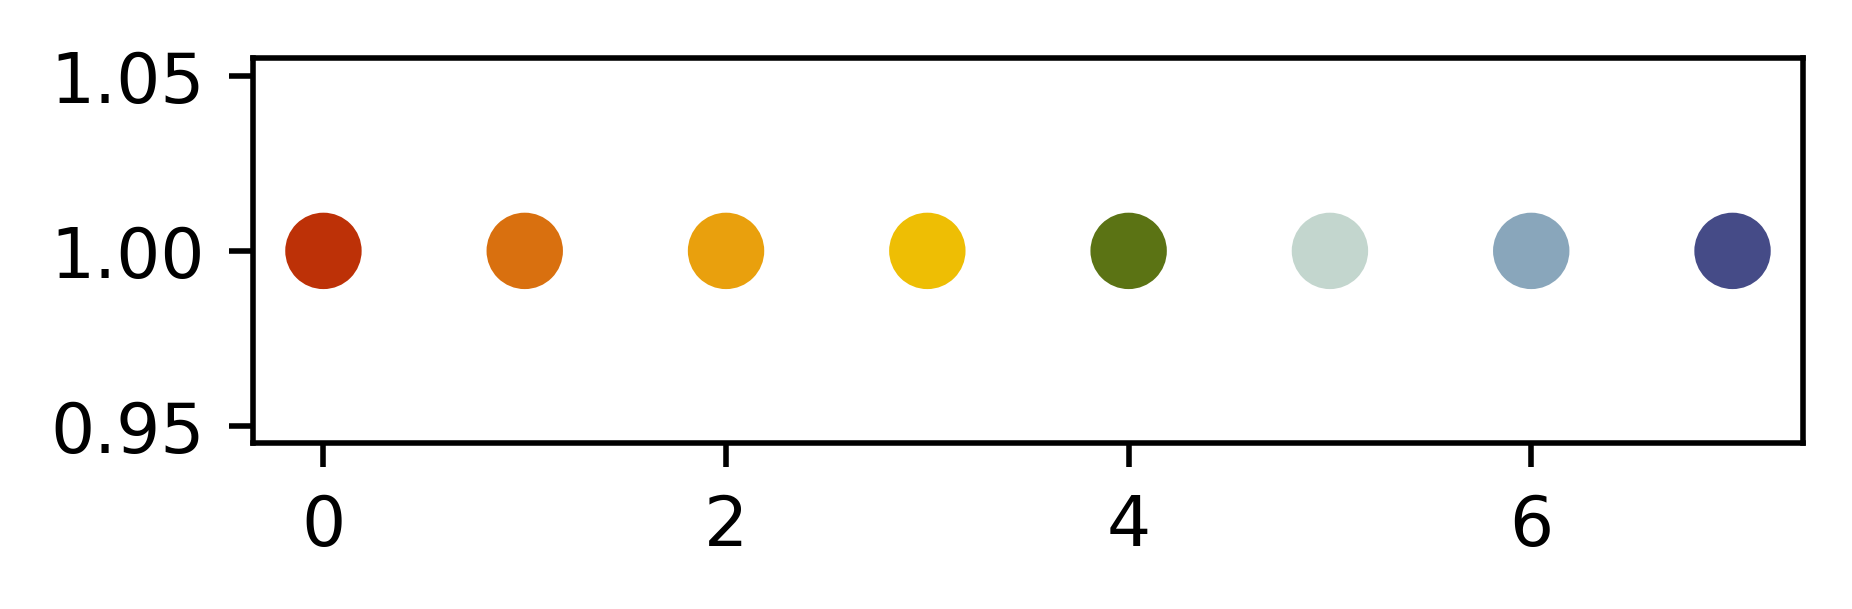

In [3]:
colors = ['#bd3107ff', '#d9700fff', '#e9a00dff', '#eebe04ff', '#5b7314ff', '#c3d6ceff', '#89a6bbff', '#454b87ff']
plt.figure(figsize=(4,1), dpi=500)
plt.scatter(y=np.ones(len(colors)), x=np.arange(len(colors)), color=colors, s=100)
plt.show()

palette = {'INSPIRE':colors[7],
           'eICU':colors[0]}

In [4]:
ward_vitals = pd.read_csv('INSPIRE/ward_vitals.csv')
labs = pd.read_csv('INSPIRE/labs.csv')
operations = pd.read_csv('INSPIRE/operations.csv')

In [5]:
ward_vitals.loc[ward_vitals['item_name'] == 'vent'].dropna().shape[0]

531512

In [6]:
ward_vitals.head()

,subject_id,chart_time,item_name,value
0,104192463,580,spo2,98.0
1,104192463,580,nibp_sbp,169.0
2,104192463,580,hr,96.0
3,104192463,580,nibp_dbp,100.0
4,104192463,580,bt,36.4


In [7]:
labs.head()

,subject_id,chart_time,item_name,value
0,133338290,86155,total_protein,6.9
1,133338290,86155,sodium,140.0
2,133338290,86155,potassium,4.4
3,133338290,86155,platelet,152.0
4,133338290,93150,glucose,120.0


In [8]:
operations.head()

,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,...,admission_time,discharge_time,anstart_time,anend_time,cpbon_time,cpboff_time,icuin_time,icuout_time,inhosp_death_time,allcause_death_time
0,484069807,178742874,229842382,NaN,0,30,F,50.0,155.0,Asian,...,0,7195,1120.0,1235.0,NaN,NaN,NaN,NaN,NaN,NaN
1,446270725,158995752,257857903,NaN,0,70,M,45.0,170.0,Asian,...,0,70555,1345.0,1540.0,NaN,NaN,1550.0,19595.0,69860.0,106560.0
2,406892271,108553242,200664328,NaN,61920,50,F,70.0,165.0,Asian,...,0,178555,62170.0,62370.0,NaN,NaN,NaN,NaN,NaN,718560.0
3,478413008,133278262,277235295,NaN,0,35,F,55.0,NaN,Asian,...,0,5755,215.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN
4,468516791,116924034,299190423,NaN,17280,45,F,45.0,150.0,Asian,...,0,25915,17950.0,18070.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
operations = operations[(operations['height'] > 0) & (operations['weight'] > 0) &
                         operations['height'].notna() & operations['weight'].notna()]


operations_features = []
for col in ['op_id','subject_id','age','height','weight','anstart_time','anend_time','icd10_pcs','antype']:
  if col not in operations.columns:
    print(f'{col} not in columns')
  else:
    operations_features.append(col)



# Create a copy of the filtered data to avoid the SettingWithCopyWarning
# Filter rows first
valid_heights = operations['height'].between(50, 250, inclusive='both')
valid_weights = operations['weight'].between(20, 300, inclusive='both')
operations_filtered = operations[valid_heights & valid_weights].copy()

# Now select columns
operations_sub = operations_filtered[operations_features].copy()
print(f"Shape after column selection: {operations_sub.shape}")

# Convert height from cm to meters for BMI calculation
operations_sub['height_m'] = operations_sub['height']/100  # Convert cm to meters

# Calculate BMI using the corrected height in meters
operations_sub['BMI'] = operations_sub.apply(
    lambda row: calculate_bmi(row['weight'], row['height_m']),
    axis=1
)

# Check the actual format of time columns
print(f"anstart_time sample values: {operations_sub['anstart_time'].head(3).tolist()}")
print(f"anend_time sample values: {operations_sub['anend_time'].head(3).tolist()}")

# For military time format (like 1345.0 meaning 13:45)
# Calculate duration in minutes directly from numerical values
if 'anstart_time' in operations_sub.columns and 'anend_time' in operations_sub.columns:
    try:
        # Convert float military time to minutes
        def military_time_to_minutes(time_float):
            if pd.isna(time_float):
                return np.nan

            # Extract hours and minutes
            hours = int(time_float // 100)
            minutes = int(time_float % 100)

            # Handle potential overflow (e.g., 2400 should be 0)
            hours = hours % 24

            # Convert to total minutes
            return hours * 60 + minutes

        # Calculate start and end times in minutes
        operations_sub['start_minutes'] = operations_sub['anstart_time'].apply(military_time_to_minutes)
        operations_sub['end_minutes'] = operations_sub['anend_time'].apply(military_time_to_minutes)

        # Calculate duration - handling cases where end time is on the next day
        operations_sub['anesthesia_duration'] = operations_sub.apply(
            lambda row: row['end_minutes'] - row['start_minutes'] if row['end_minutes'] >= row['start_minutes']
                        else row['end_minutes'] + 24*60 - row['start_minutes'],
            axis=1
        )

        # Print duration statistics
        print(f"Duration min: {operations_sub['anesthesia_duration'].min()}, max: {operations_sub['anesthesia_duration'].max()}")
        print(f"Rows with duration >= 60 mins: {(operations_sub['anesthesia_duration'] >= 60).sum()} out of {len(operations_sub)}")

        # Filter out invalid durations - but with a more appropriate threshold
        # Set to 0 if you want to keep all valid durations
        operations_sub = operations_sub[operations_sub['anesthesia_duration'] >= 60]
        print(f"Shape after duration filtering: {operations_sub.shape}")

        # Optionally drop the intermediate columns
        operations_sub = operations_sub.drop(['start_minutes', 'end_minutes'], axis=1)

    except Exception as e:
        print(f"Error processing times: {e}")
        operations_sub['anesthesia_duration'] = np.nan
else:
    print("Time columns not found in dataframe")

# Final shape
print(f"Final shape of operations_sub: {operations_sub.shape}")

Shape after column selection: (128994, 9)
anstart_time sample values: [1120.0, 1345.0, 62170.0]
anend_time sample values: [1235.0, 1540.0, 62370.0]
Duration min: -30.0, max: 1435.0
Rows with duration >= 60 mins: 83580 out of 128994
Shape after duration filtering: (83580, 14)
Final shape of operations_sub: (83580, 12)


age: min = 20, max = 90 


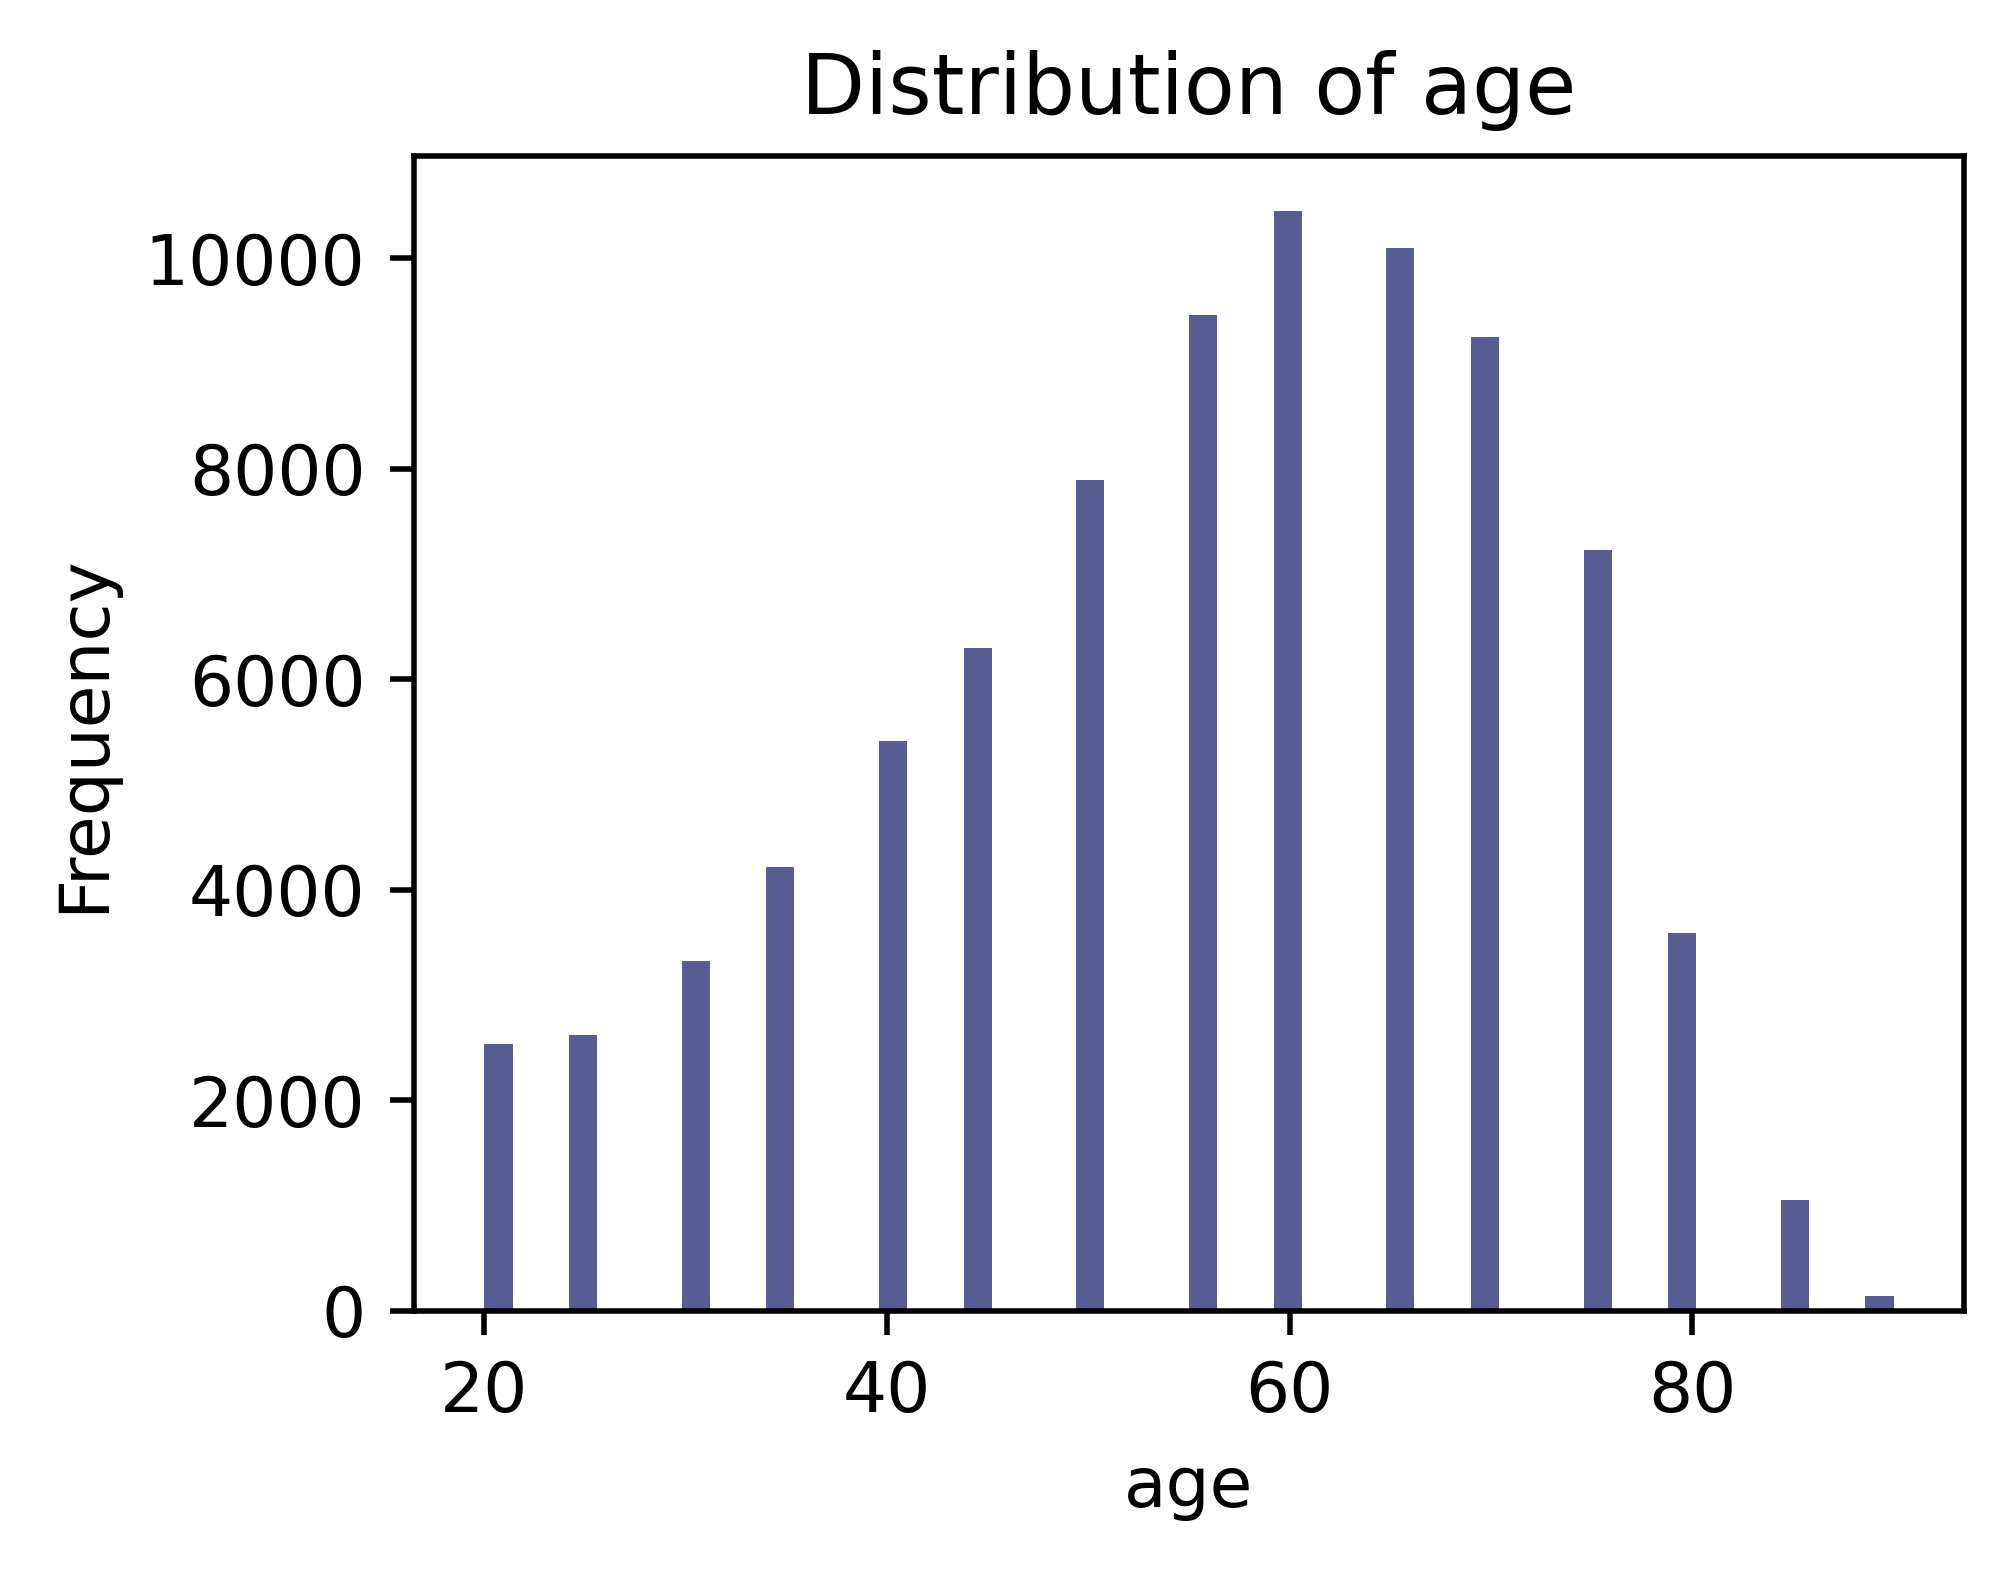

height: min = 50.0, max = 200.0 


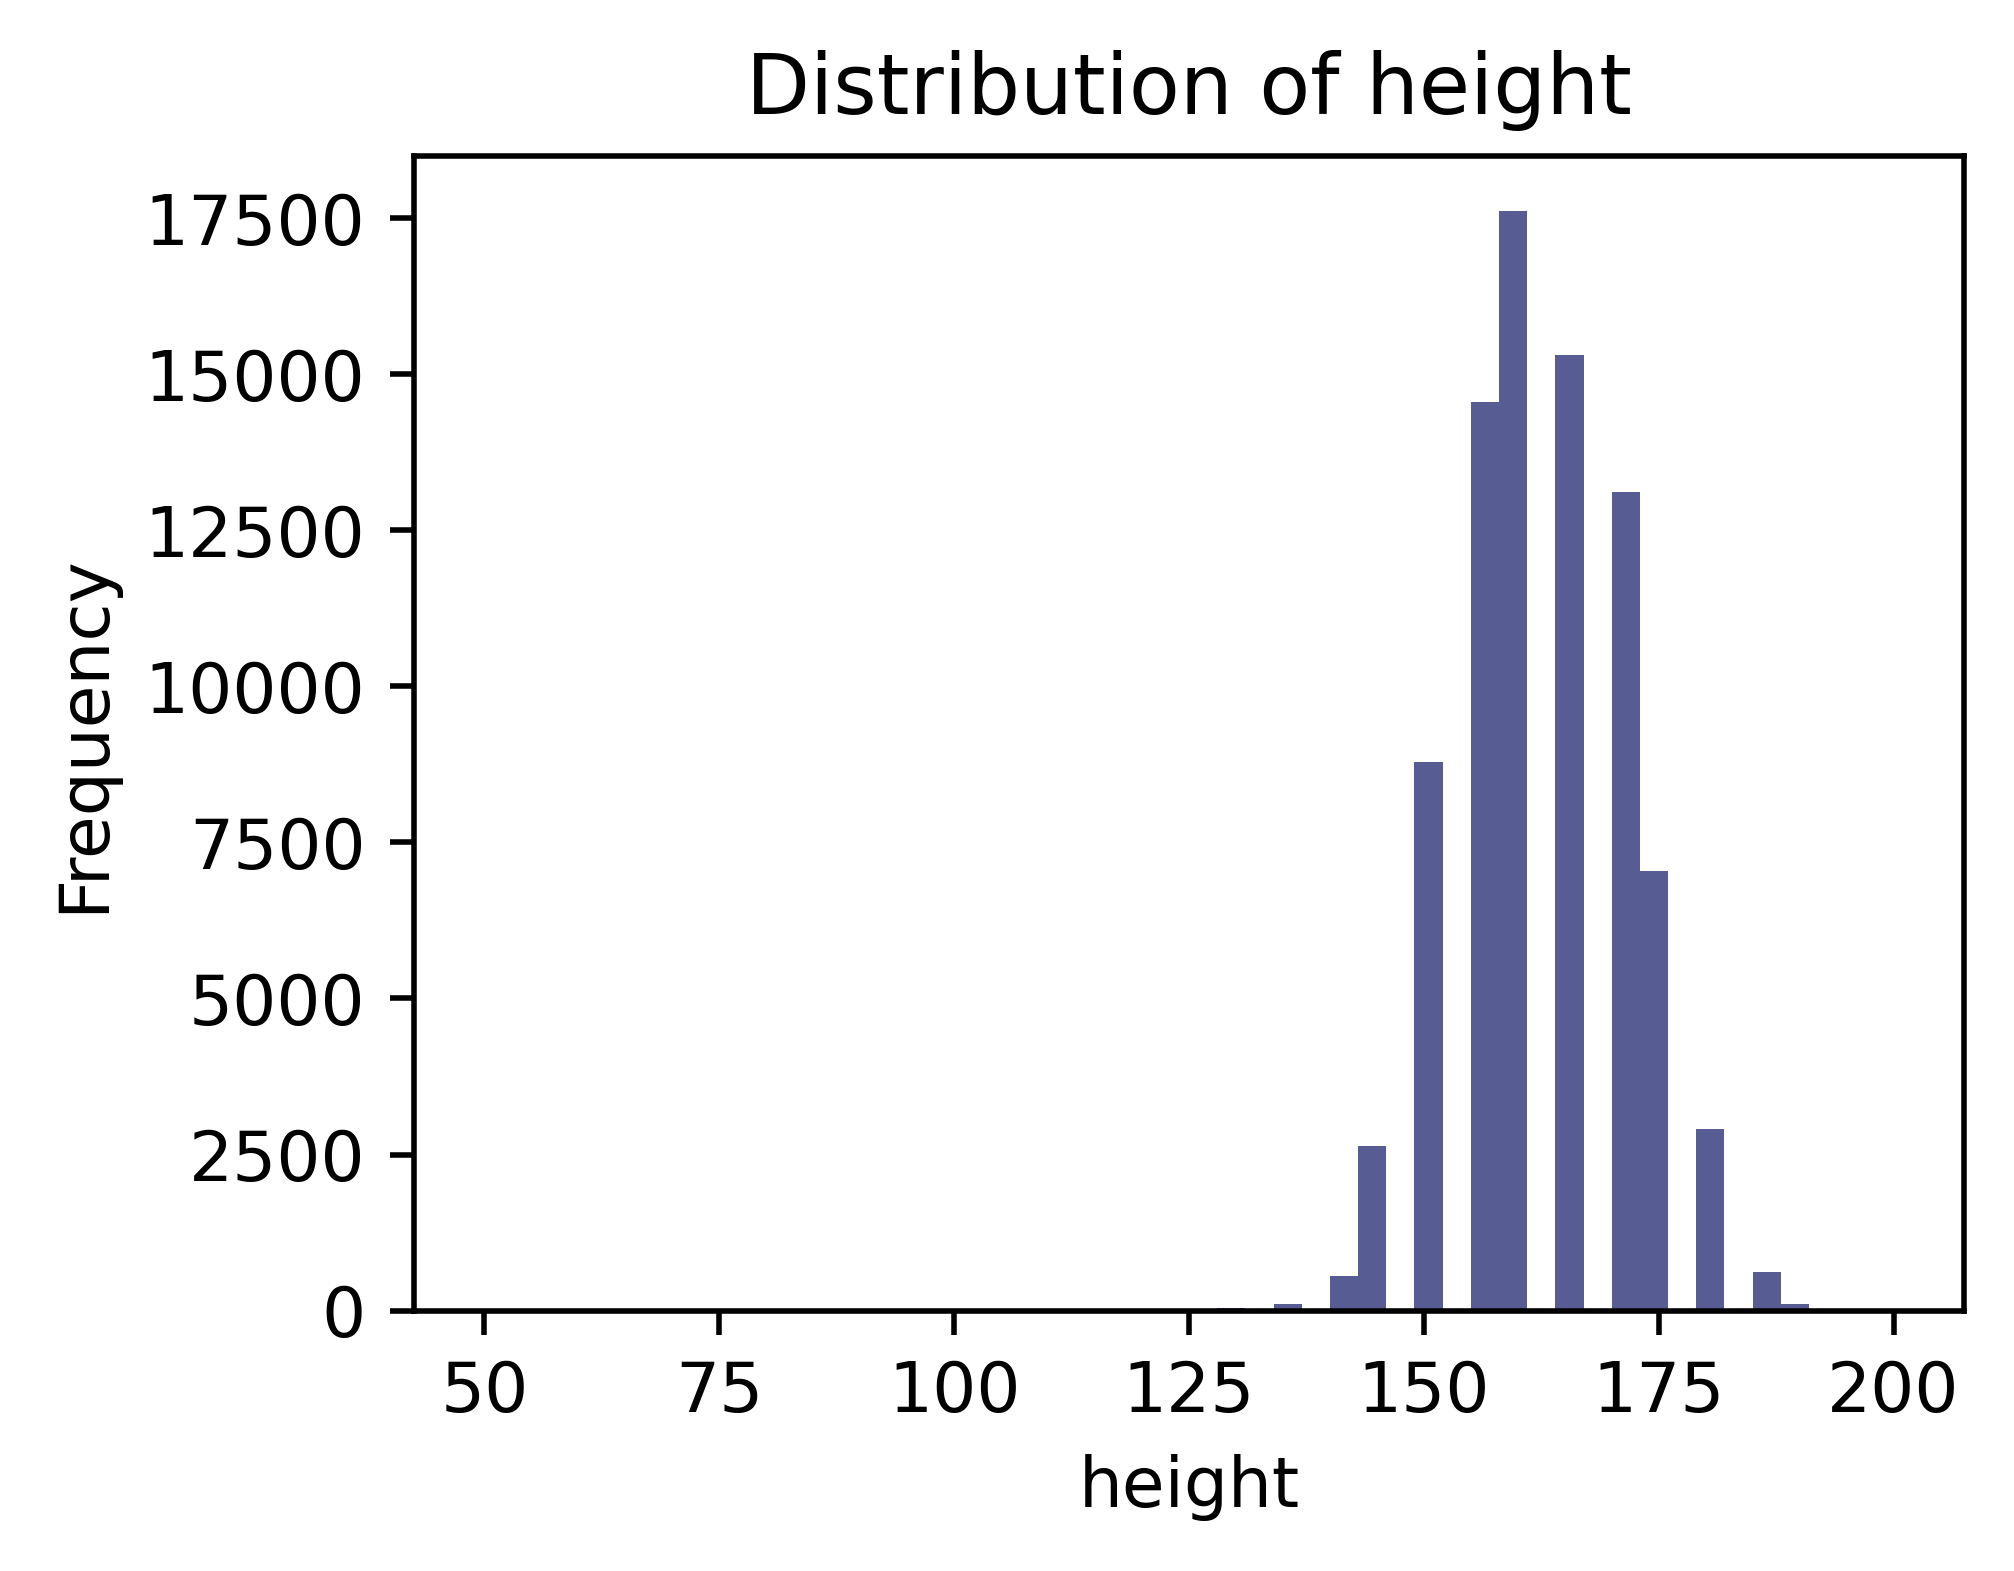

weight: min = 20.0, max = 180.0 


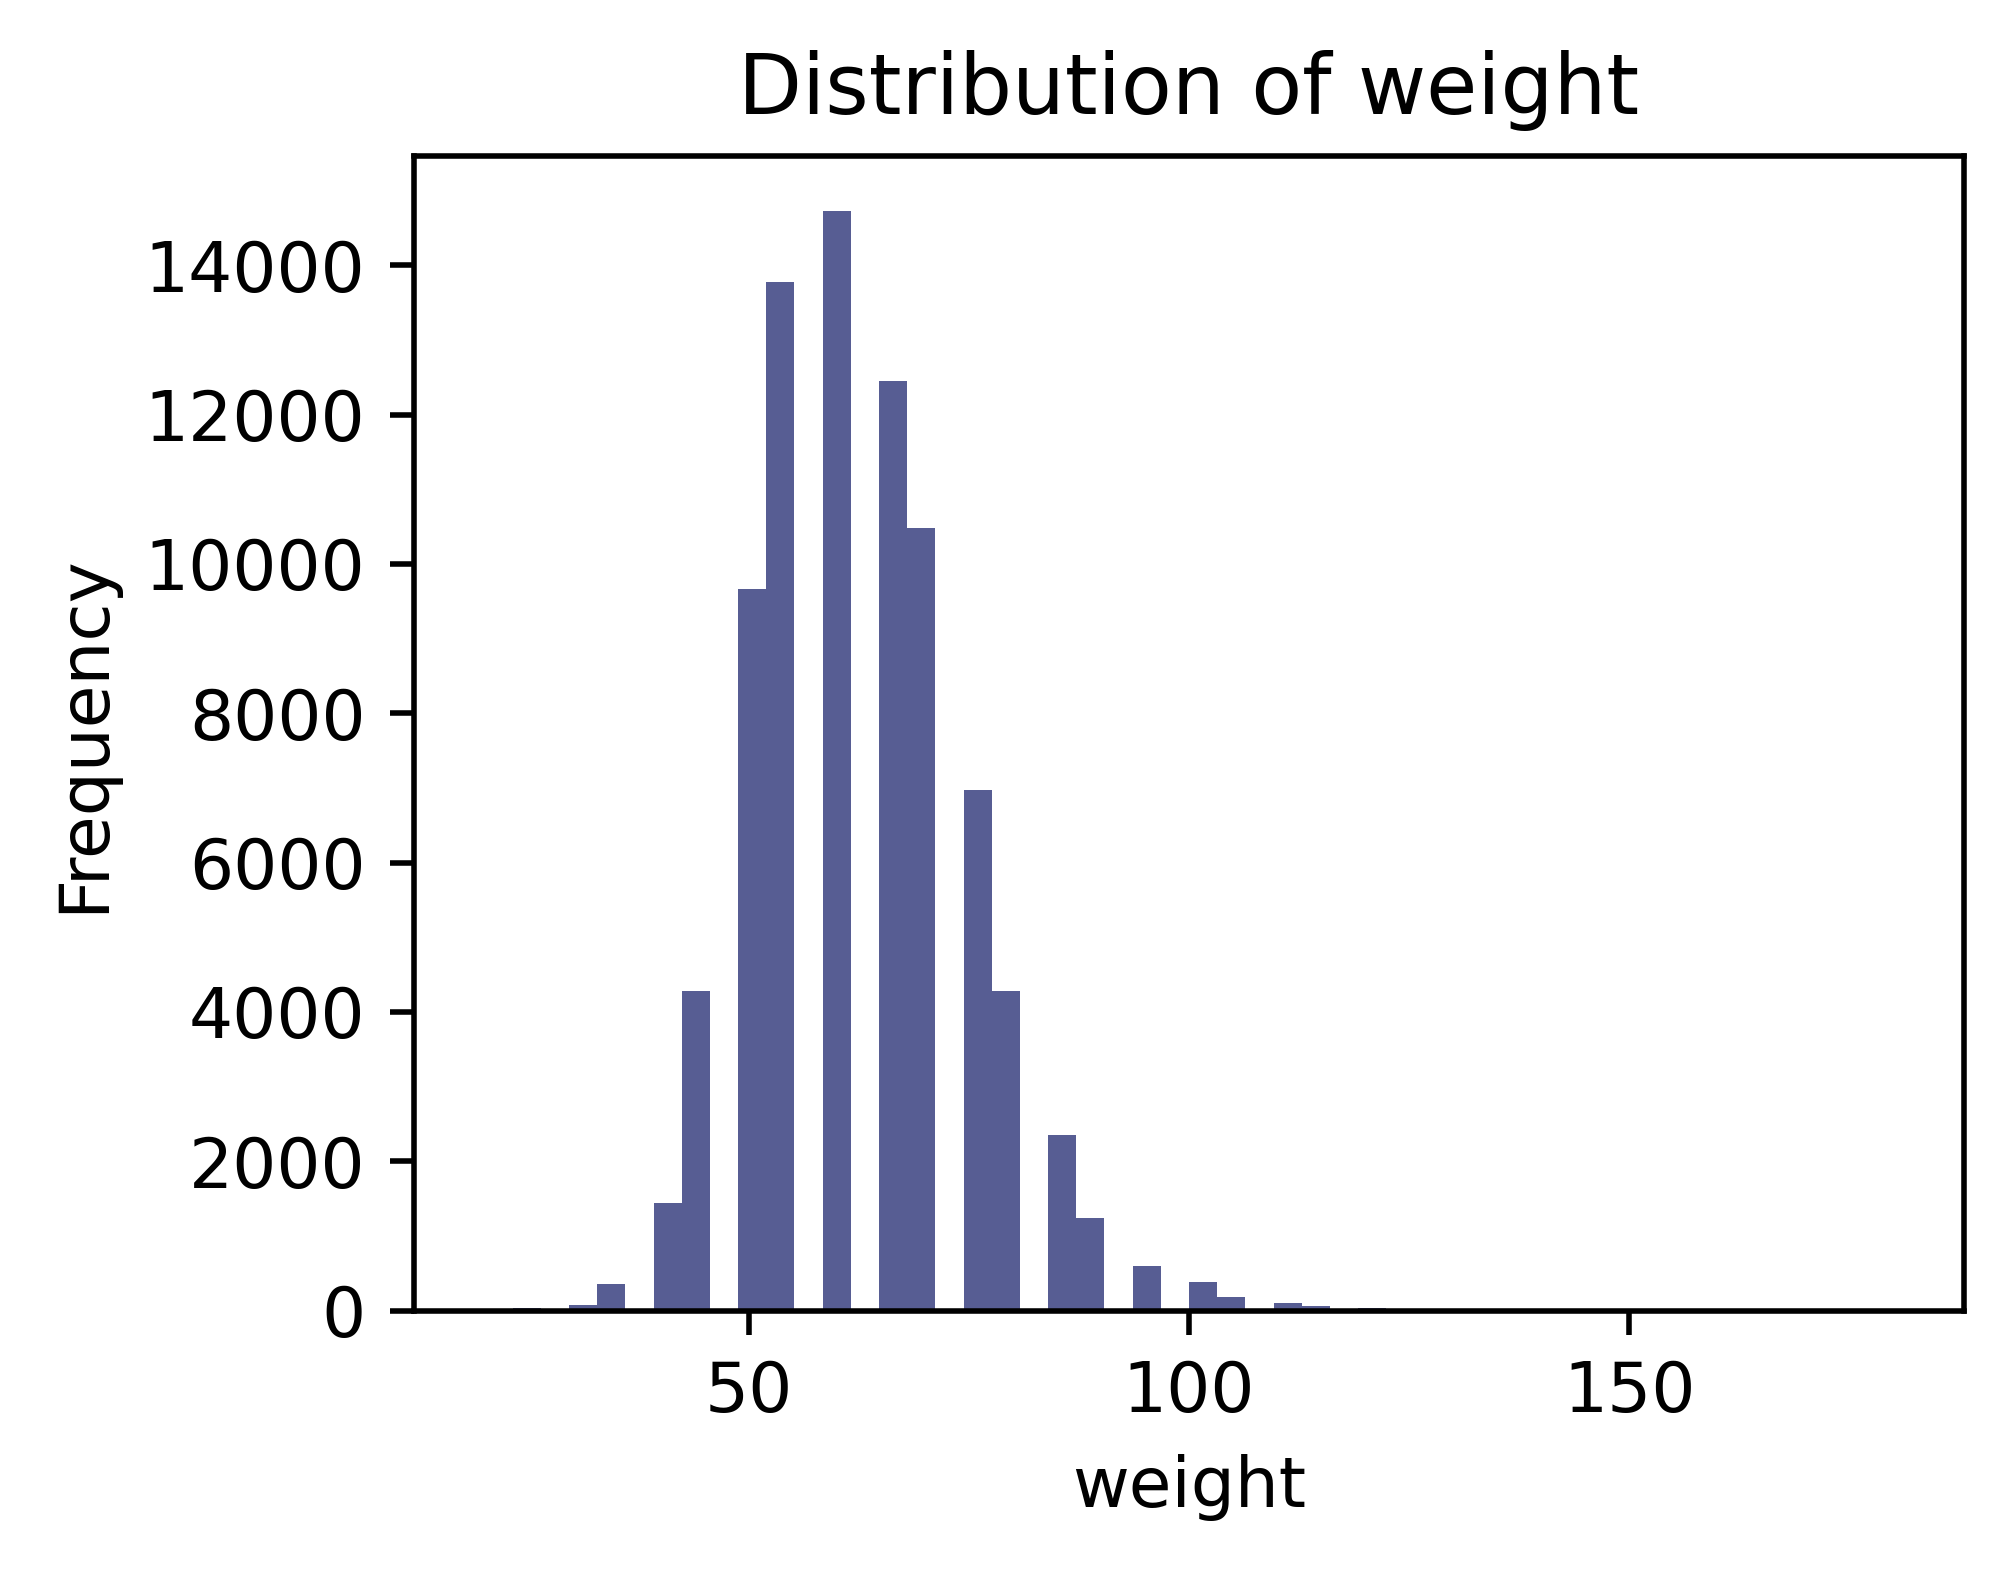

anstart_time: min = -10.0, max = 5185070.0 


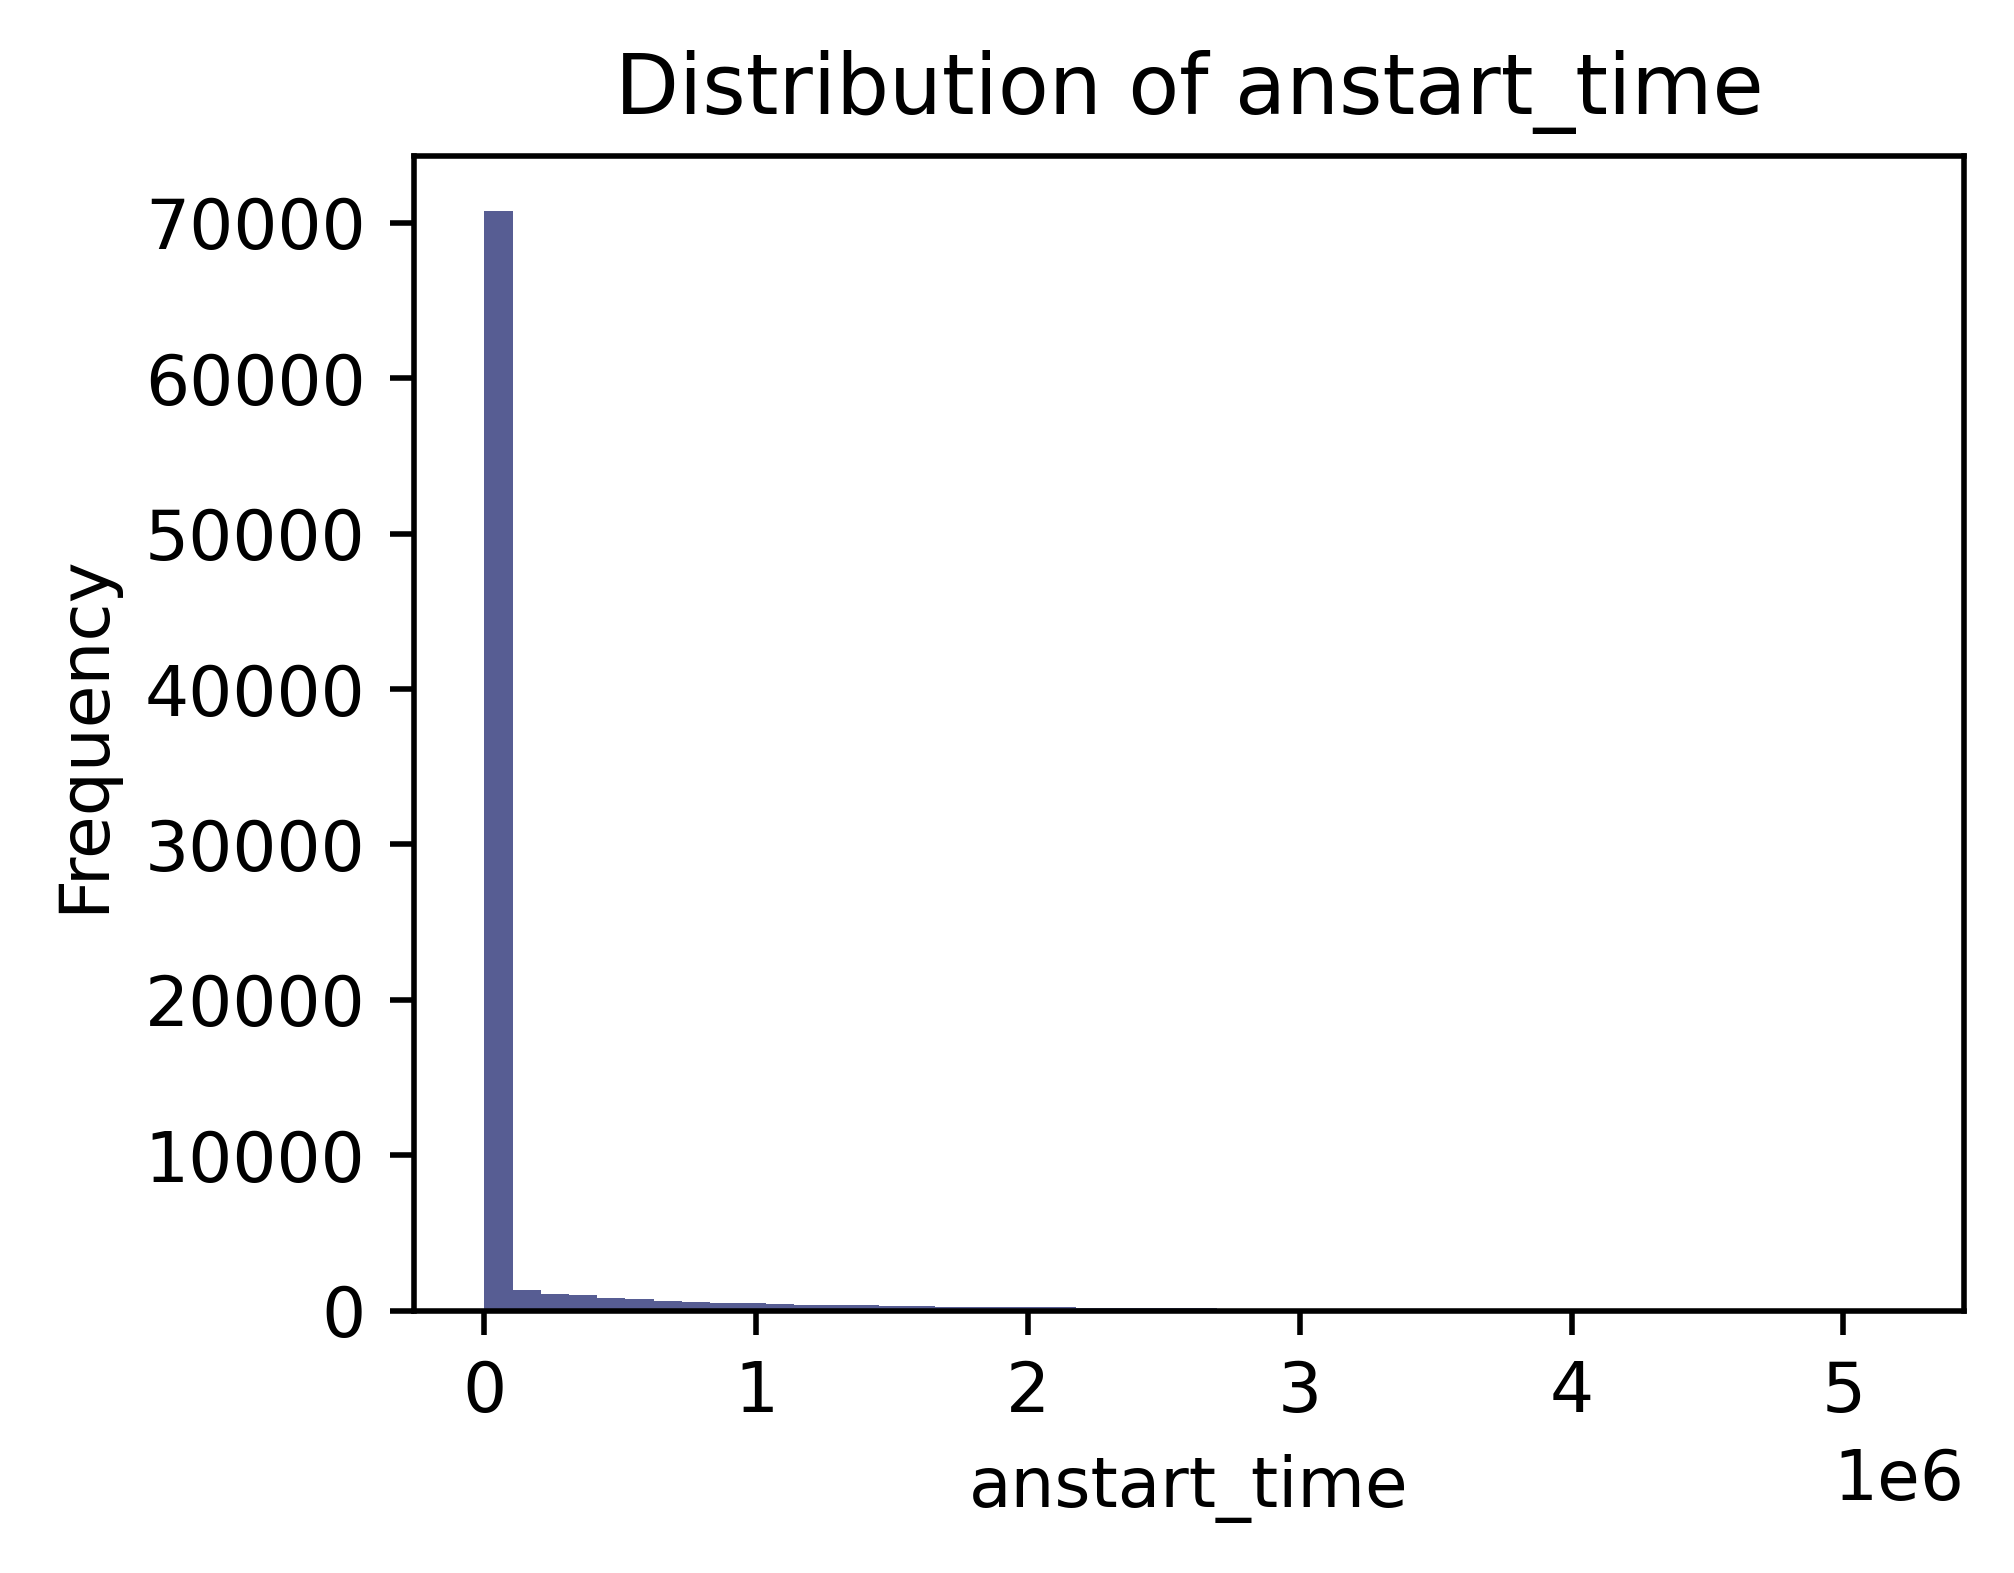

anend_time: min = 90.0, max = 5185170.0 


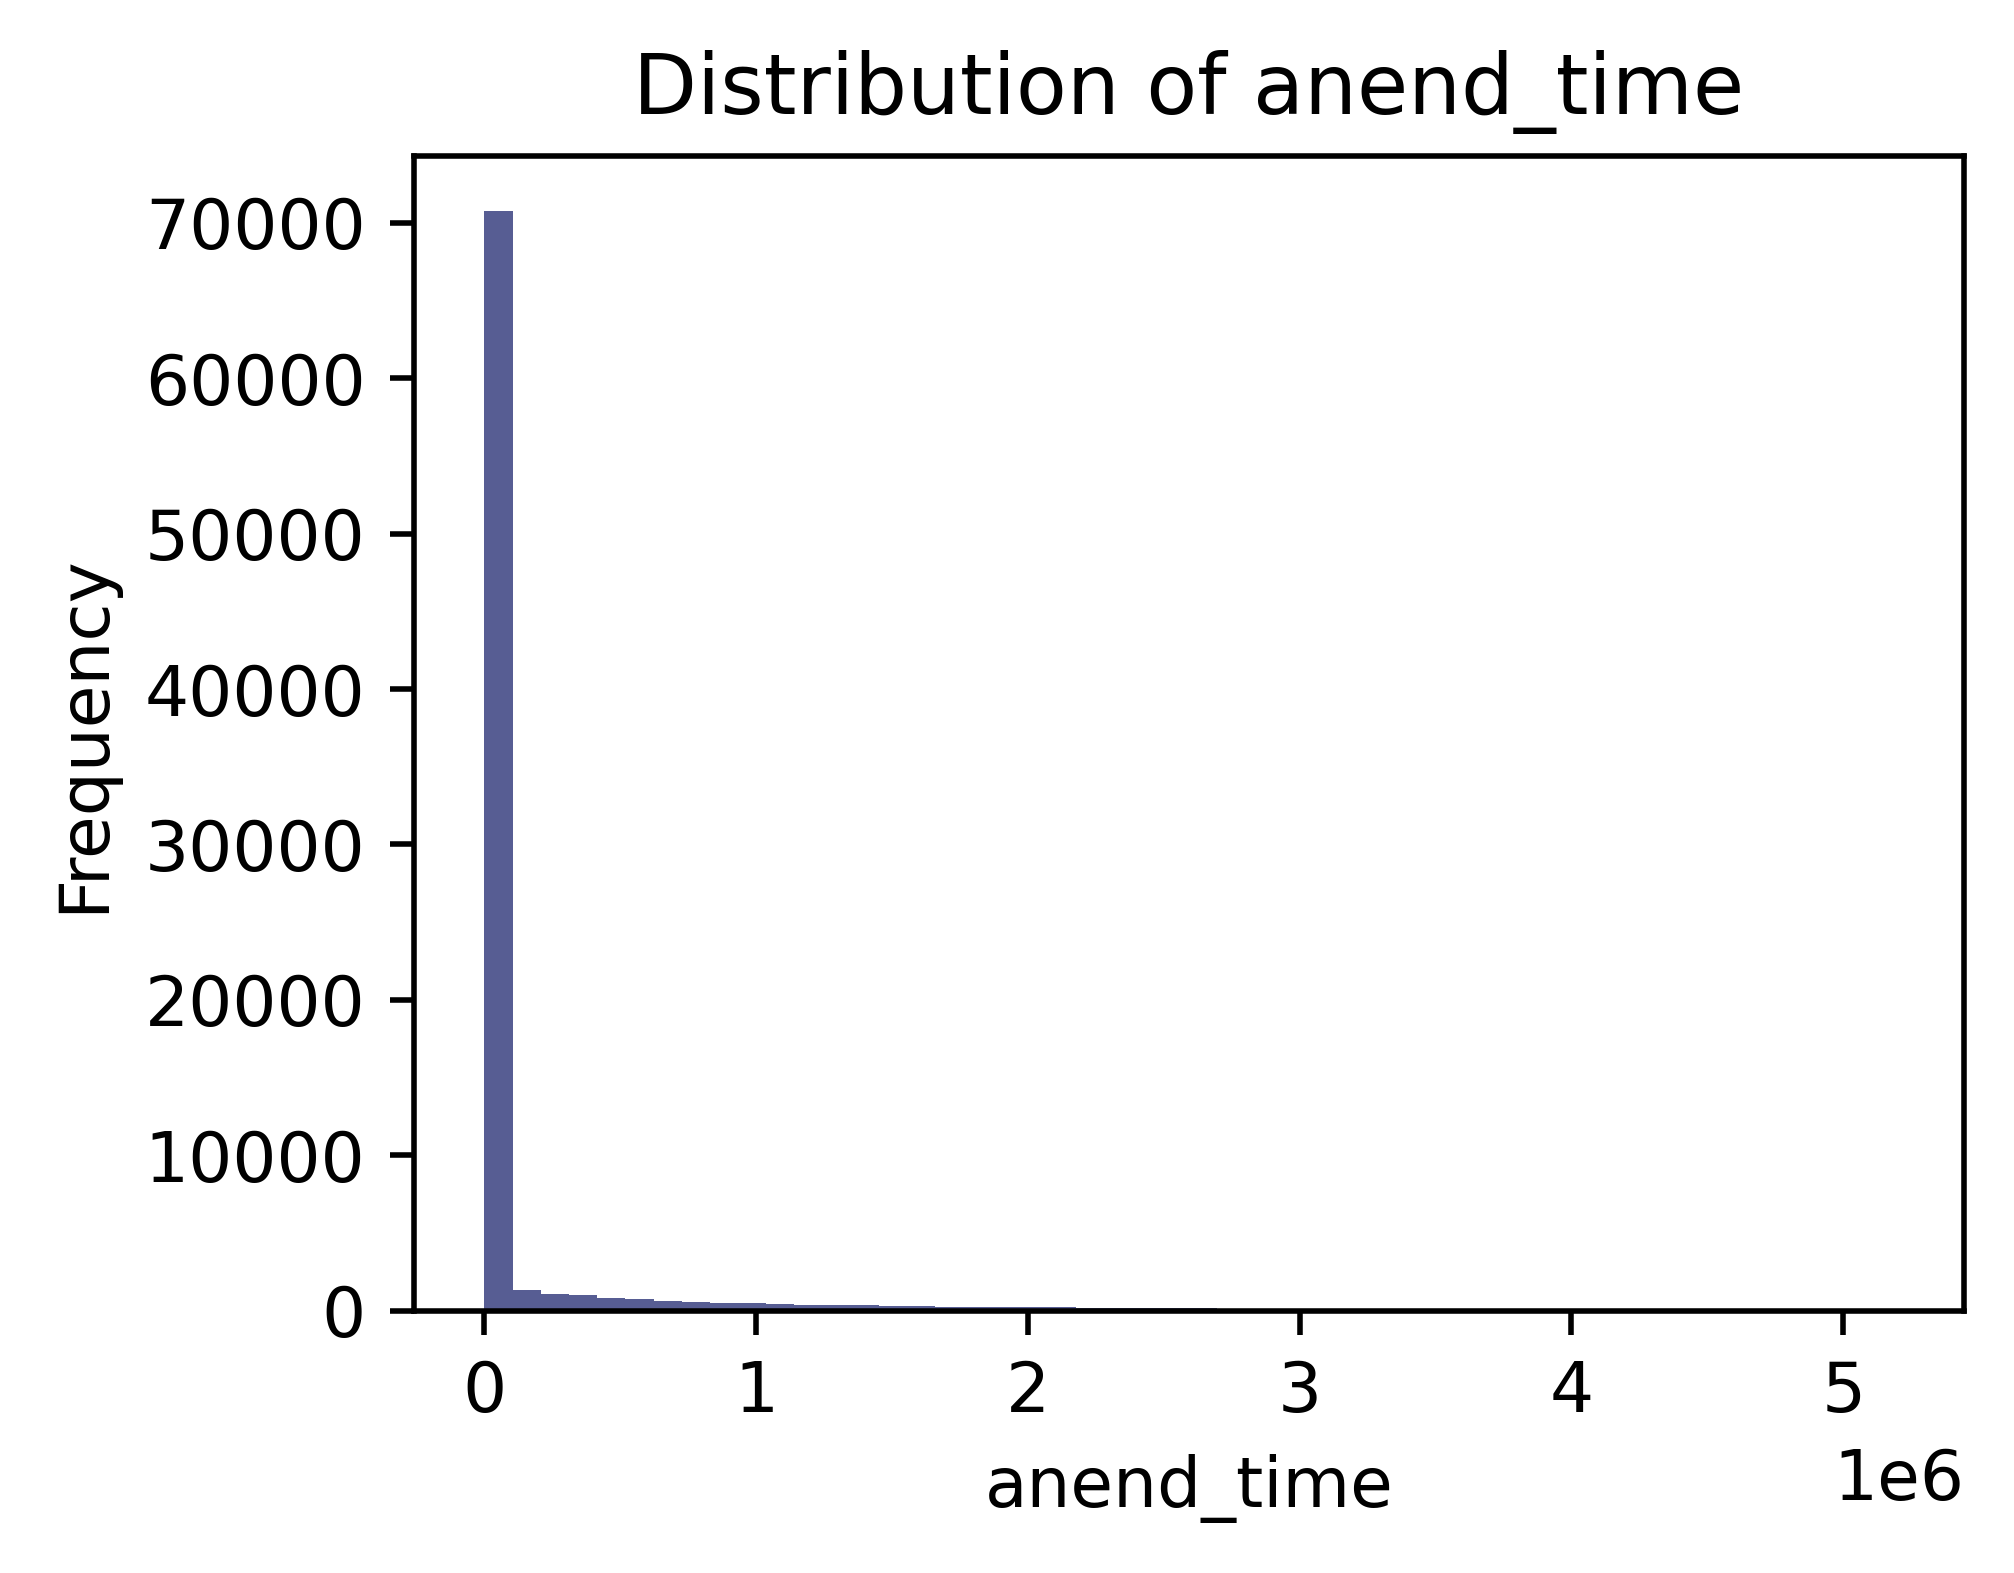

icd10_pcs: min = 00100, max = 10D00 


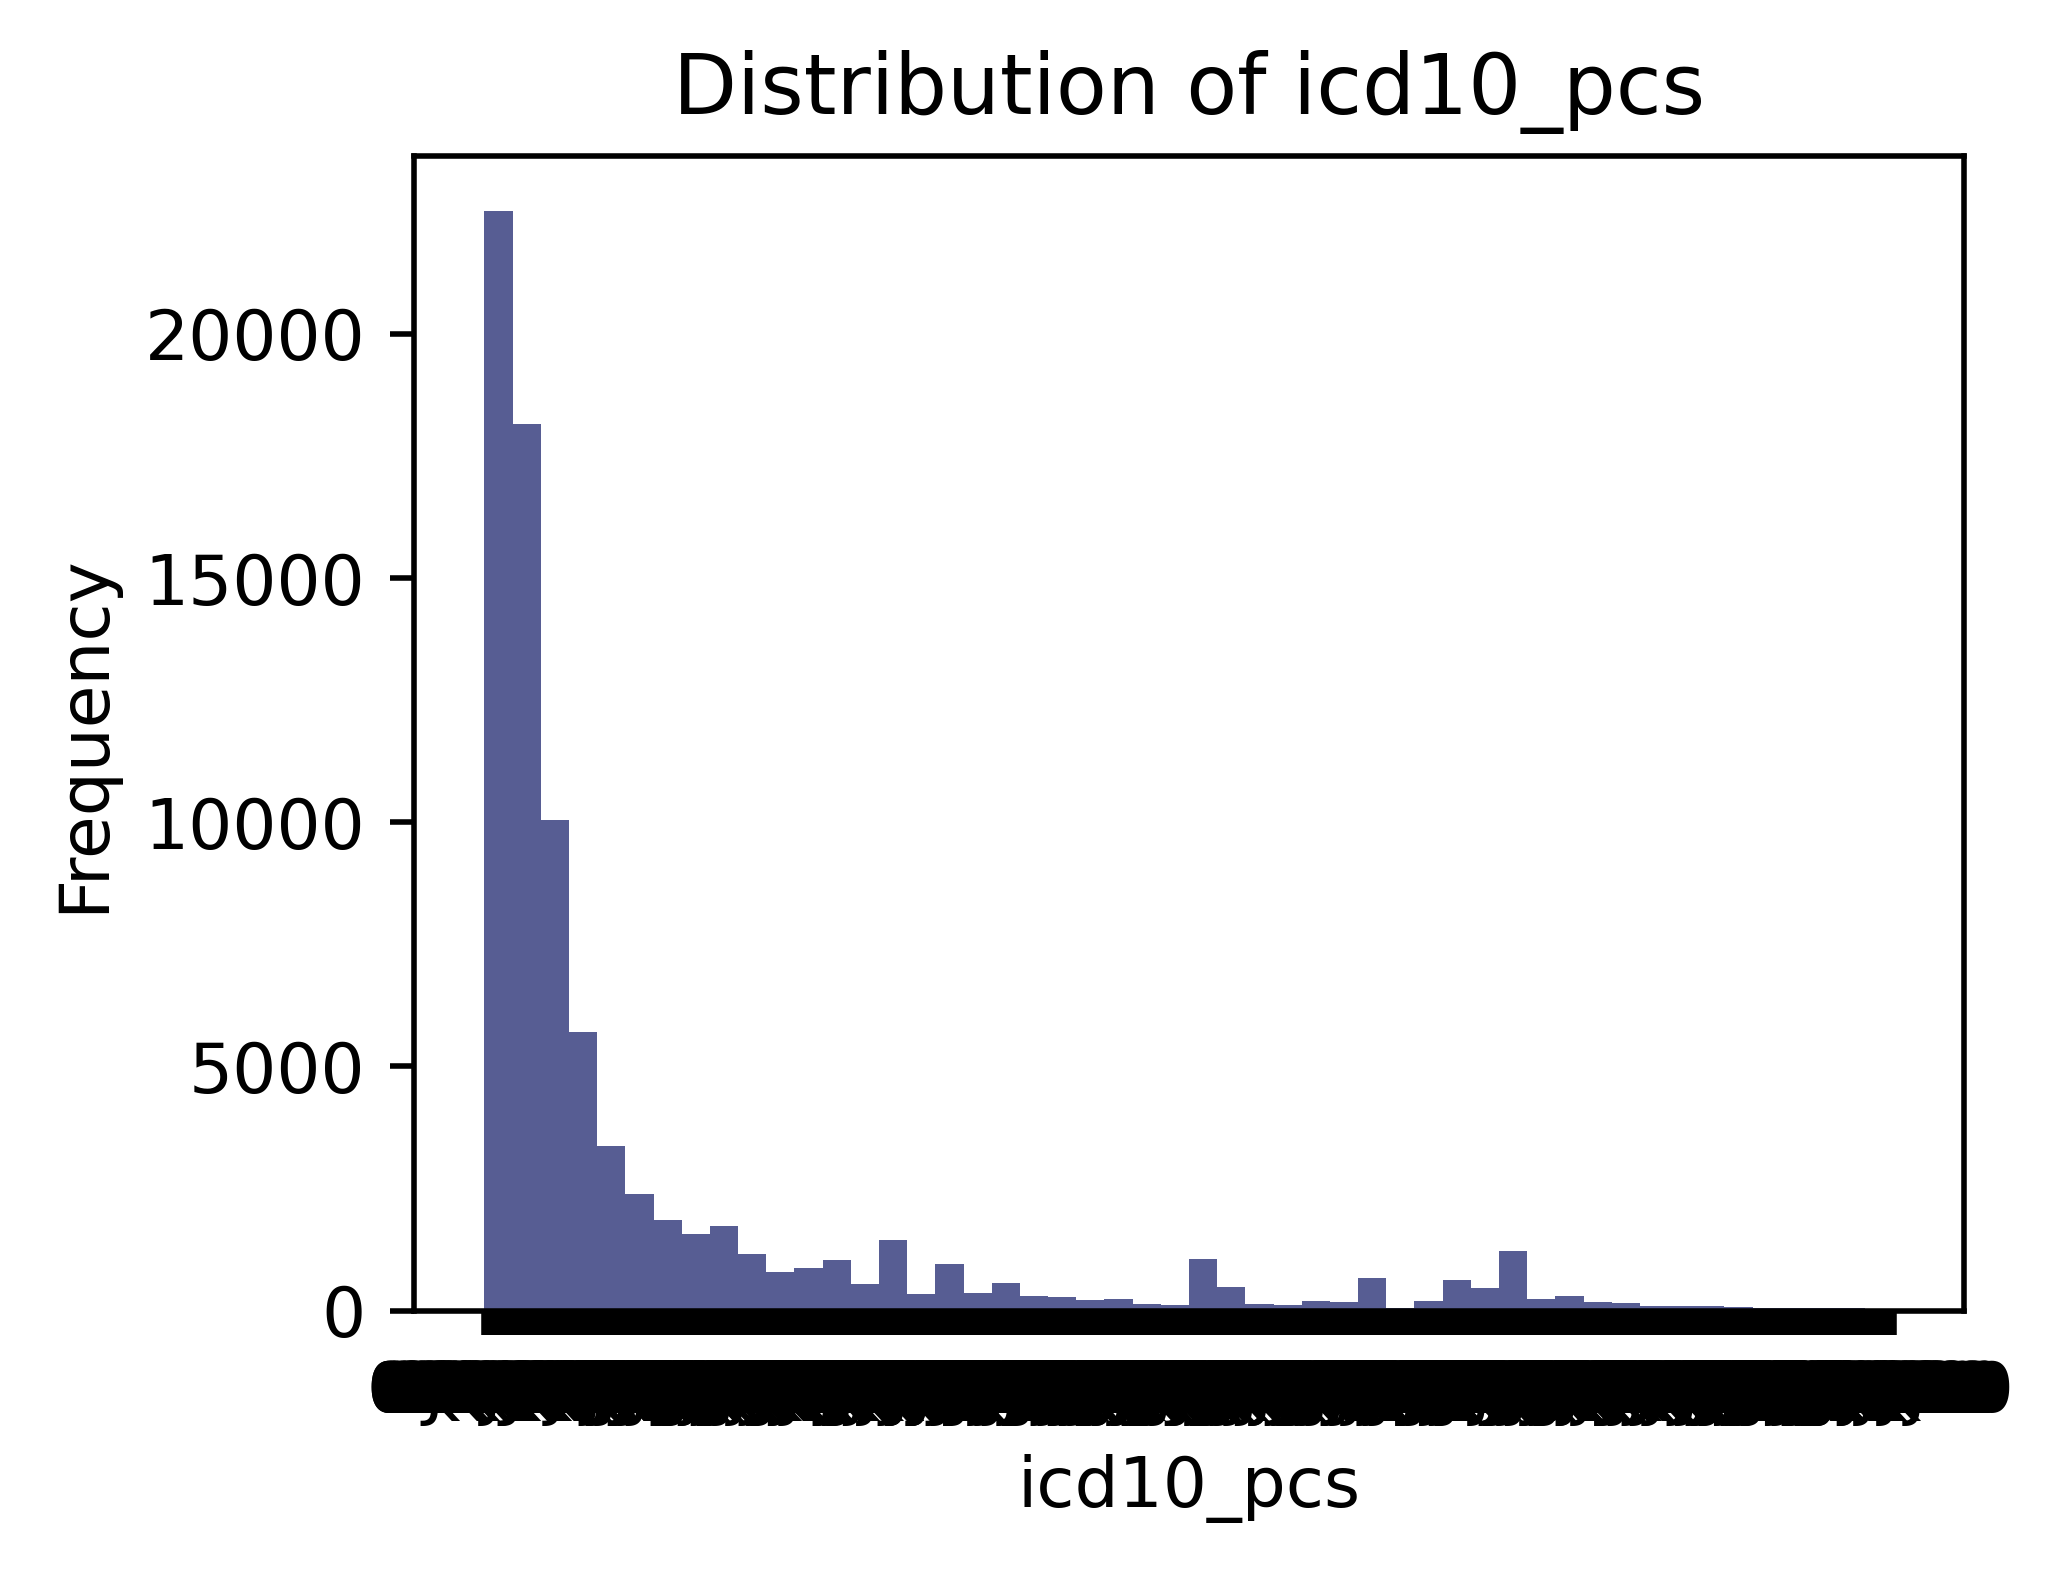

antype: min = General, max = Regional 


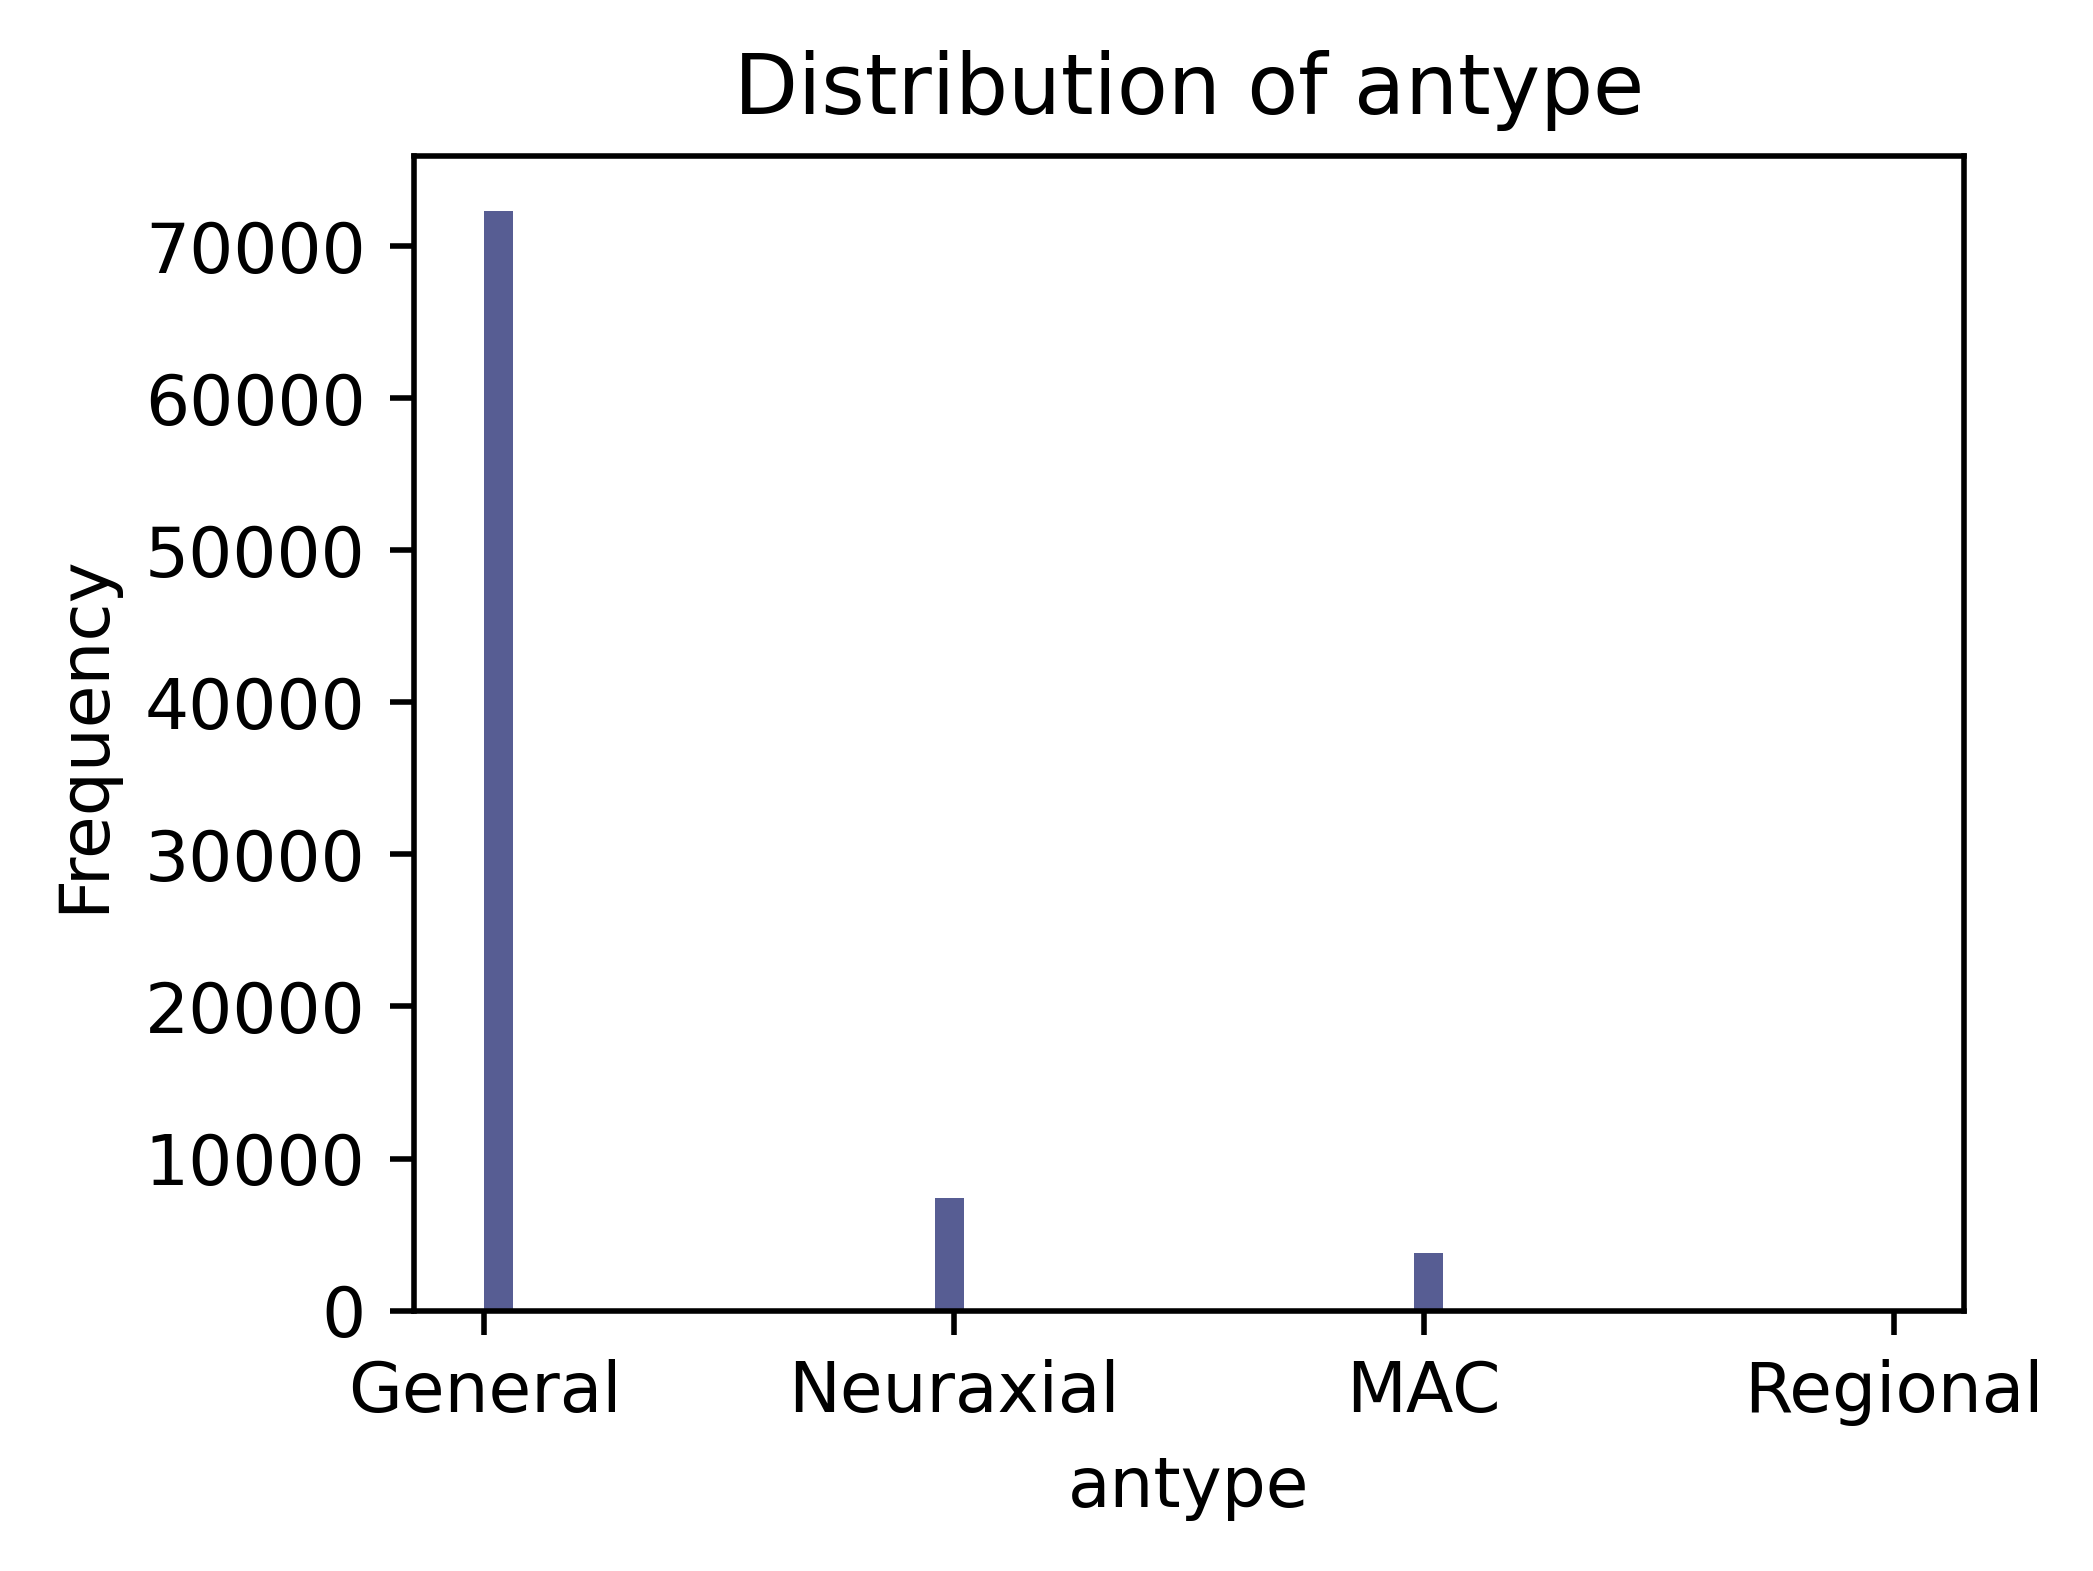

height_m: min = 0.5, max = 2.0 


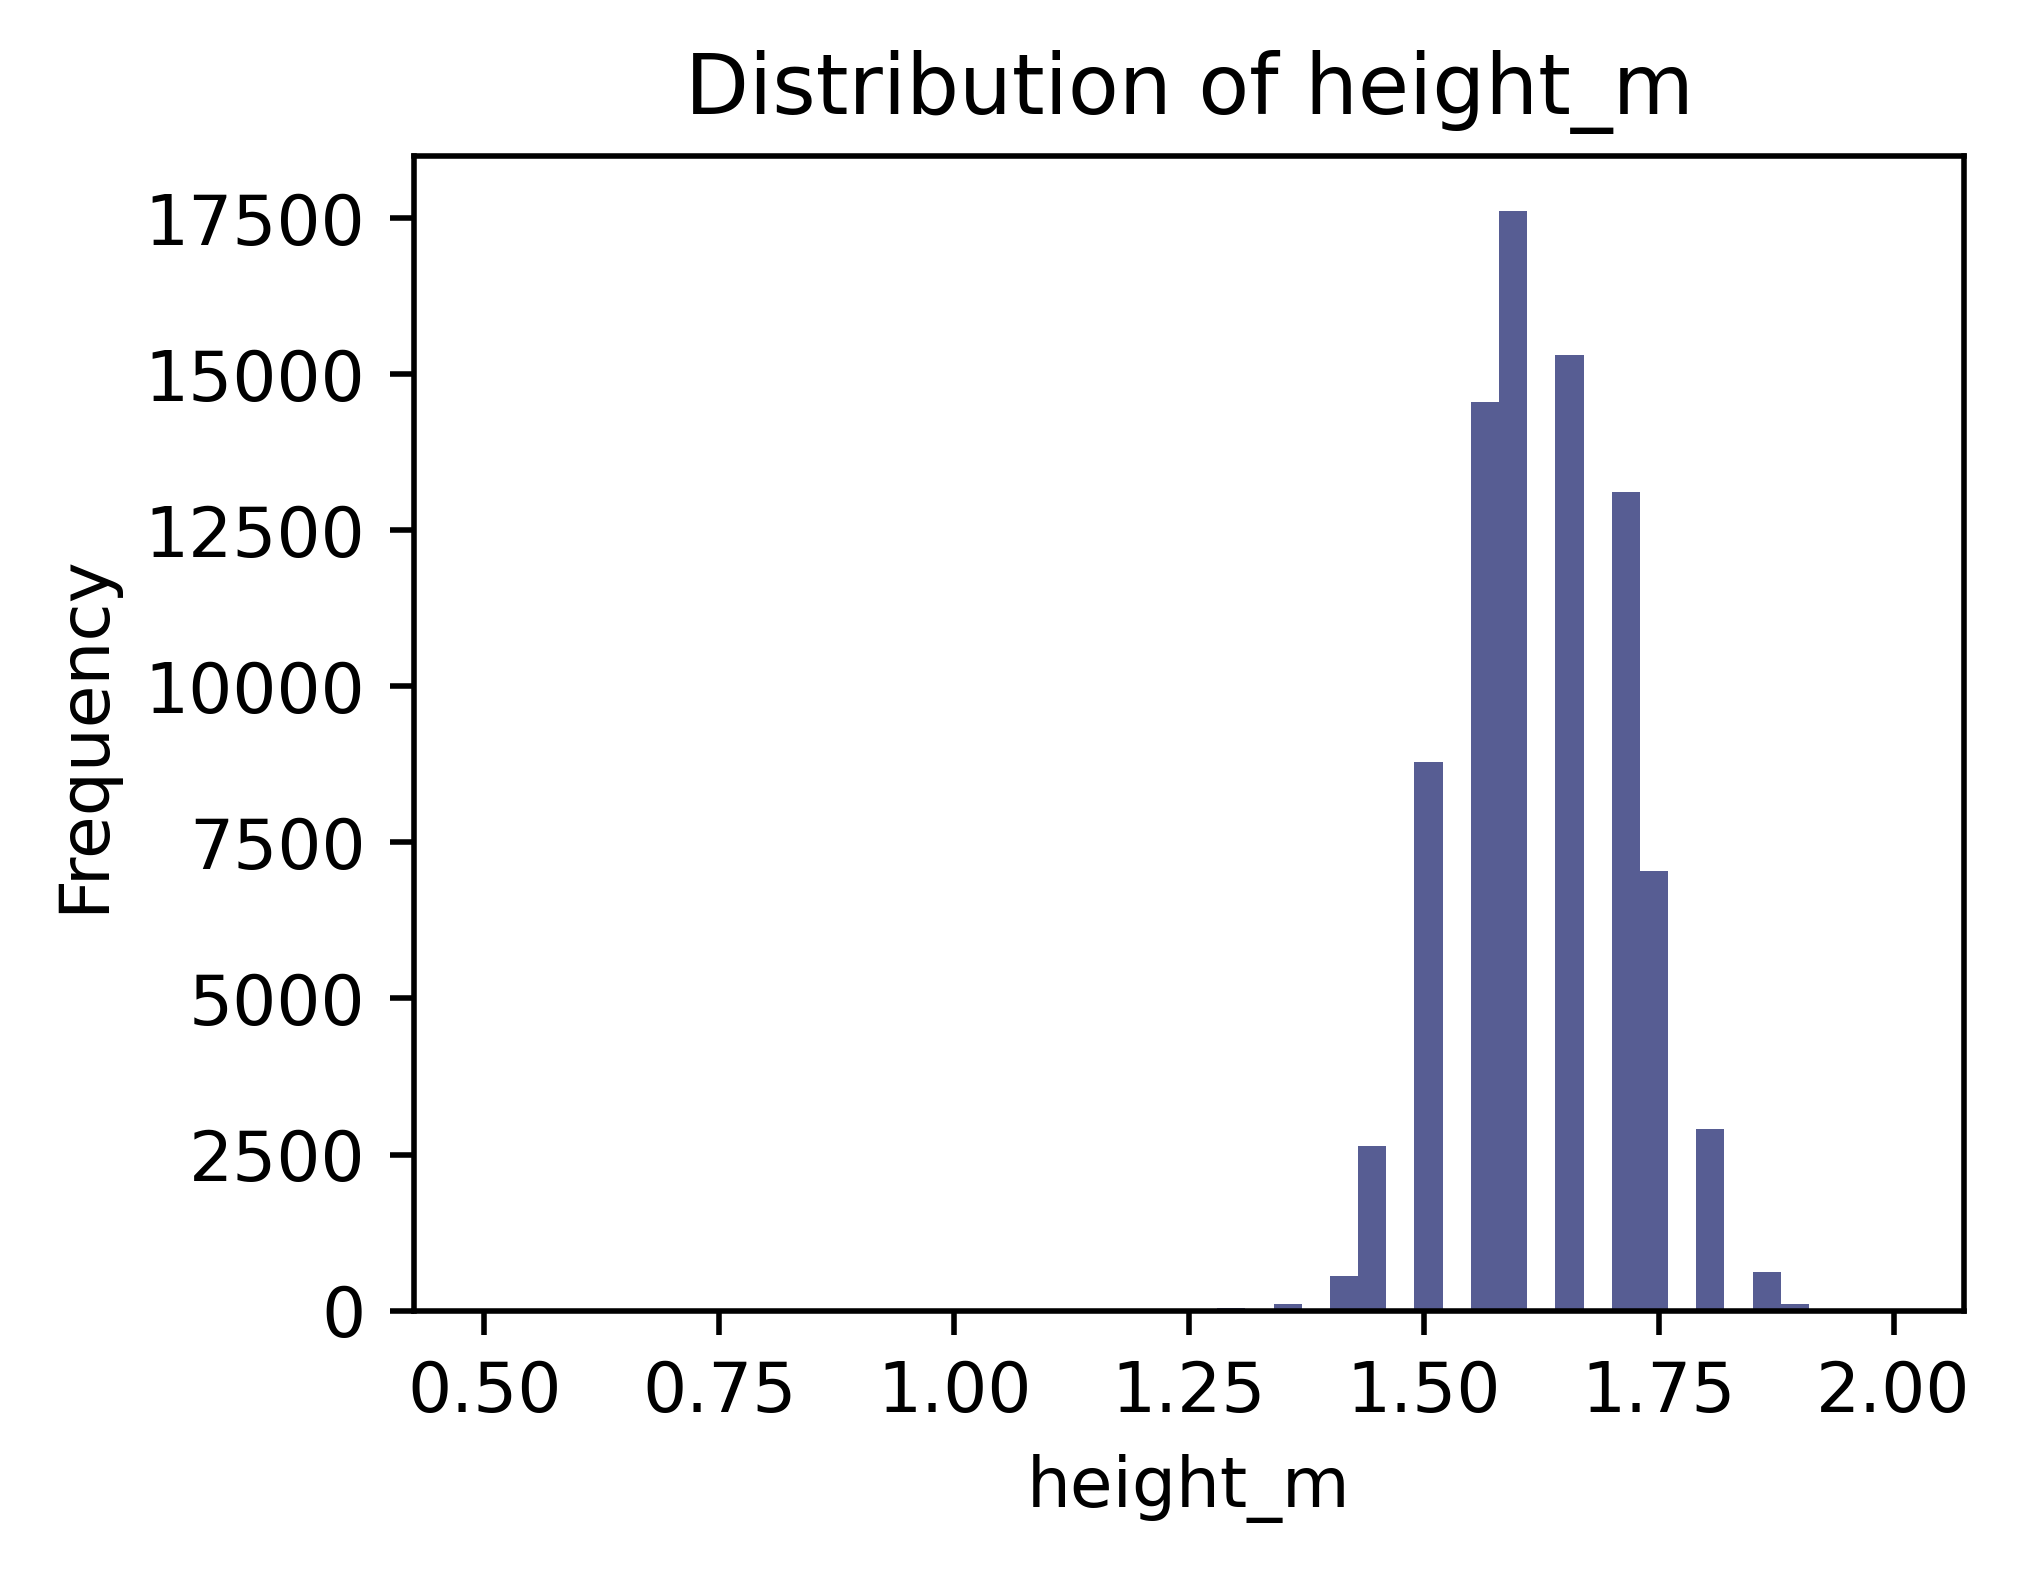

BMI: min = 6.530612244897959, max = 260.0 


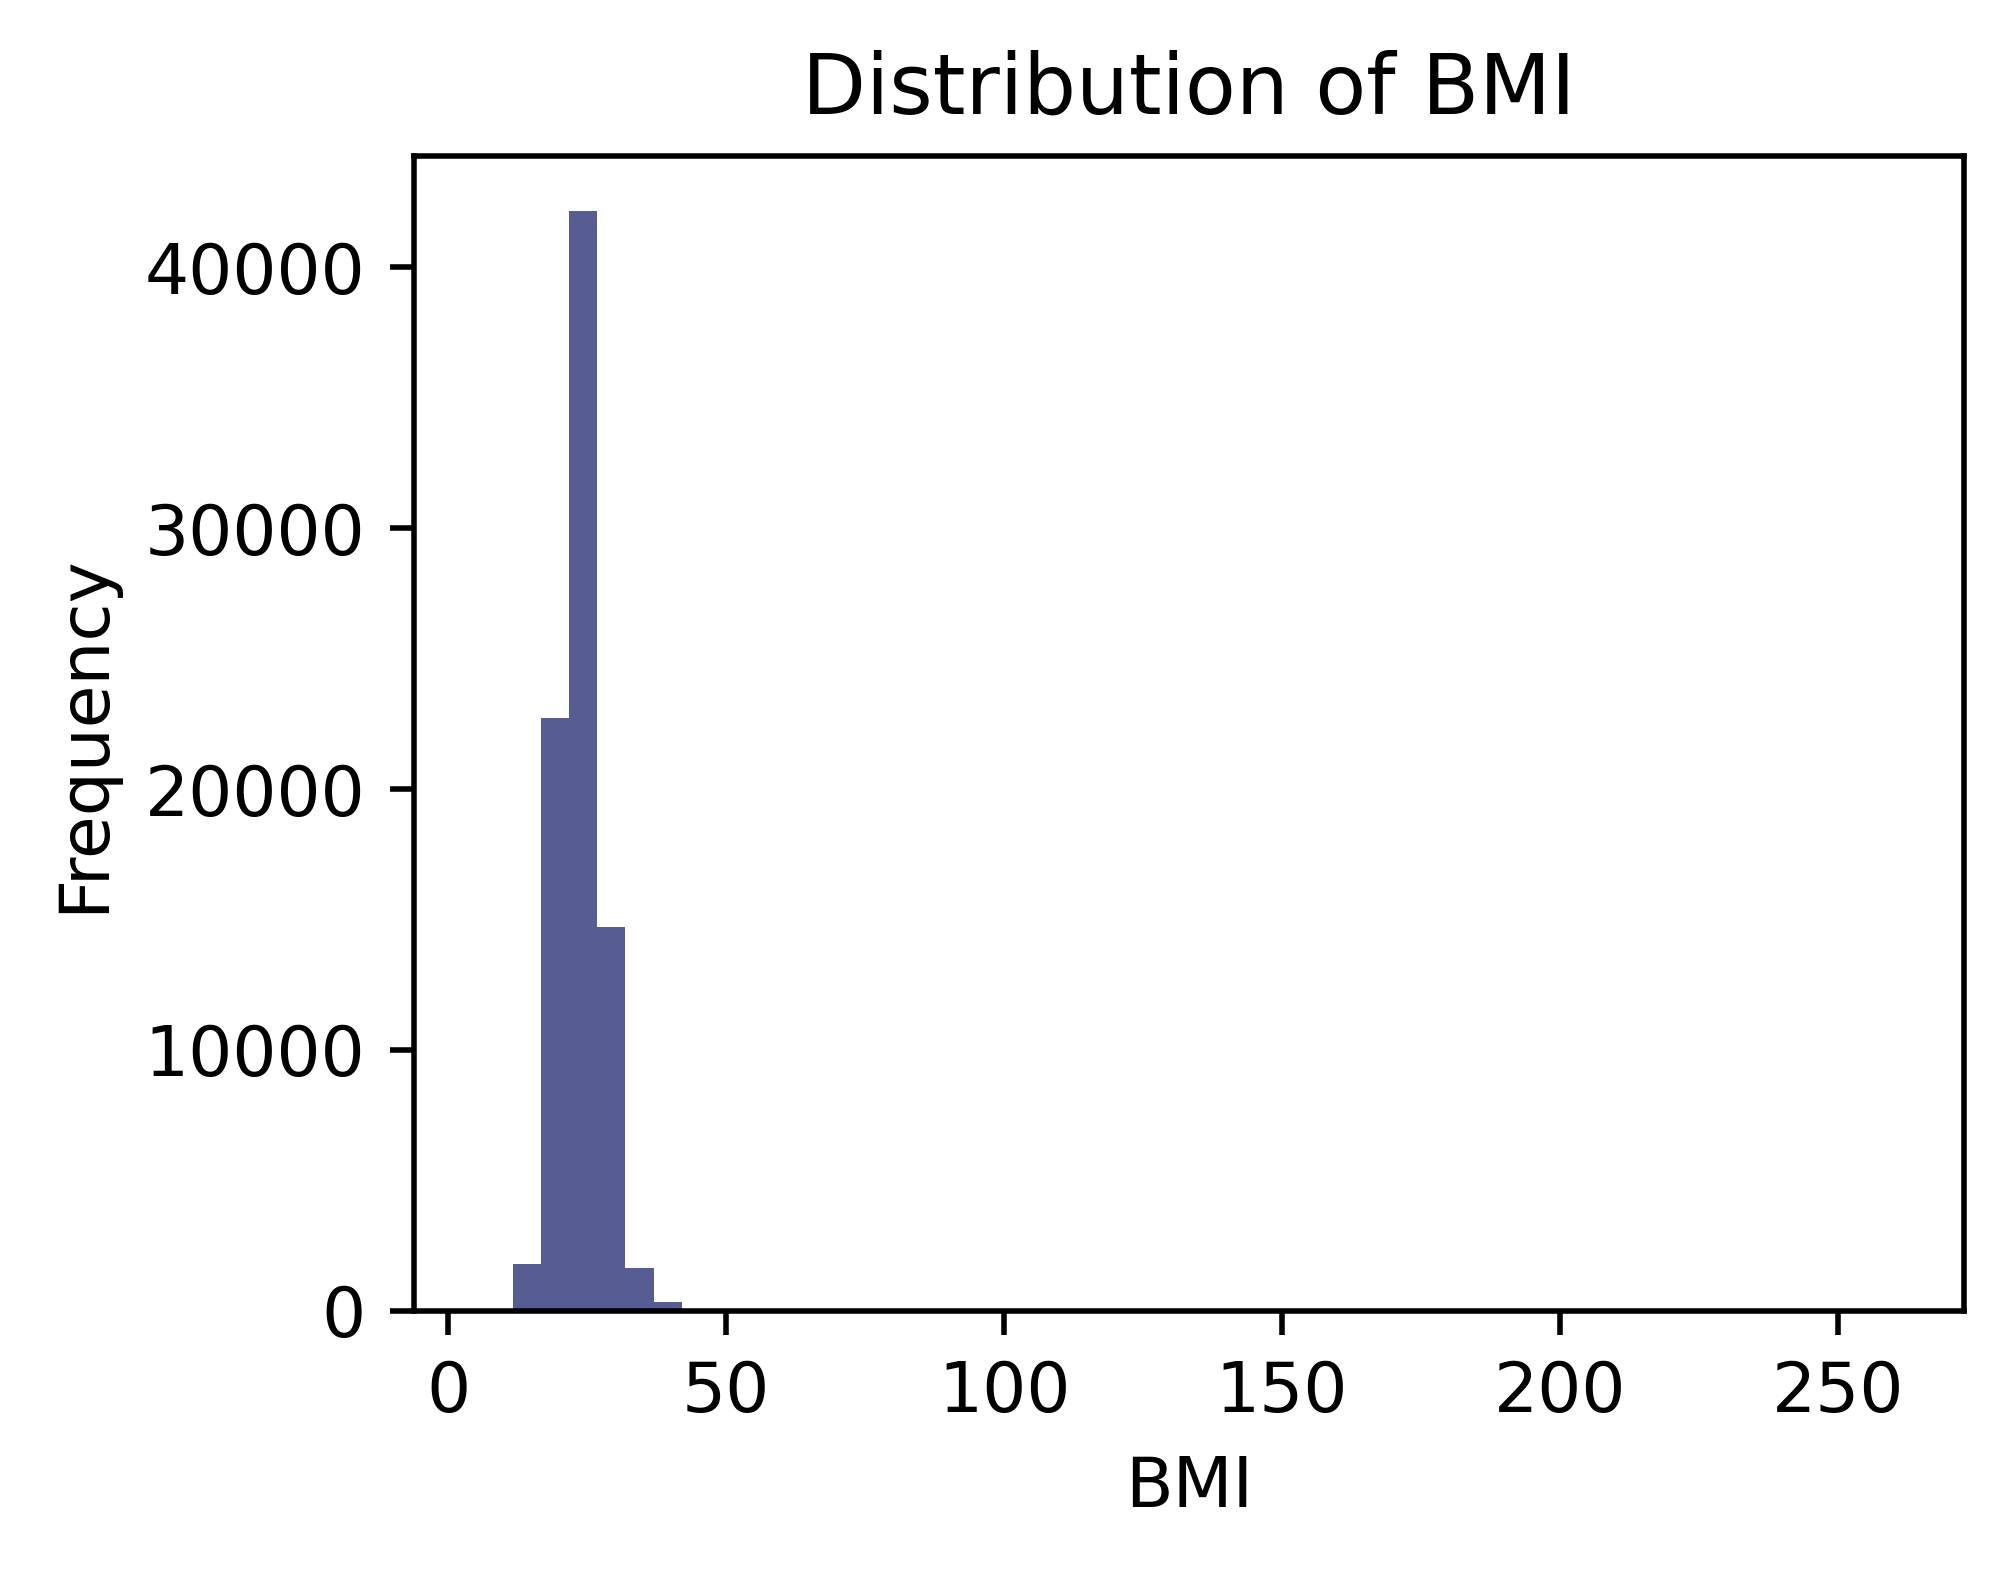

anesthesia_duration: min = 60.0, max = 1435.0 


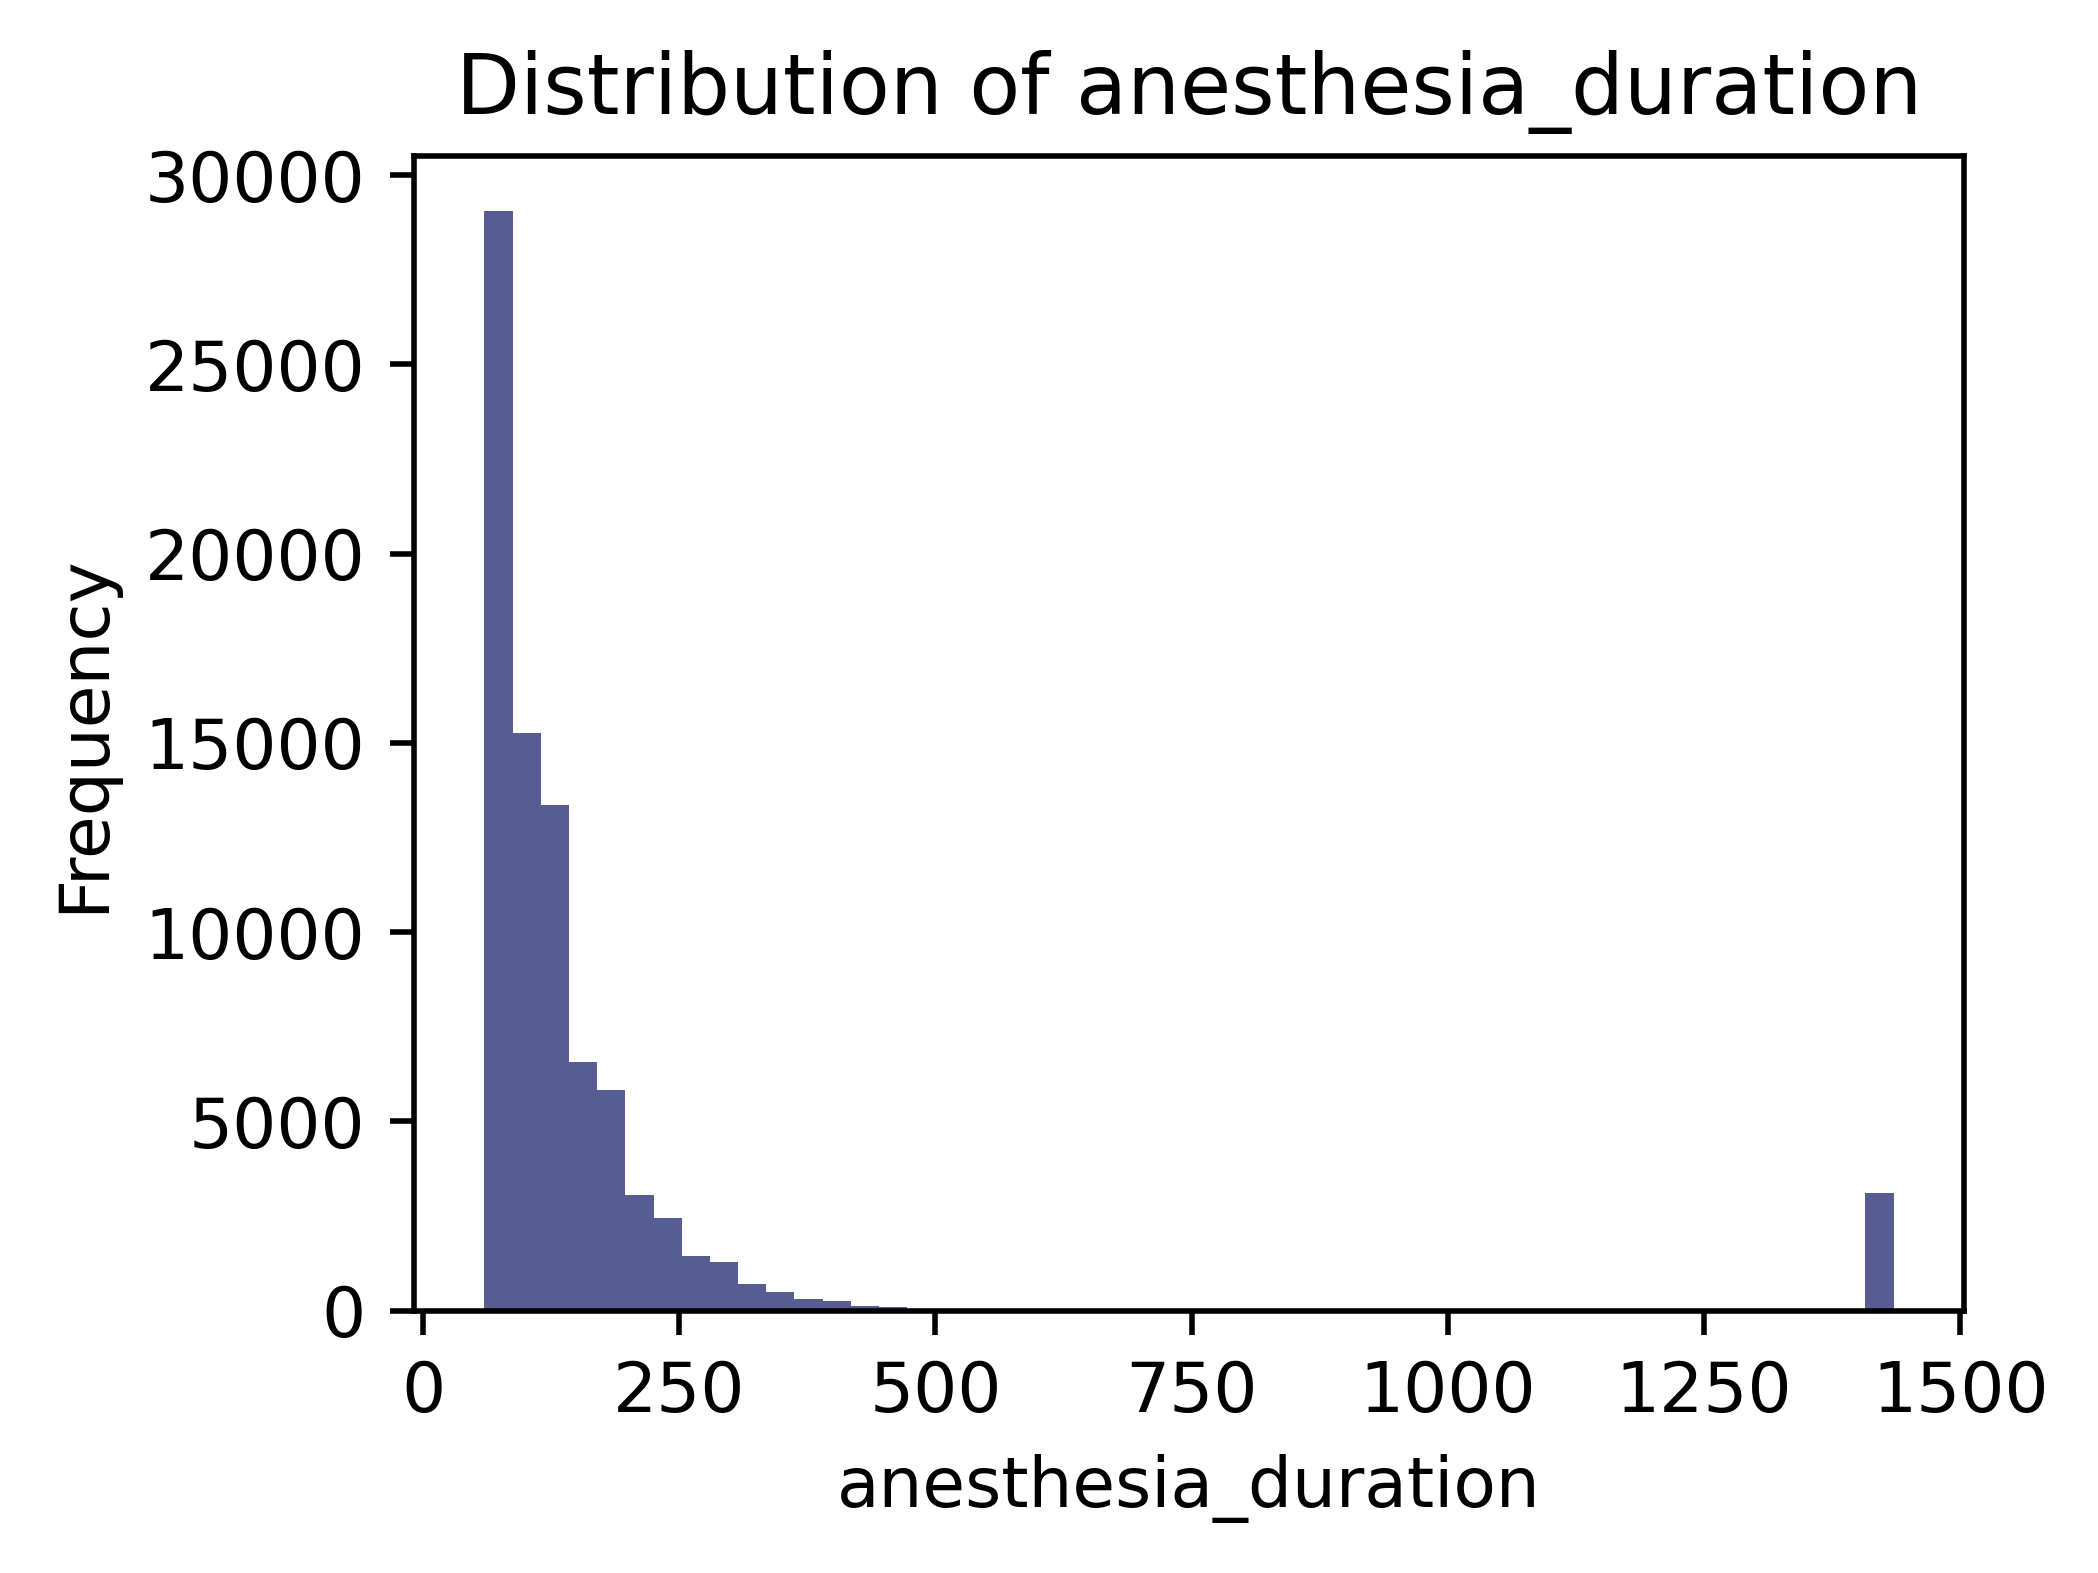

In [10]:
for feat in operations_sub.columns[2:]:
  print(f'{feat}: min = {np.min(operations_sub[feat])}, max = {np.max(operations_sub[feat])} ')
  plt.figure(figsize=(4,3), dpi=500)
  plt.hist(operations_sub[feat], bins=50, alpha=0.9, color=palette['INSPIRE'])
  plt.xlabel(feat)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {feat}')
  plt.show()

In [11]:
lab_features = ['albumin','glucose','ptinr','creatinine','wbc','hco3']
filtered_labs = labs[labs['item_name'].isin(lab_features)]

In [12]:
# Step 1: Merge the dataframes
merged_df = pd.merge(
    filtered_labs,
    operations_sub[['subject_id', 'anstart_time']],
    on='subject_id',
    how='inner'
)

# Step 2: Calculate time difference
# Convert to integers if not already
merged_df['chart_time_sec'] = merged_df['chart_time'].astype(int)
merged_df['anstart_time_sec'] = merged_df['anstart_time'].astype(int)

# Calculate seconds difference
# Simplified version of the time difference calculation -
# if you know times are in same format and don't need wraparound handling
merged_df['seconds_diff'] = merged_df['anstart_time_sec'] - merged_df['chart_time_sec']
merged_df['hours_diff'] = merged_df['seconds_diff'] / 3600

# Step 3: Keep only labs before surgery
pre_surgery_labs = merged_df[merged_df['hours_diff'] > 0]

# Step 4: Add a column to identify optimal labs for selection
pre_surgery_labs['meets_24h'] = pre_surgery_labs['hours_diff'] >= 24
pre_surgery_labs['distance_from_24h'] = abs(pre_surgery_labs['hours_diff'] - 24)

# Step 5: Sort by selection criteria for faster processing
# First by subject_id and item_name to group them
# Then by meets_24h (True first) to prioritize labs ≥ 24 hours
# Then by hours_diff ascending (for labs ≥ 24h) or distance_from_24h ascending (for labs < 24h)
pre_surgery_labs = pre_surgery_labs.sort_values(
    ['subject_id', 'item_name', 'meets_24h', 'distance_from_24h'],
    ascending=[True, True, False, True]
)

# Step 6: Keep the first lab for each subject_id and item_name after sorting
# This will be the optimal lab based on our criteria
selected_labs = pre_surgery_labs.drop_duplicates(['subject_id', 'item_name'])

# Step 7: Pivot the data to get item_names as columns
pivoted_labs = selected_labs.pivot(
    index='subject_id',
    columns='item_name',
    values='value'
)

# Step 8: Merge with operations_sub
operations_sub_with_labs = operations_sub.merge(
    pivoted_labs,
    on='subject_id',
    how='left'
)

# Print some diagnostic information
print(f"Final DataFrame shape: {operations_sub_with_labs.shape}")
print(f"Original operations_sub shape: {operations_sub.shape}")
print(f"Number of lab columns added: {pivoted_labs.shape[1]}")

/var/folders/nl/_hsnd4n10hz02hsrvnrw30080000gn/T/ipykernel_63258/2984647863.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_surgery_labs['meets_24h'] = pre_surgery_labs['hours_diff'] >= 24
/var/folders/nl/_hsnd4n10hz02hsrvnrw30080000gn/T/ipykernel_63258/2984647863.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_surgery_labs['distance_from_24h'] = abs(pre_surgery_labs['hours_diff'] - 24)


Final DataFrame shape: (83580, 18)
Original operations_sub shape: (83580, 12)
Number of lab columns added: 6


age: min = 20, max = 90 


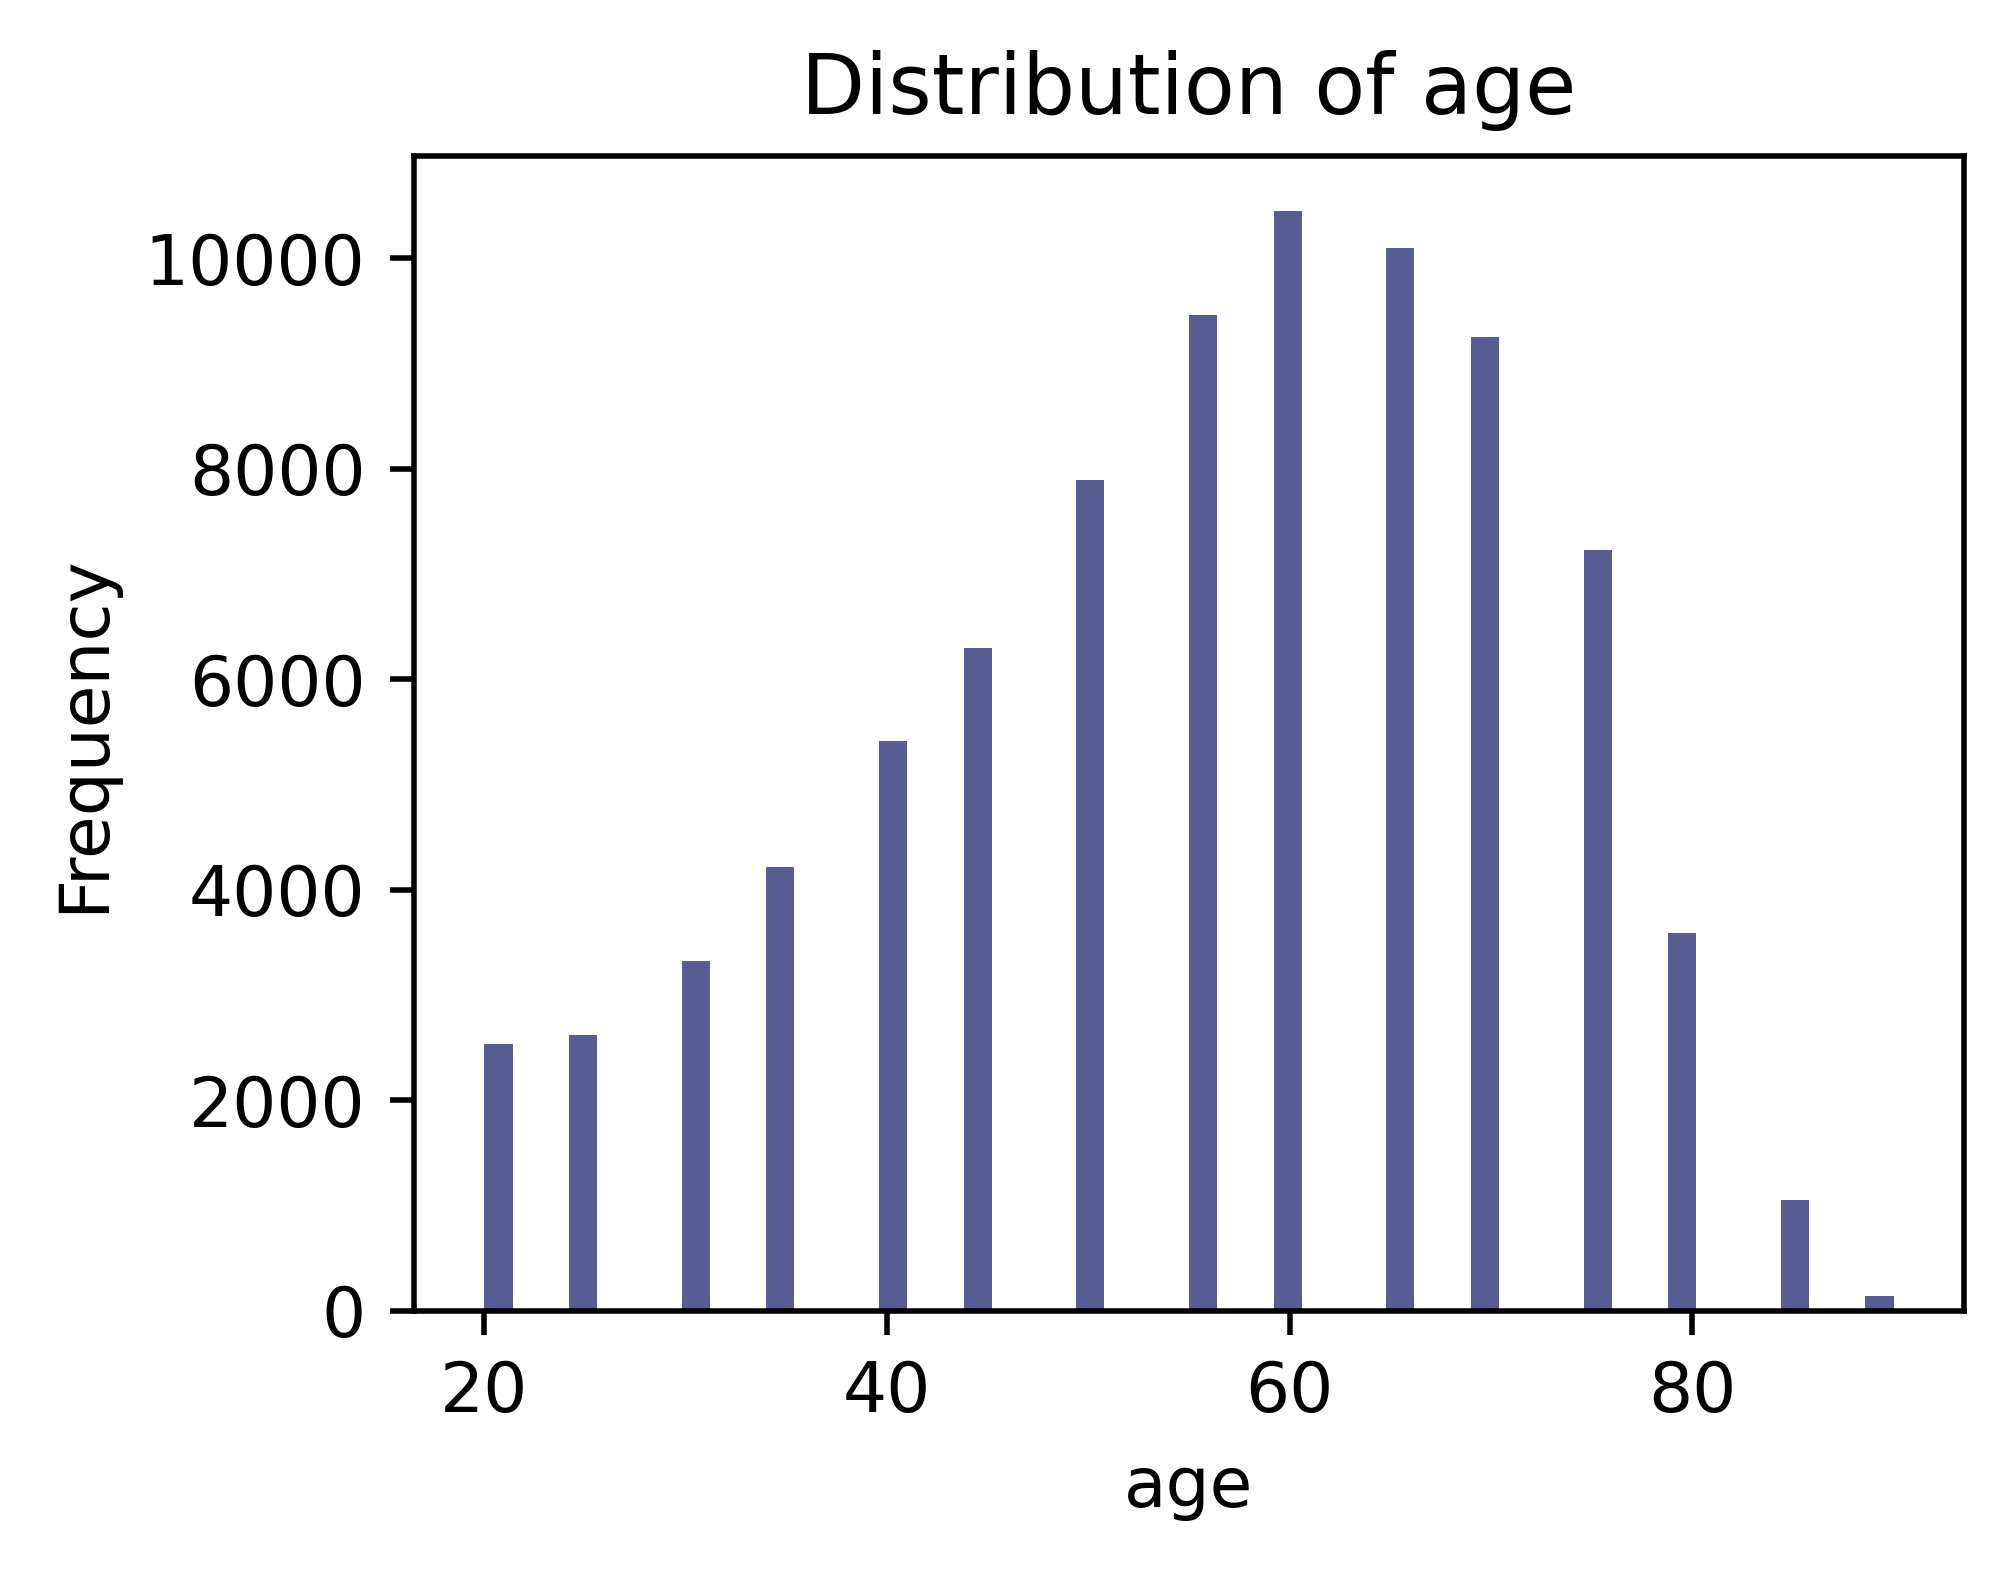

height: min = 50.0, max = 200.0 


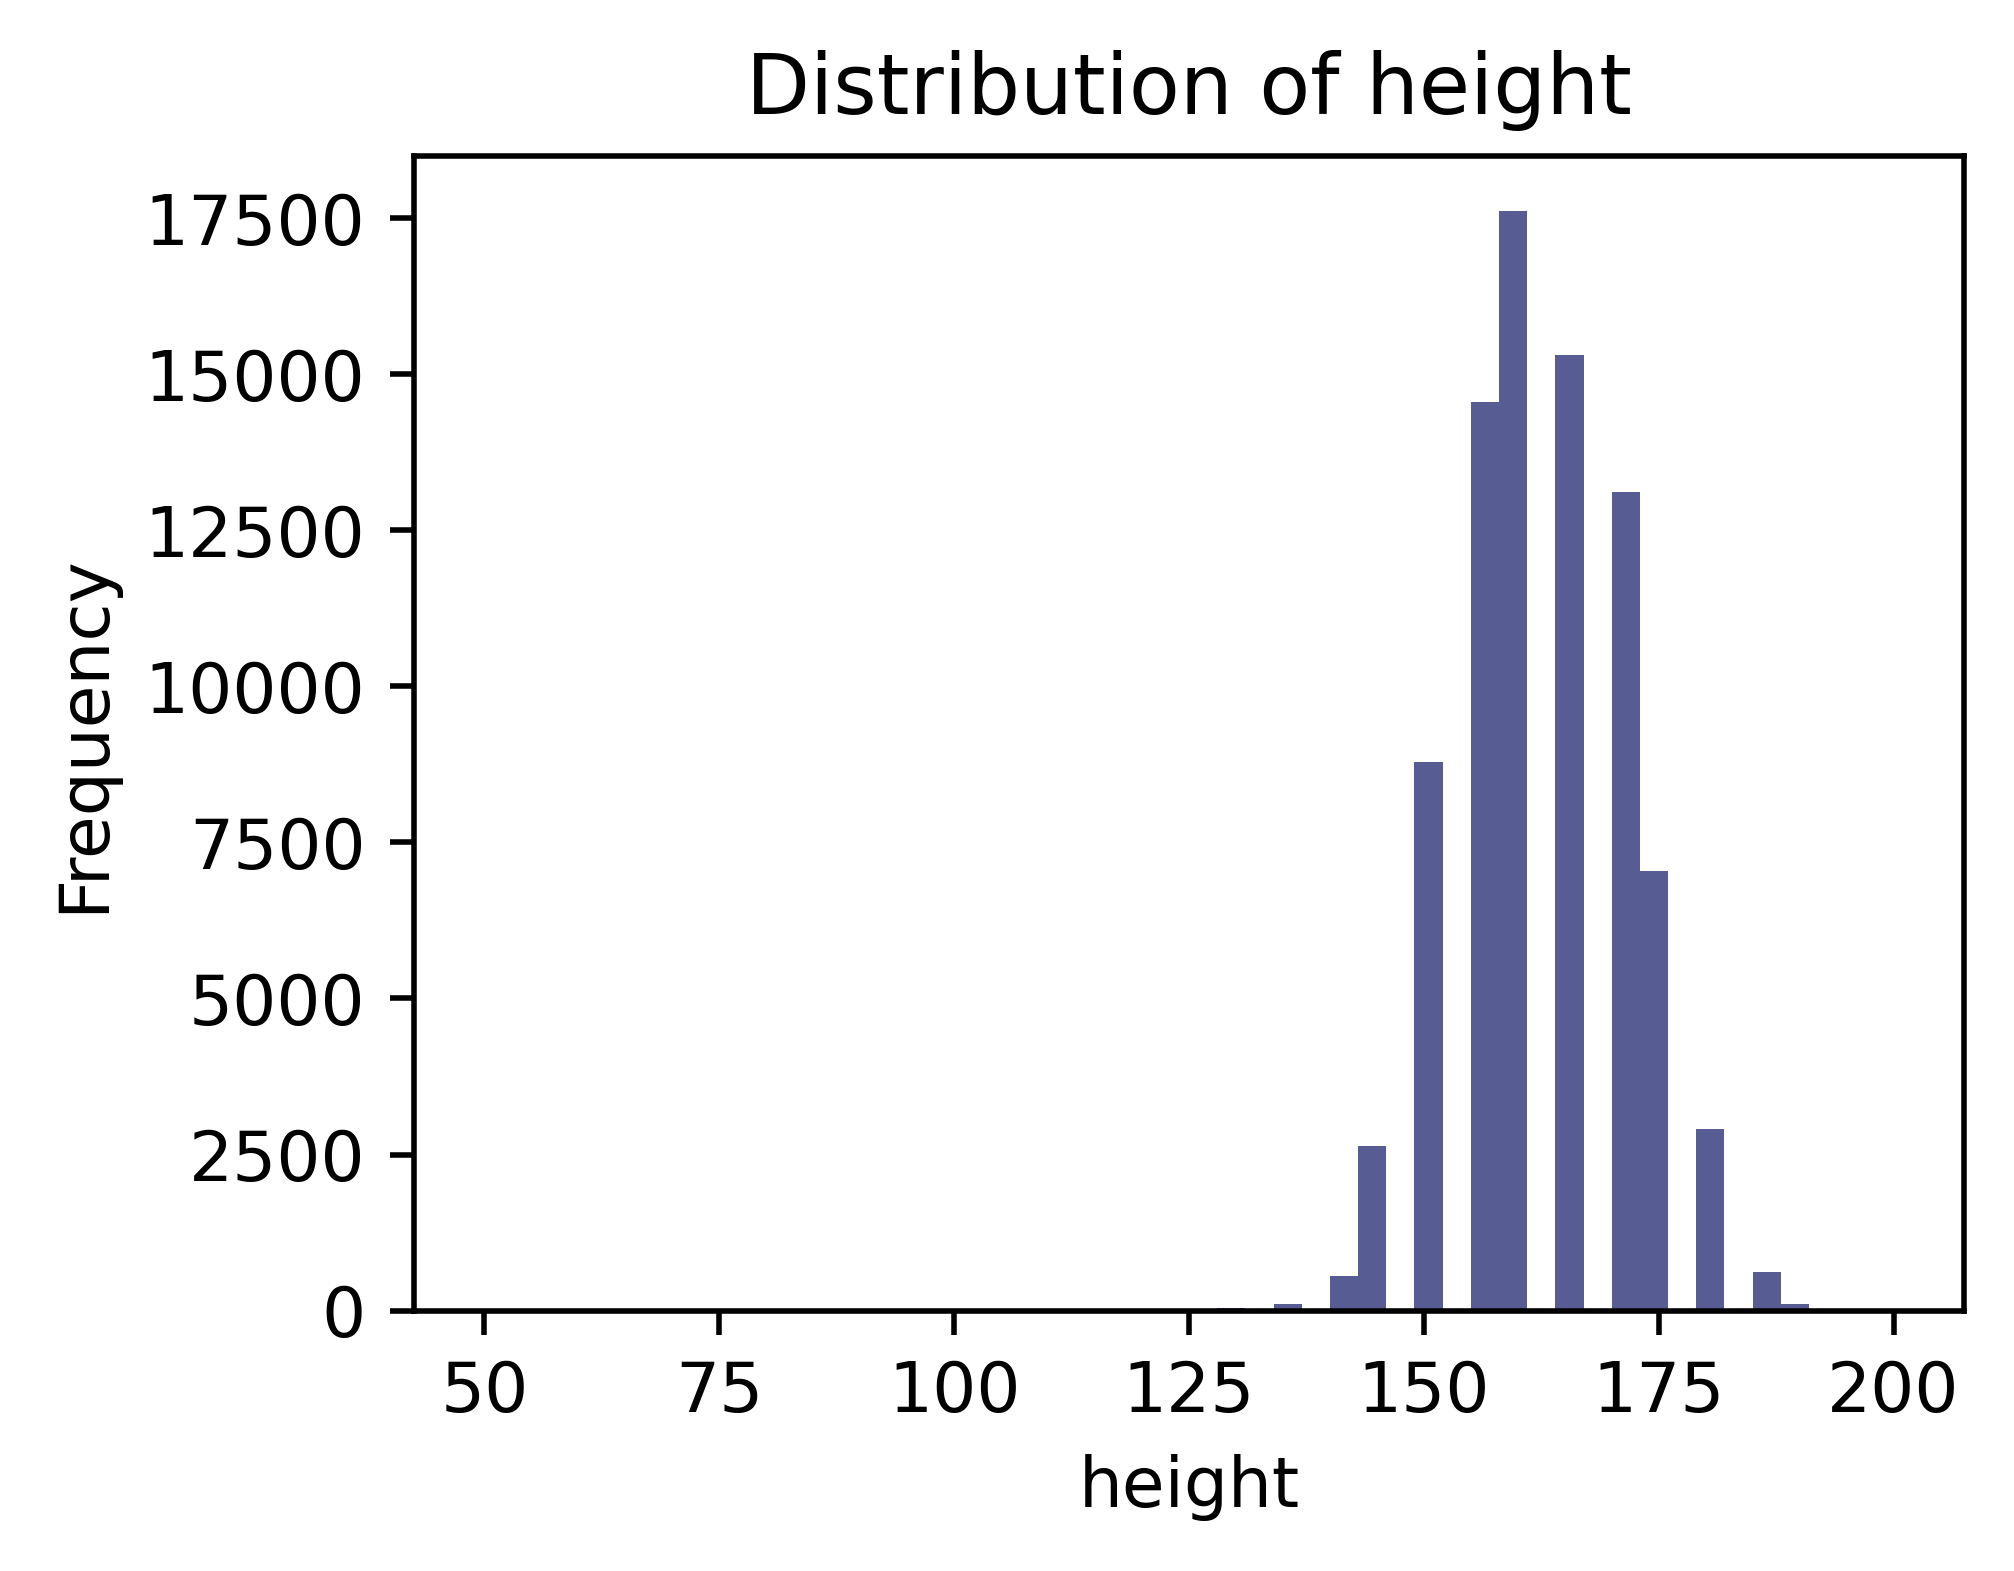

weight: min = 20.0, max = 180.0 


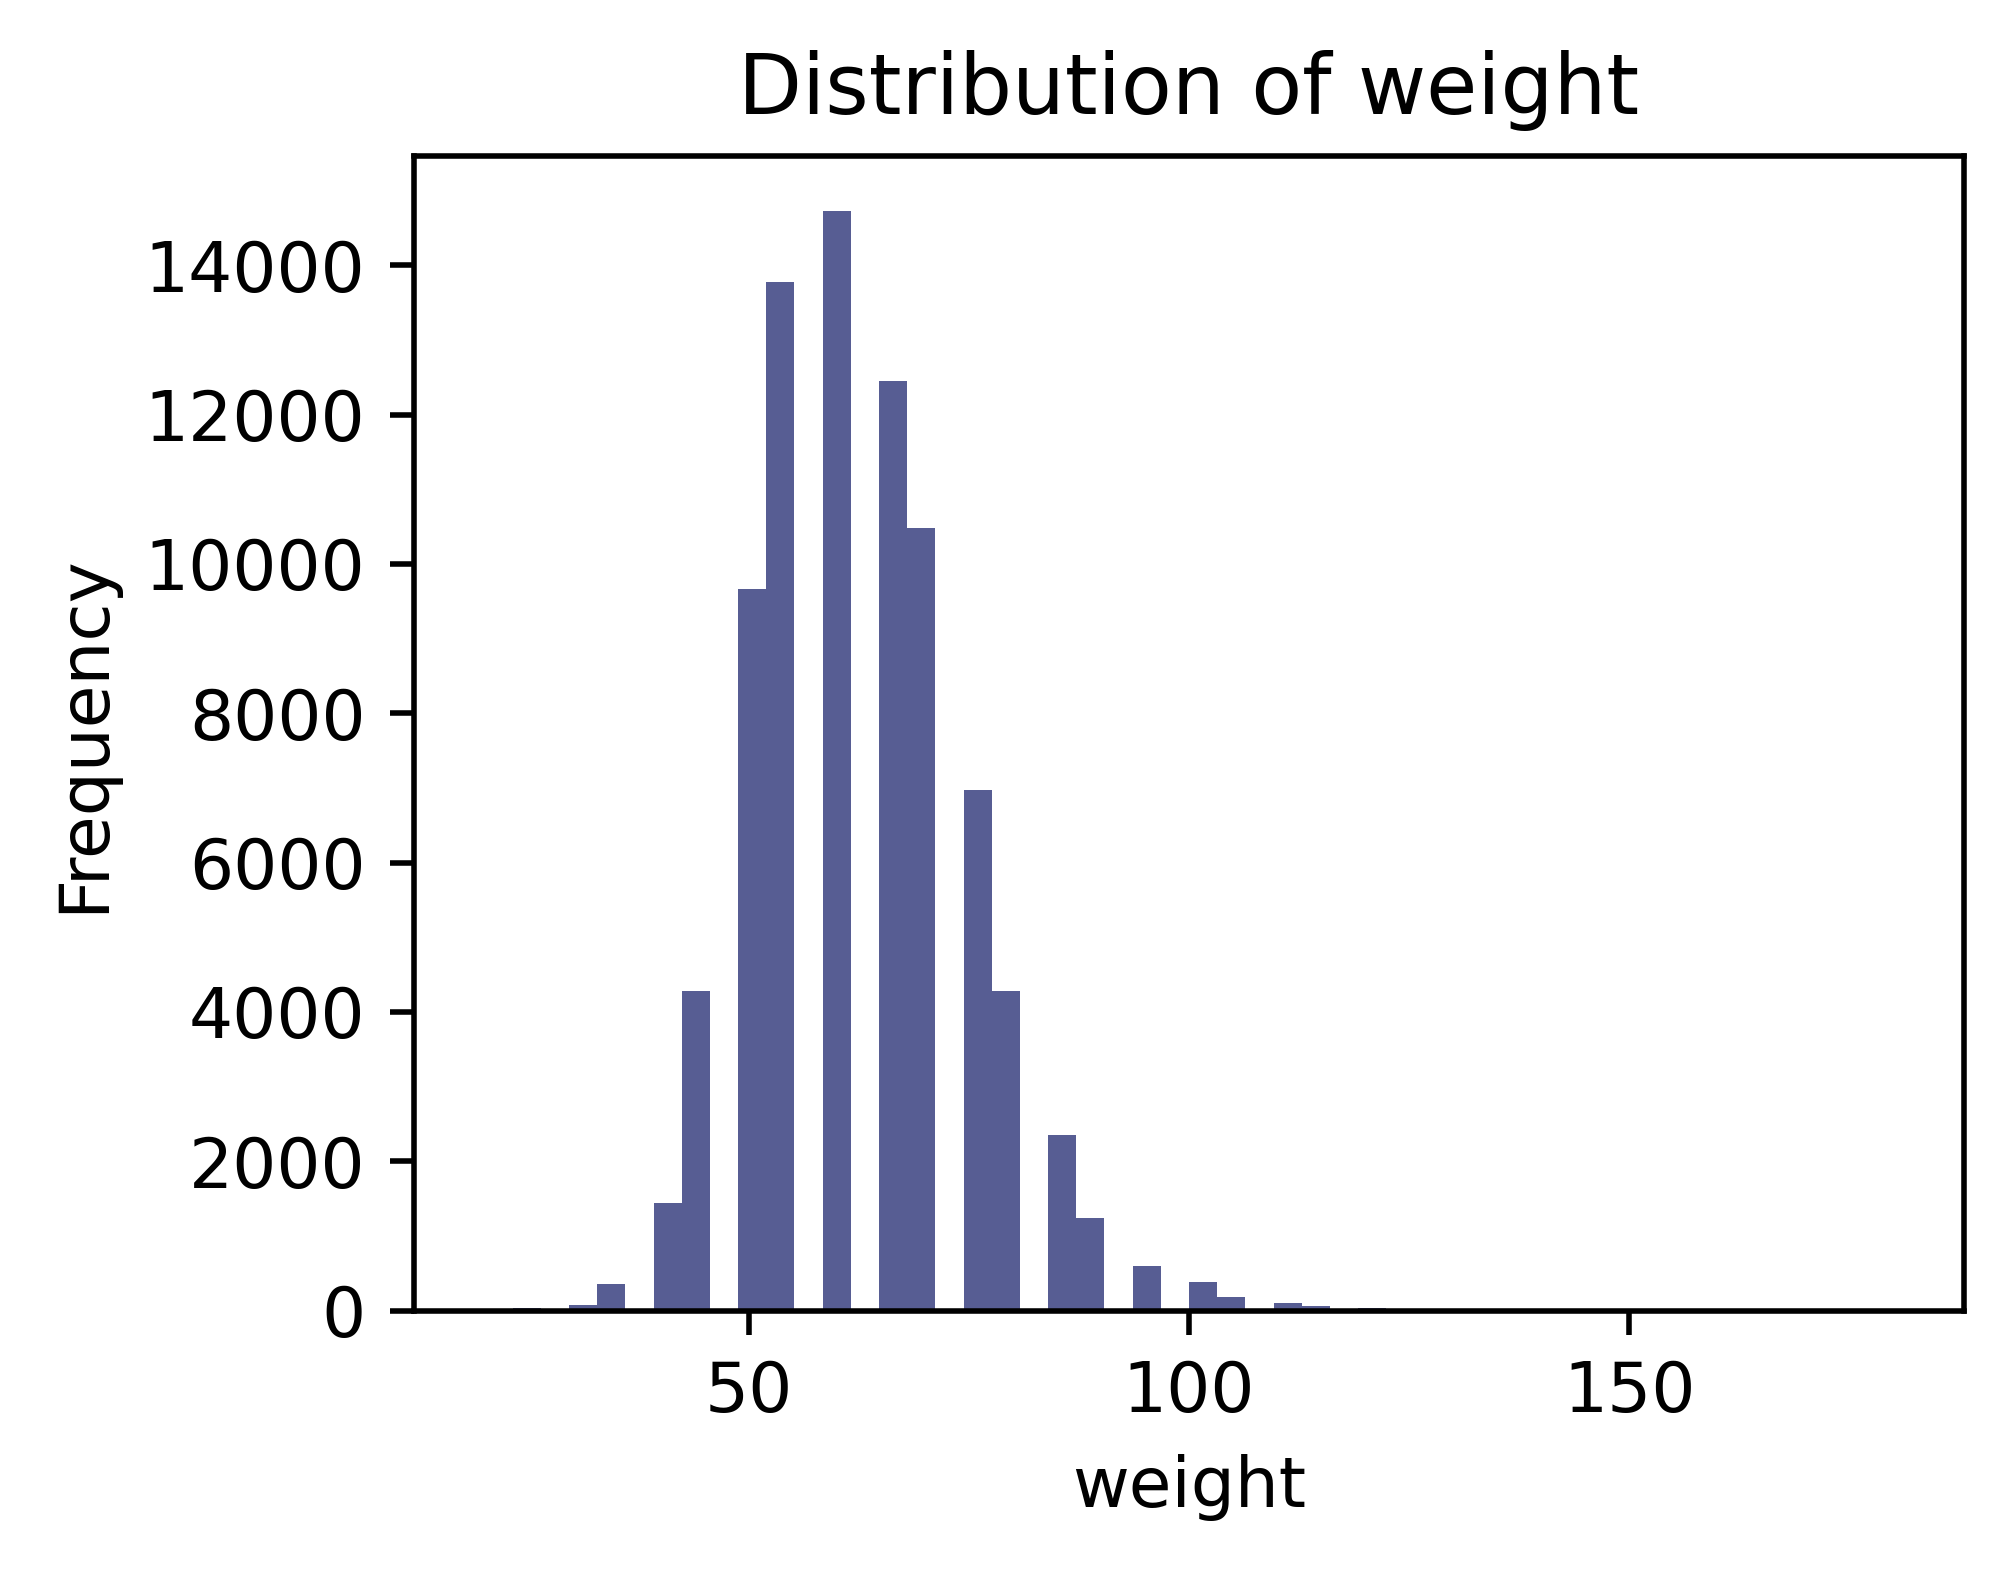

anstart_time: min = -10.0, max = 5185070.0 


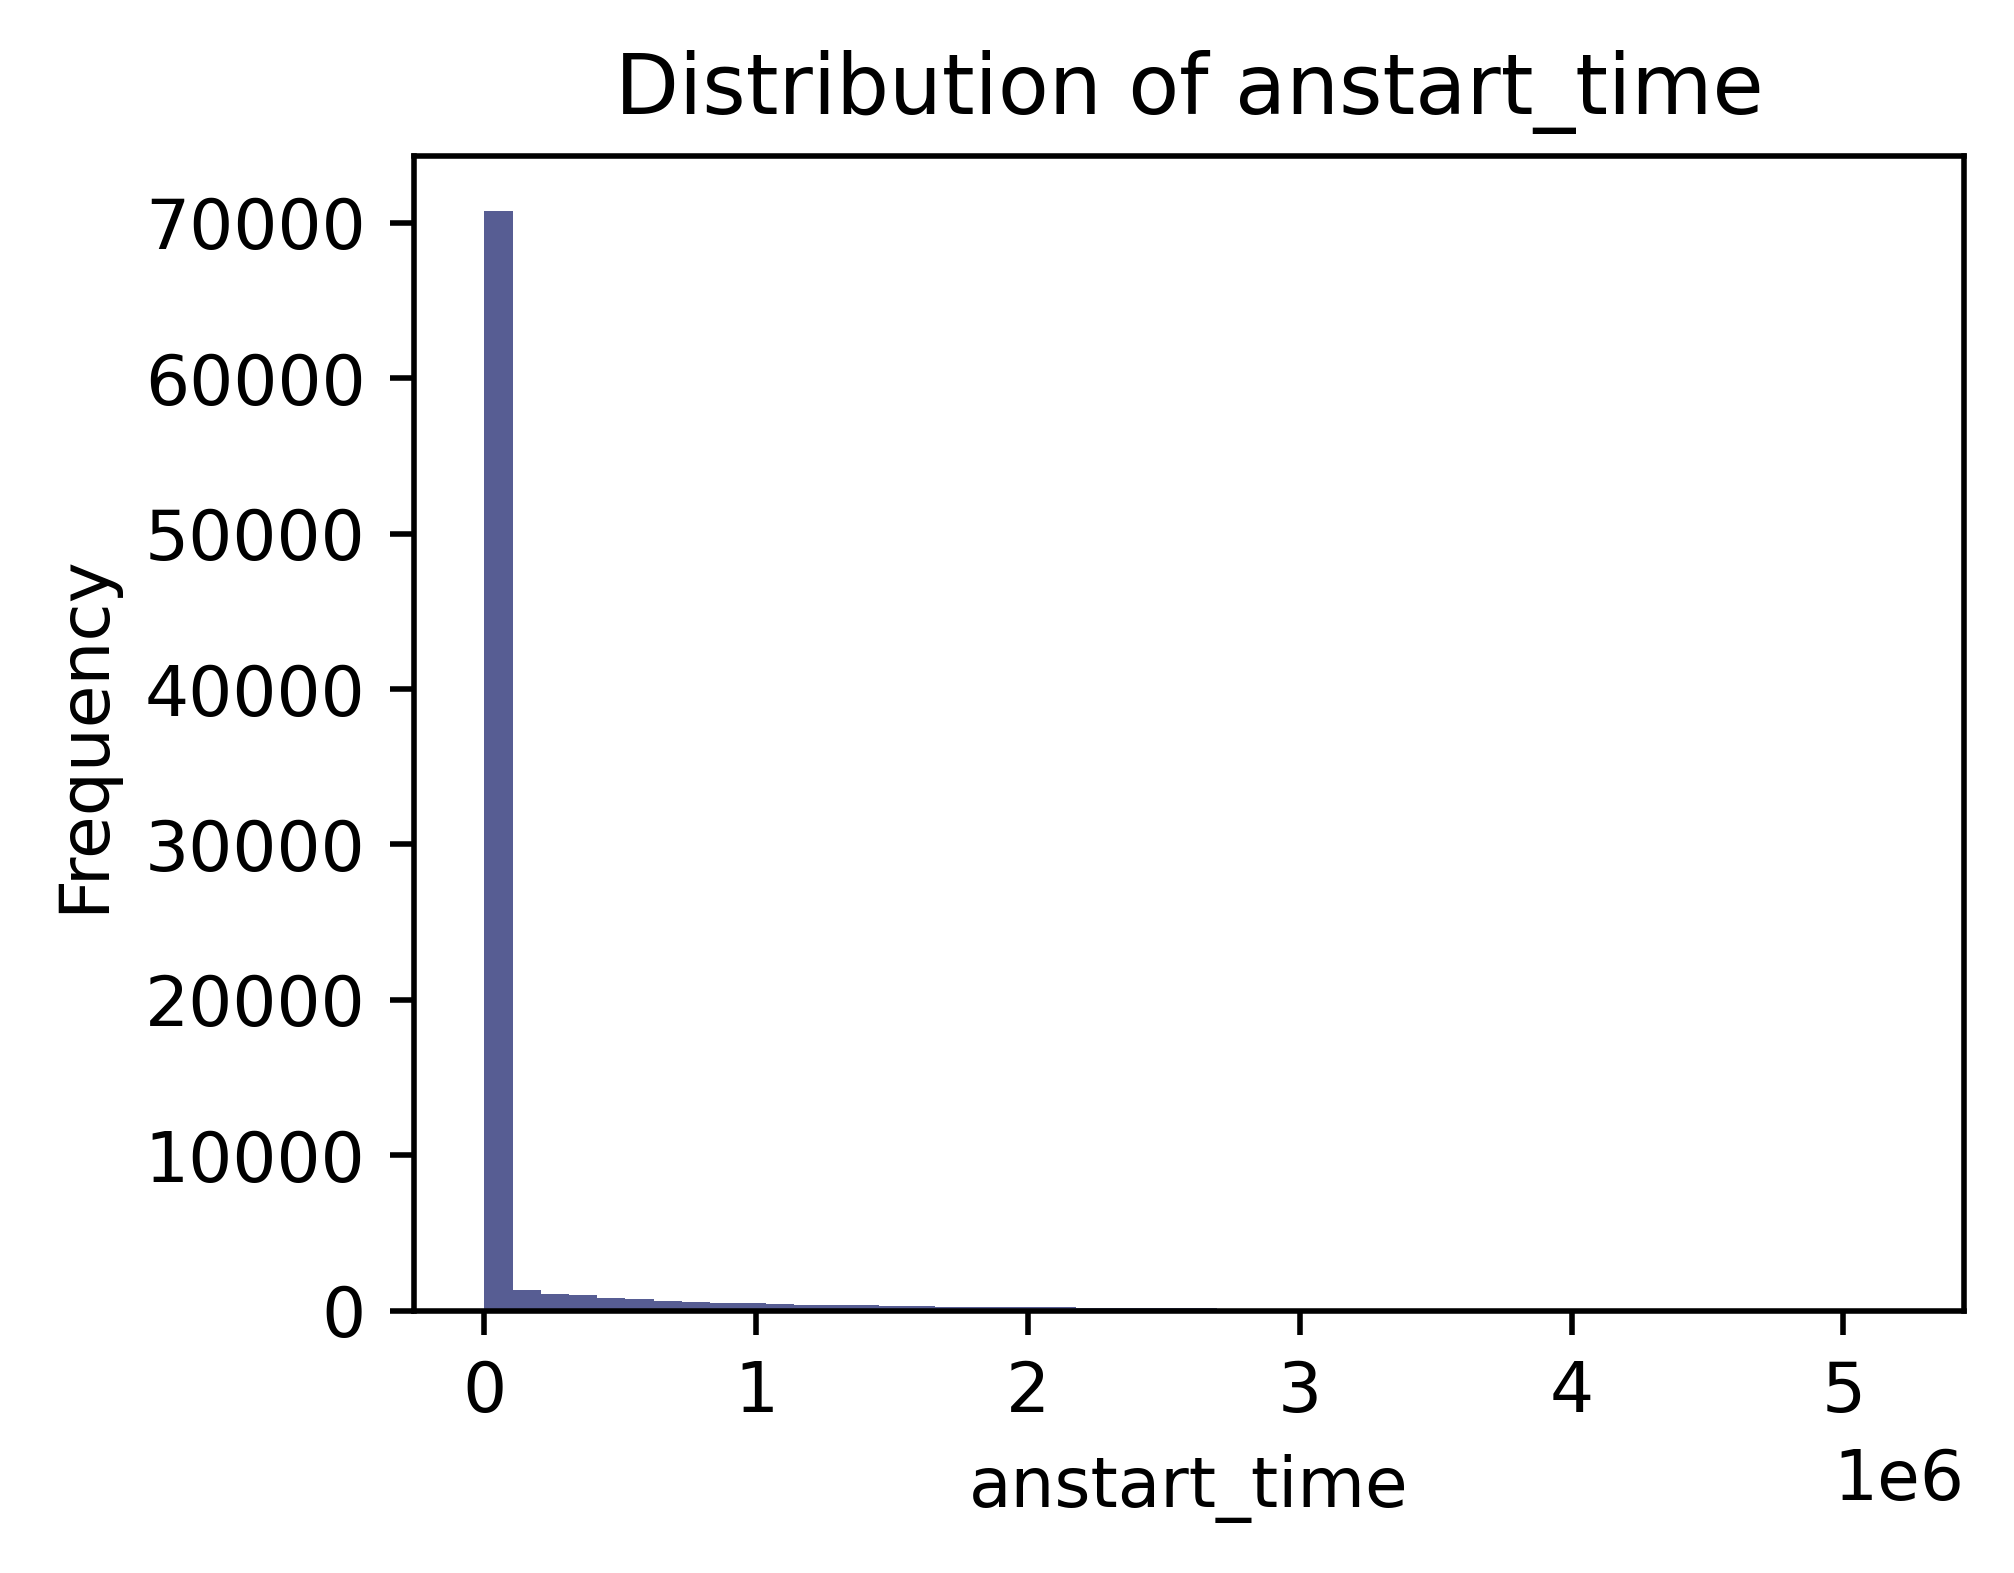

anend_time: min = 90.0, max = 5185170.0 


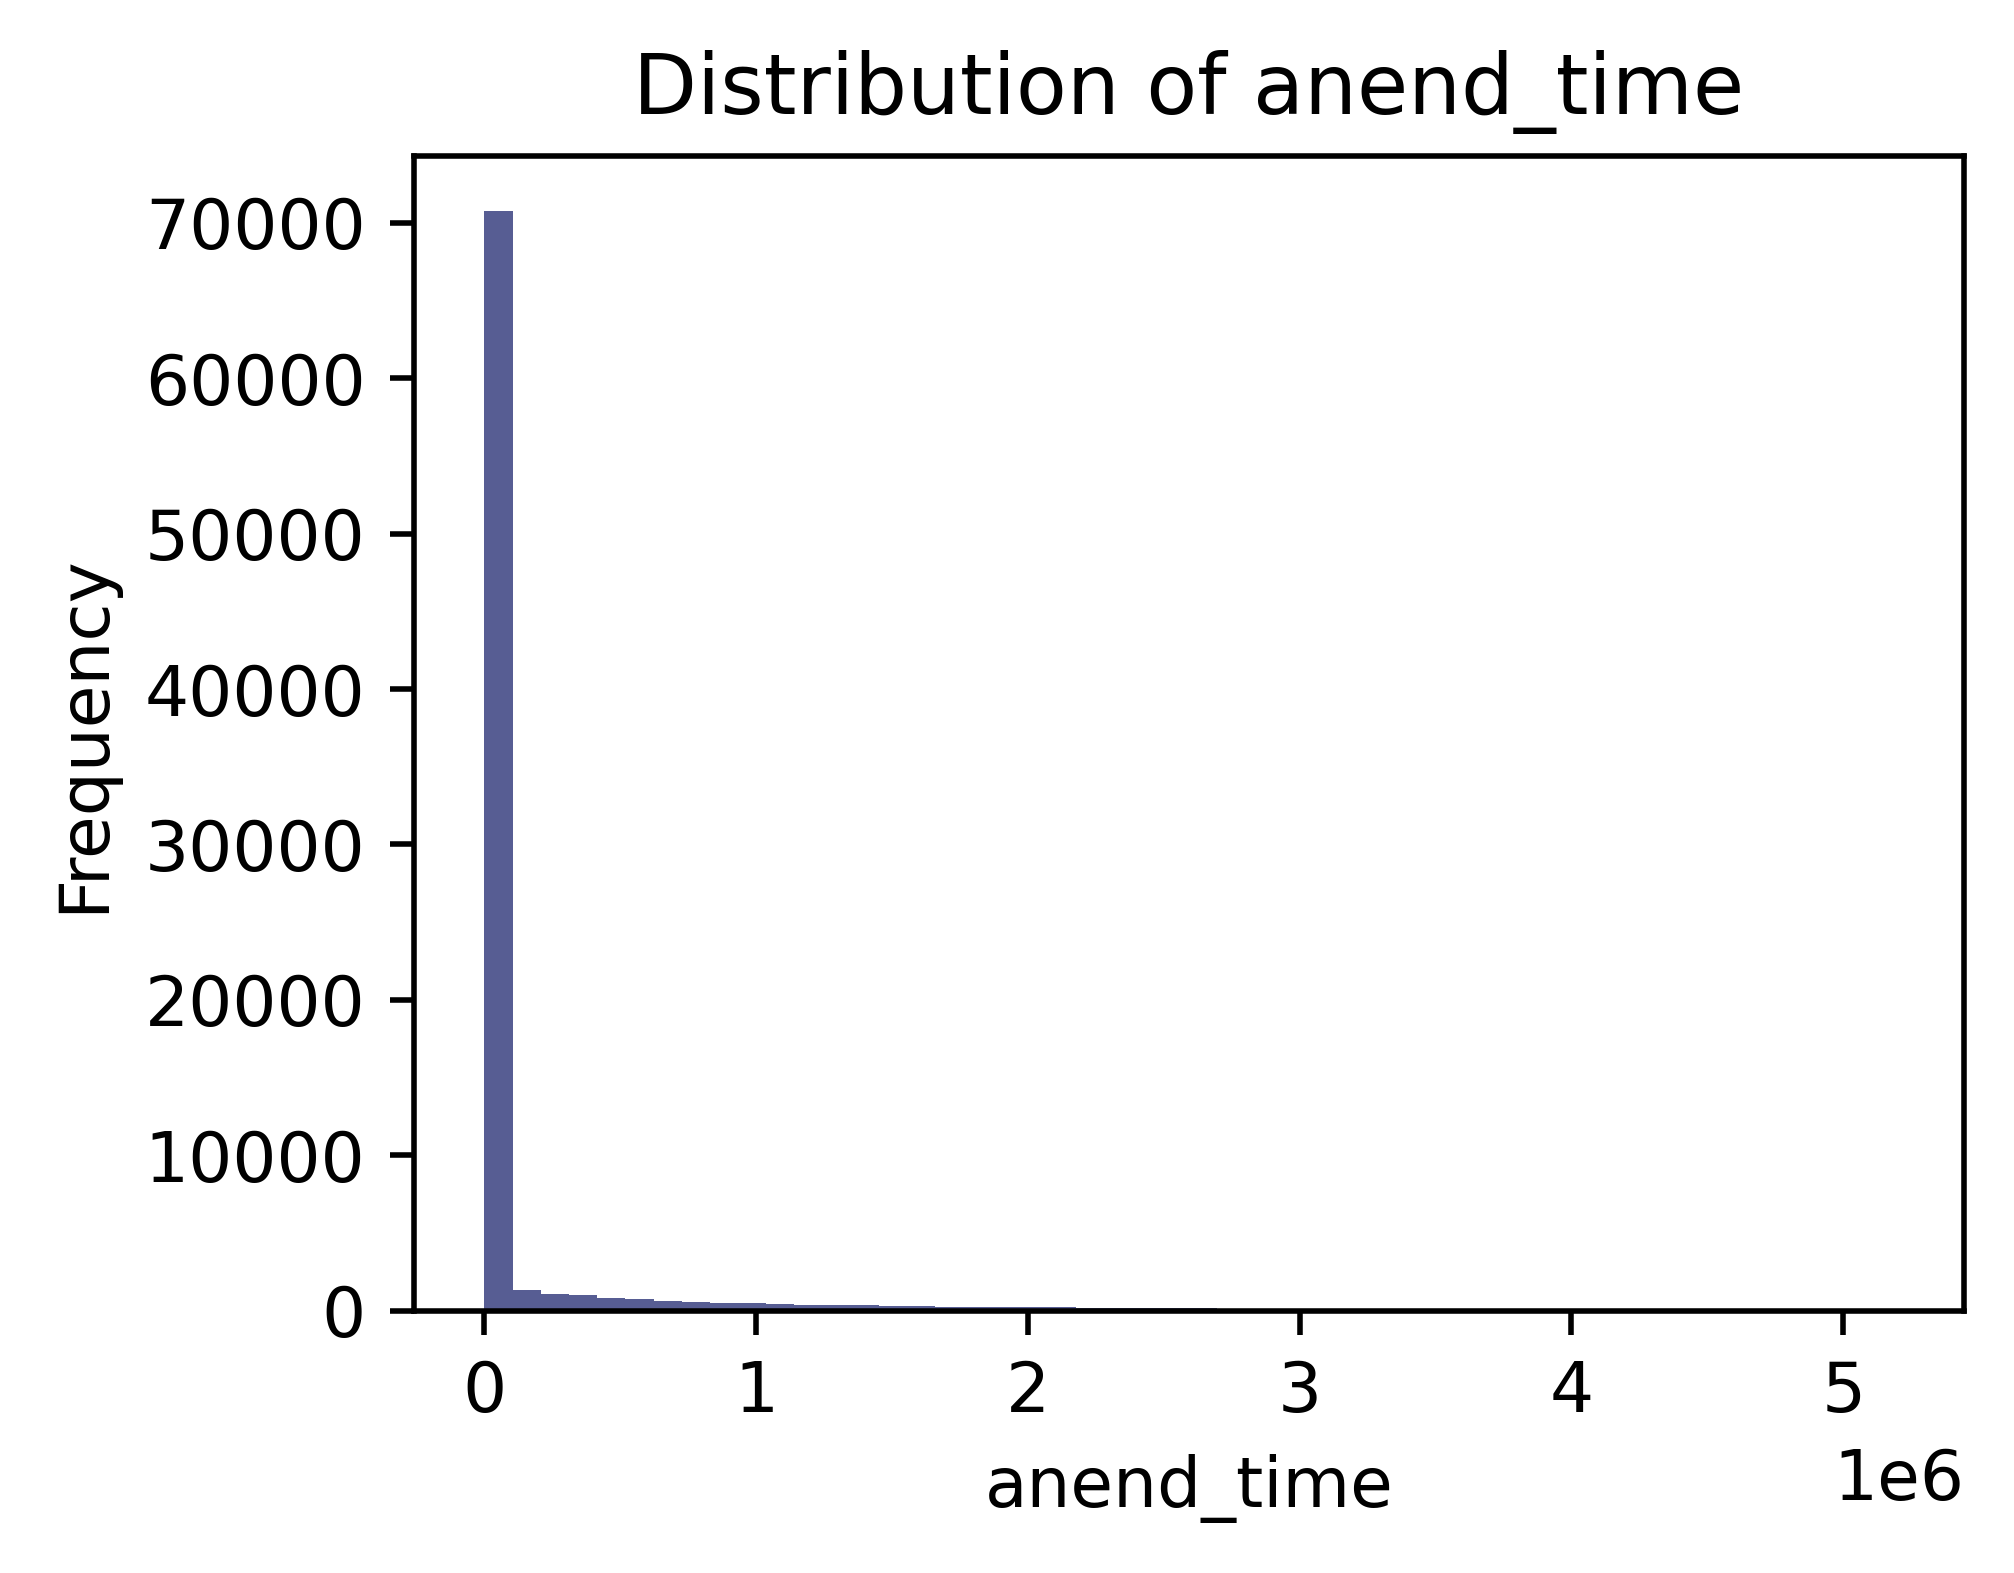

icd10_pcs: min = 00100, max = 10D00 


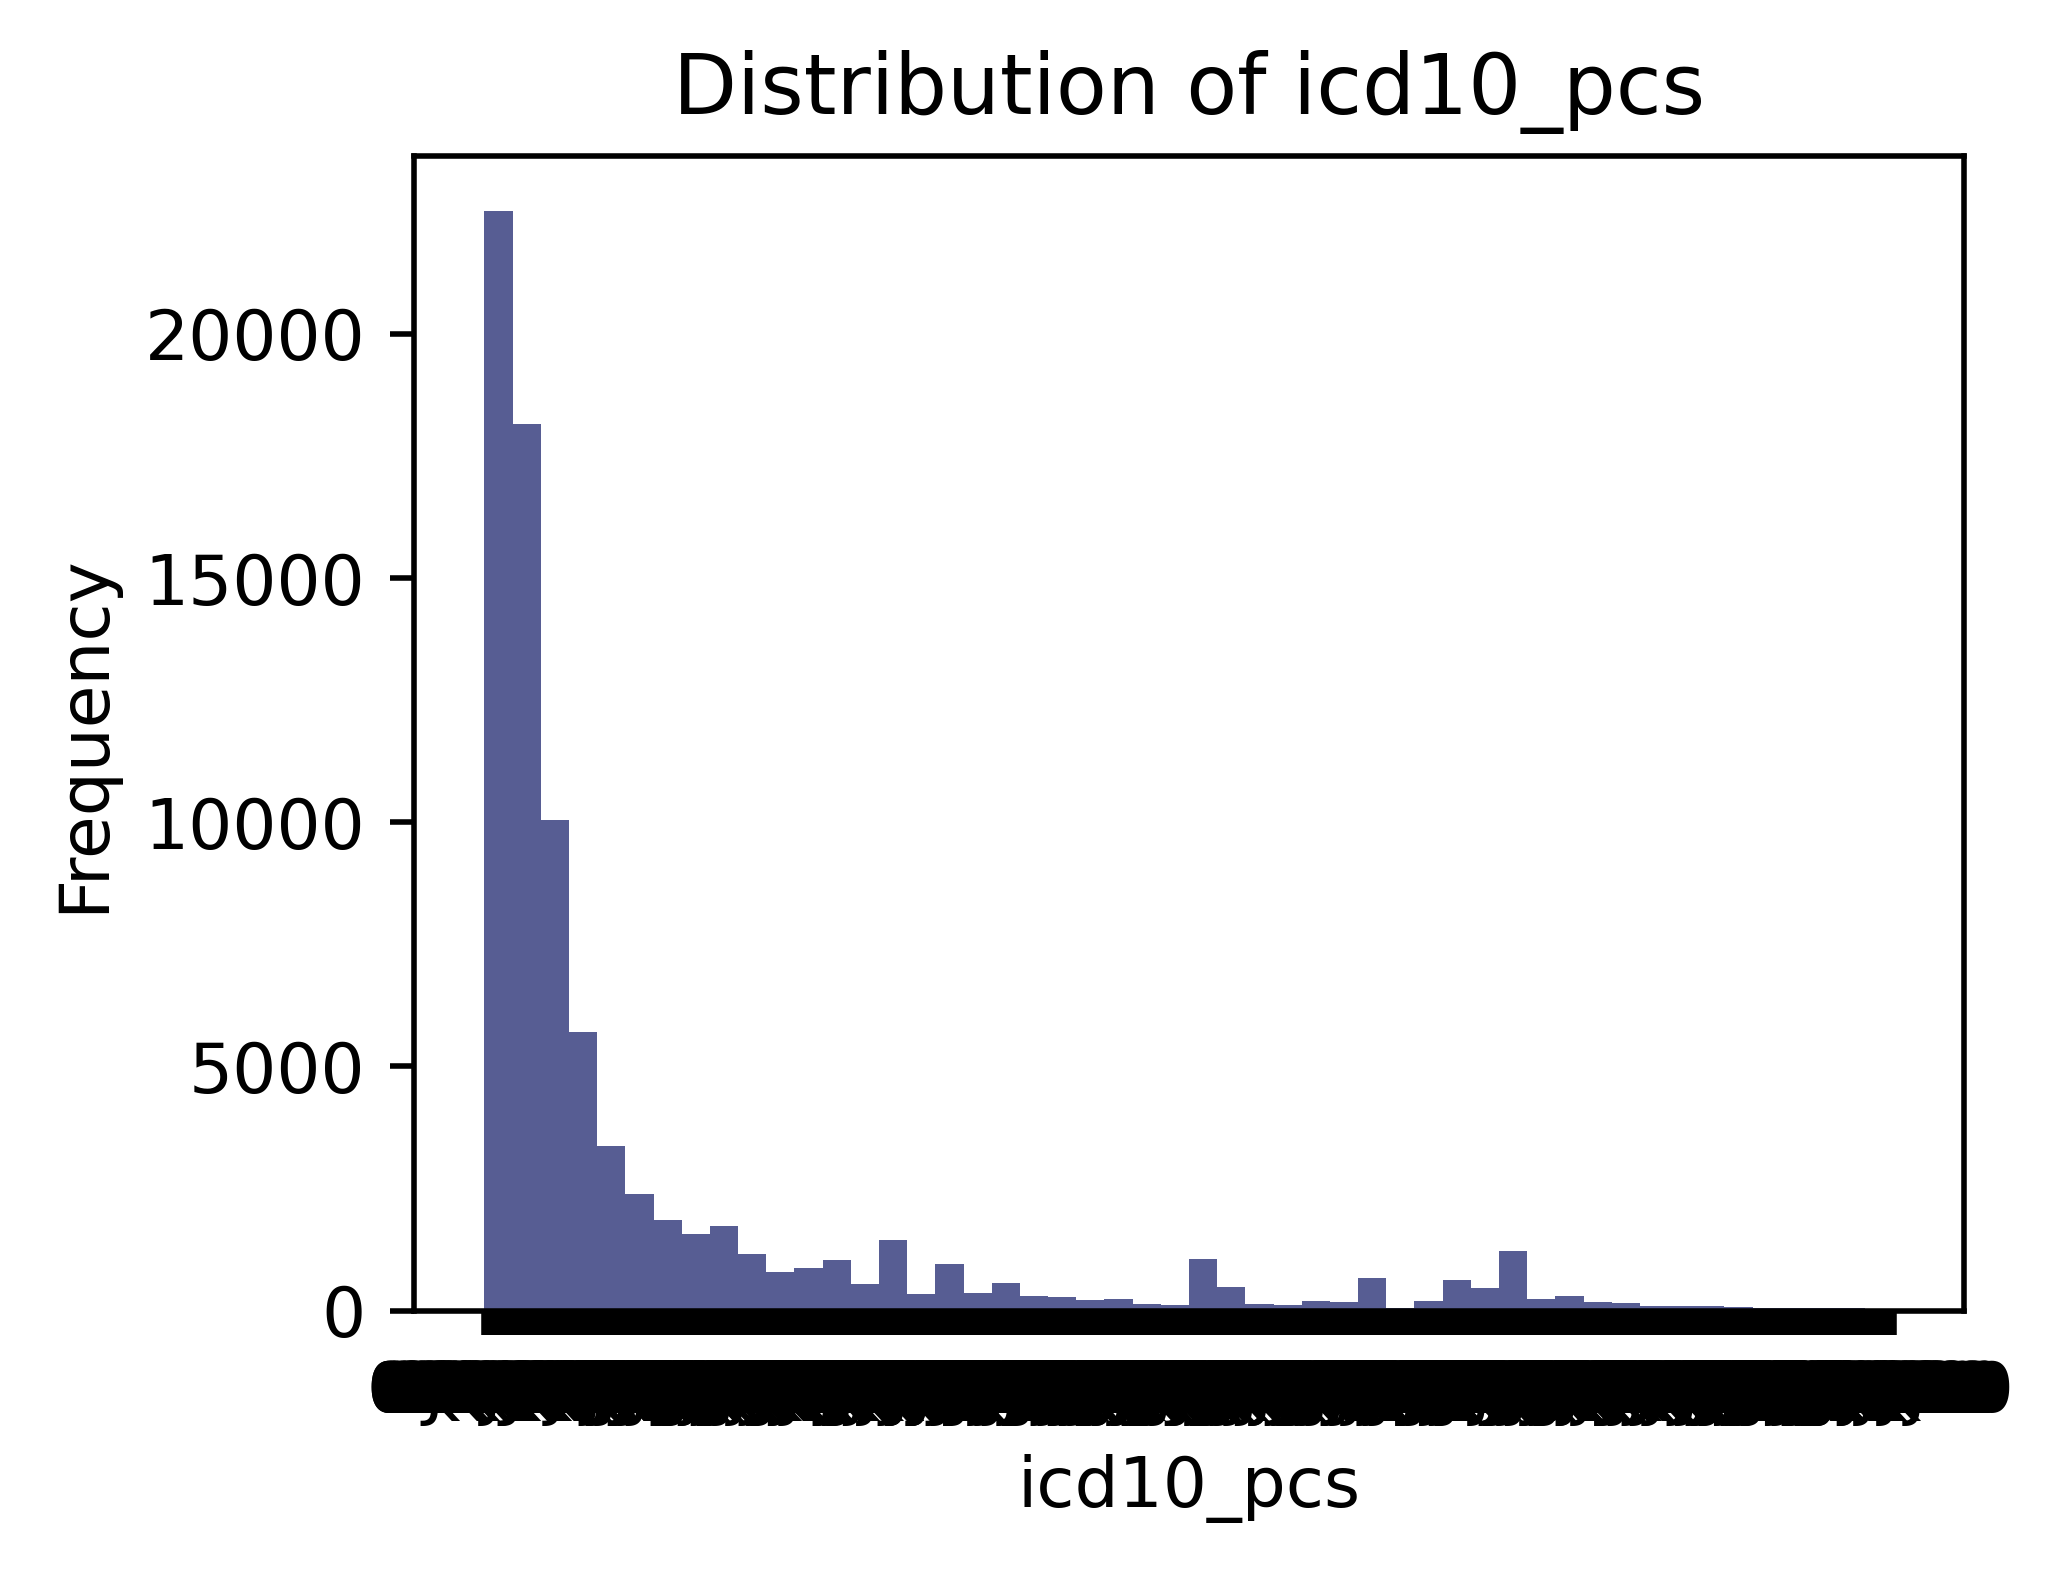

antype: min = General, max = Regional 


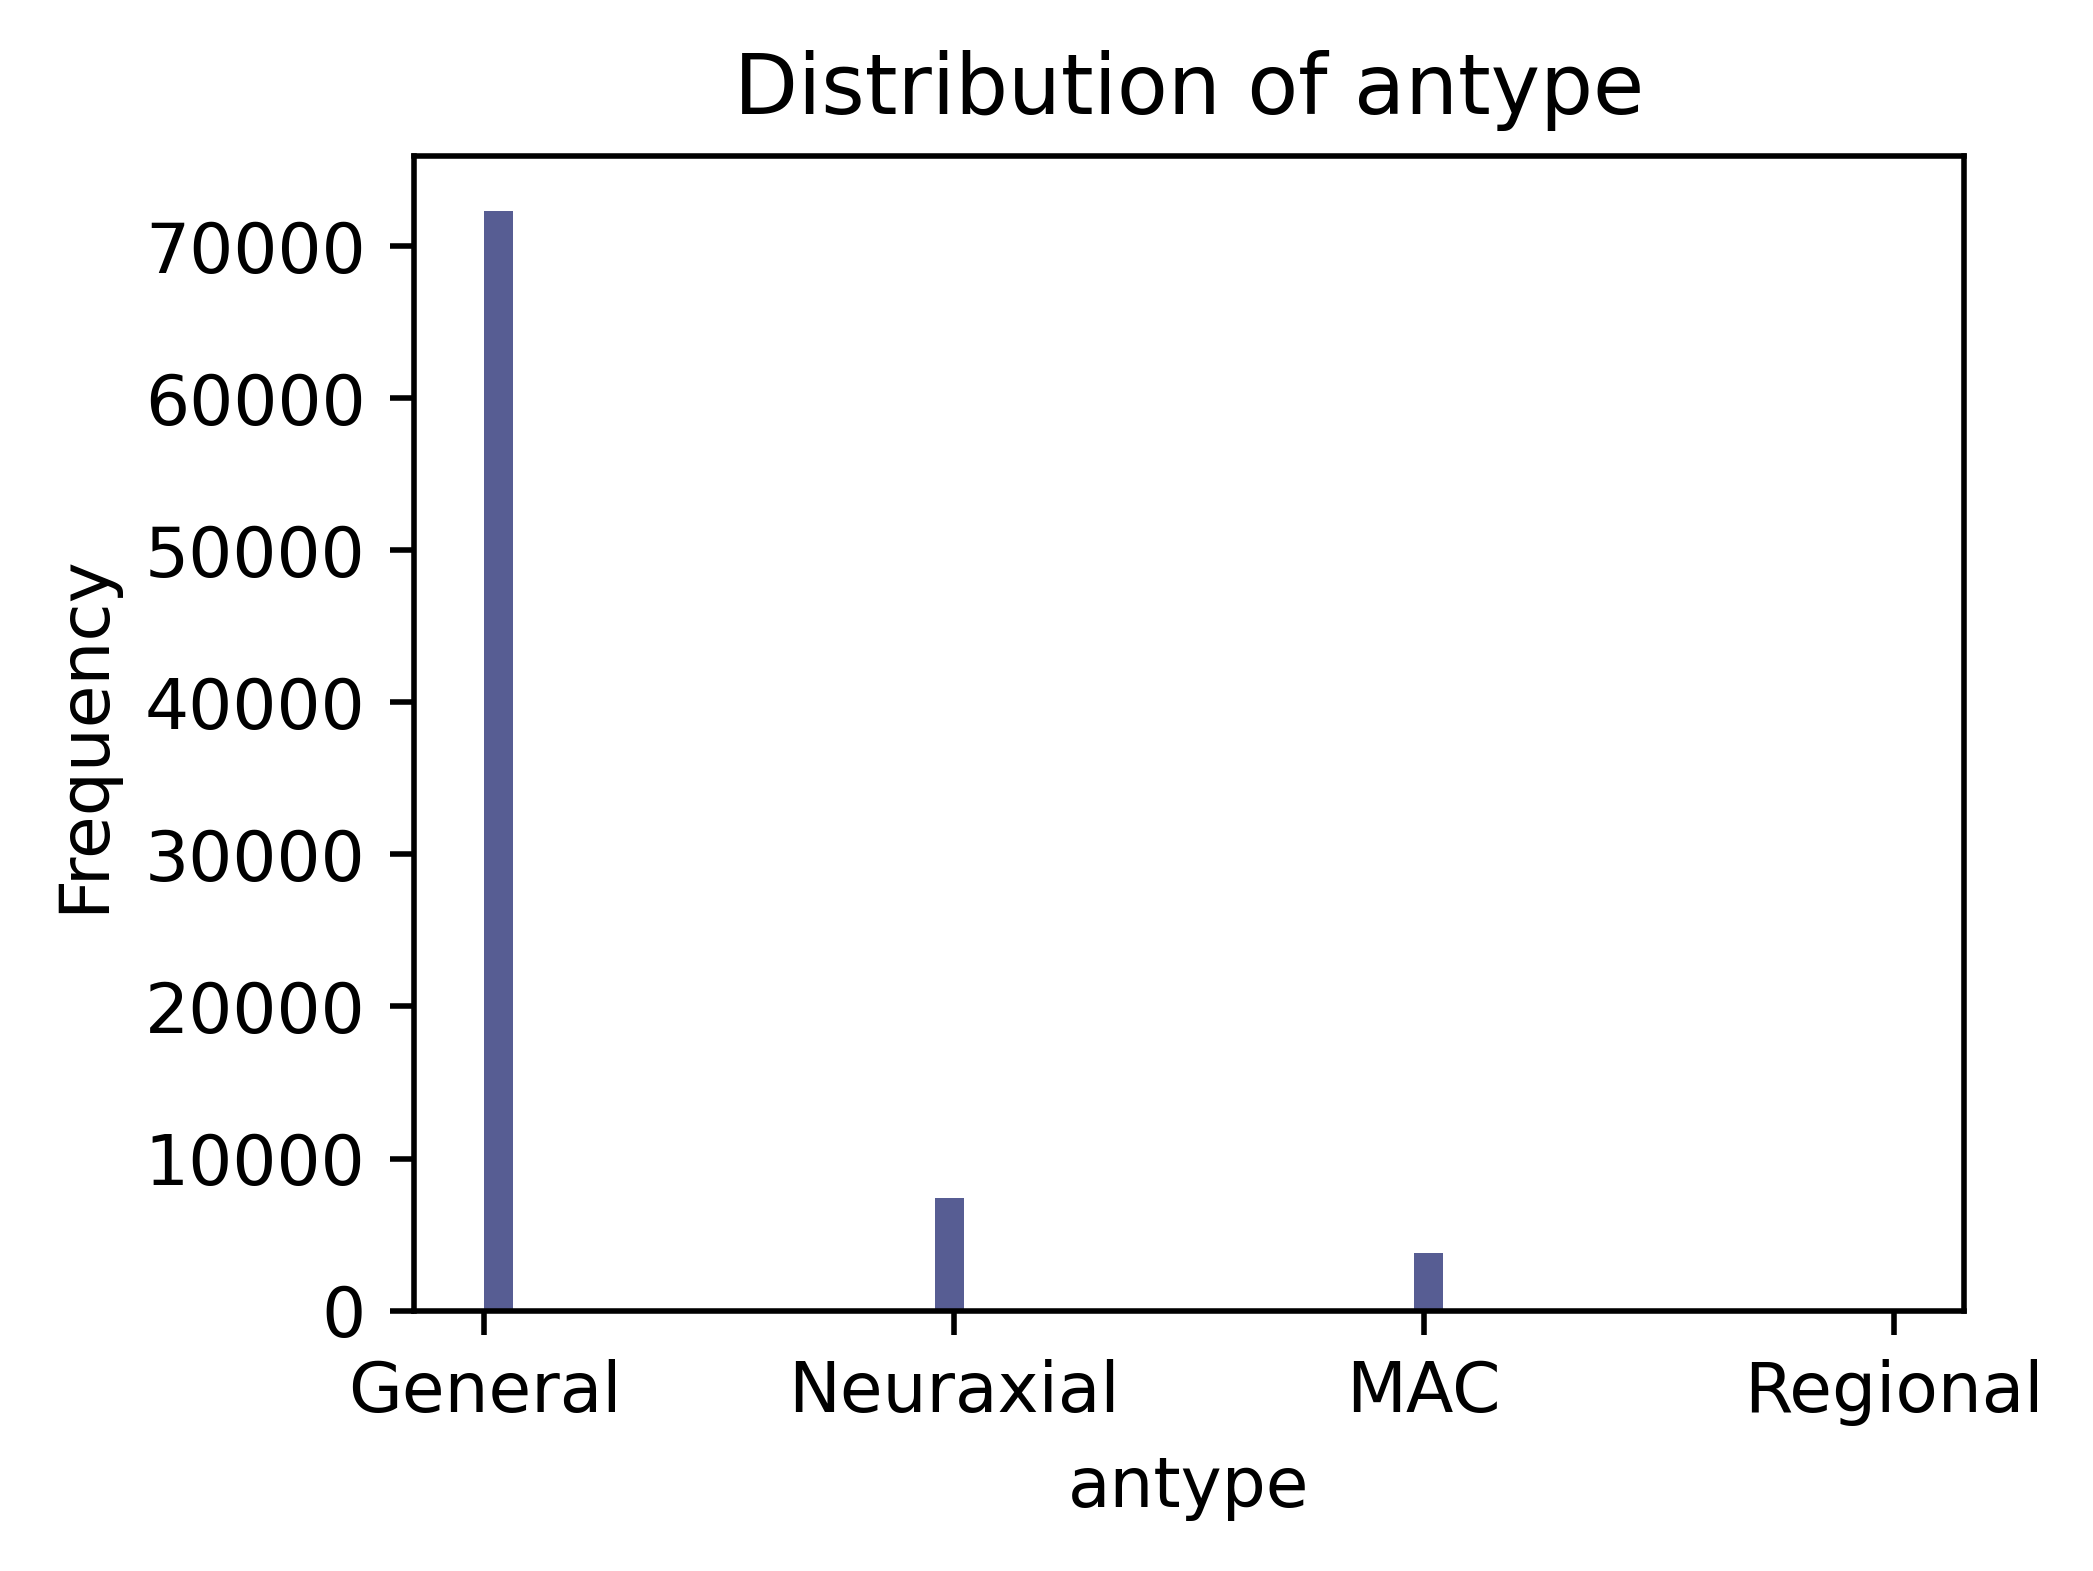

height_m: min = 0.5, max = 2.0 


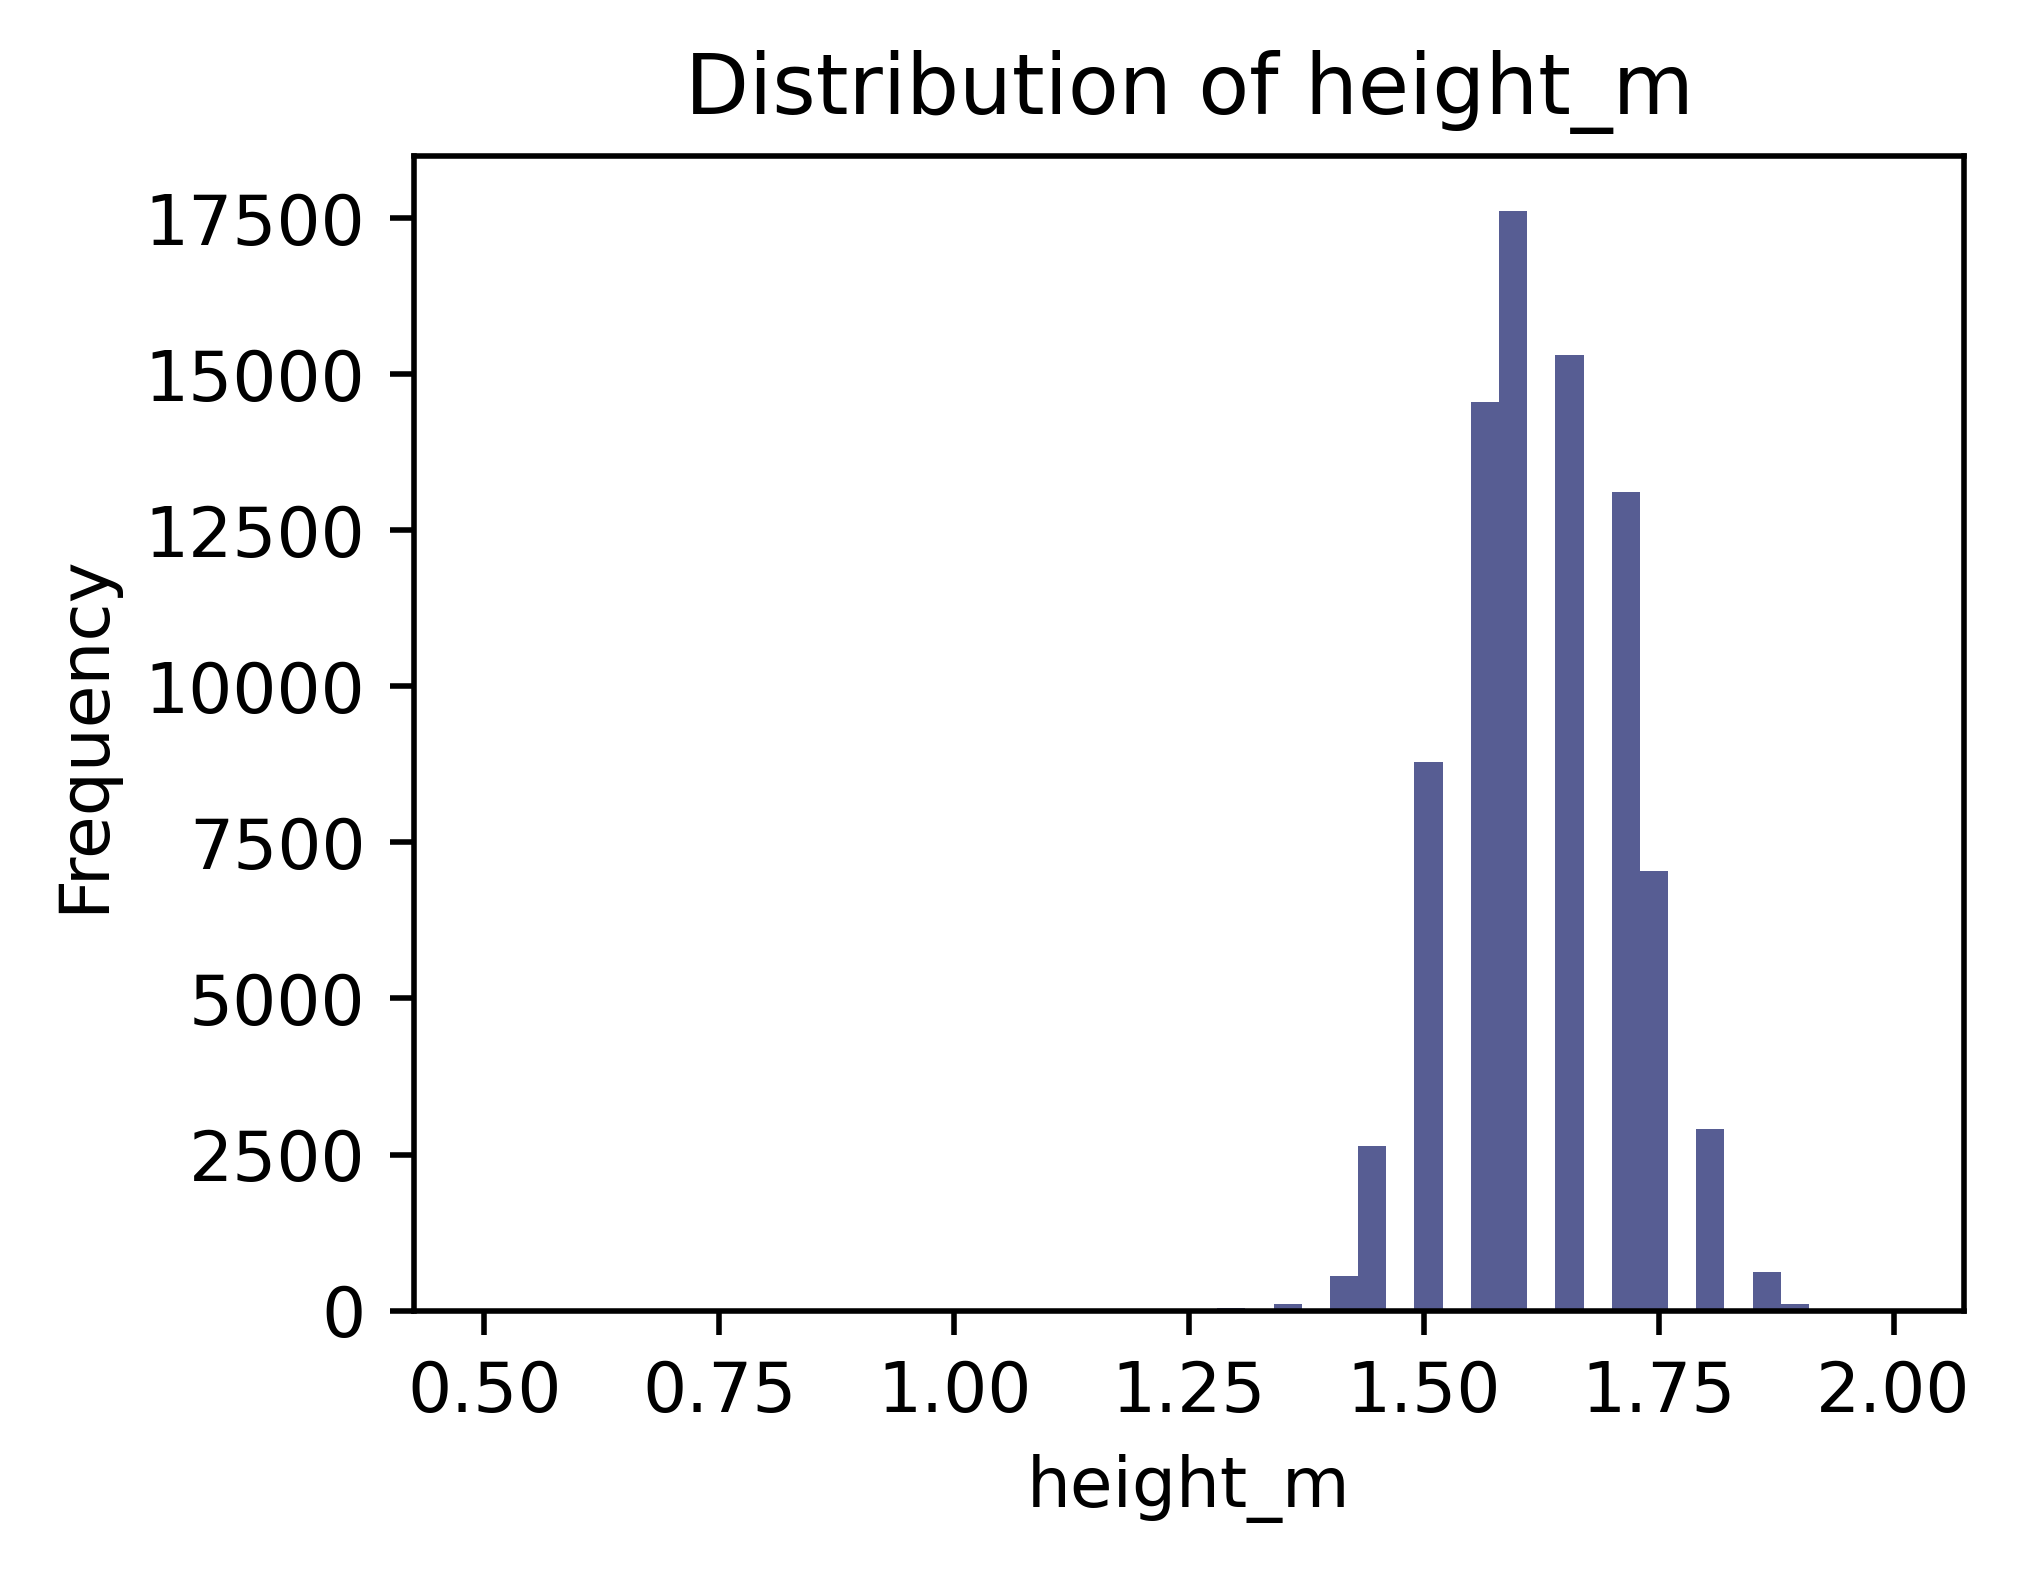

BMI: min = 6.530612244897959, max = 260.0 


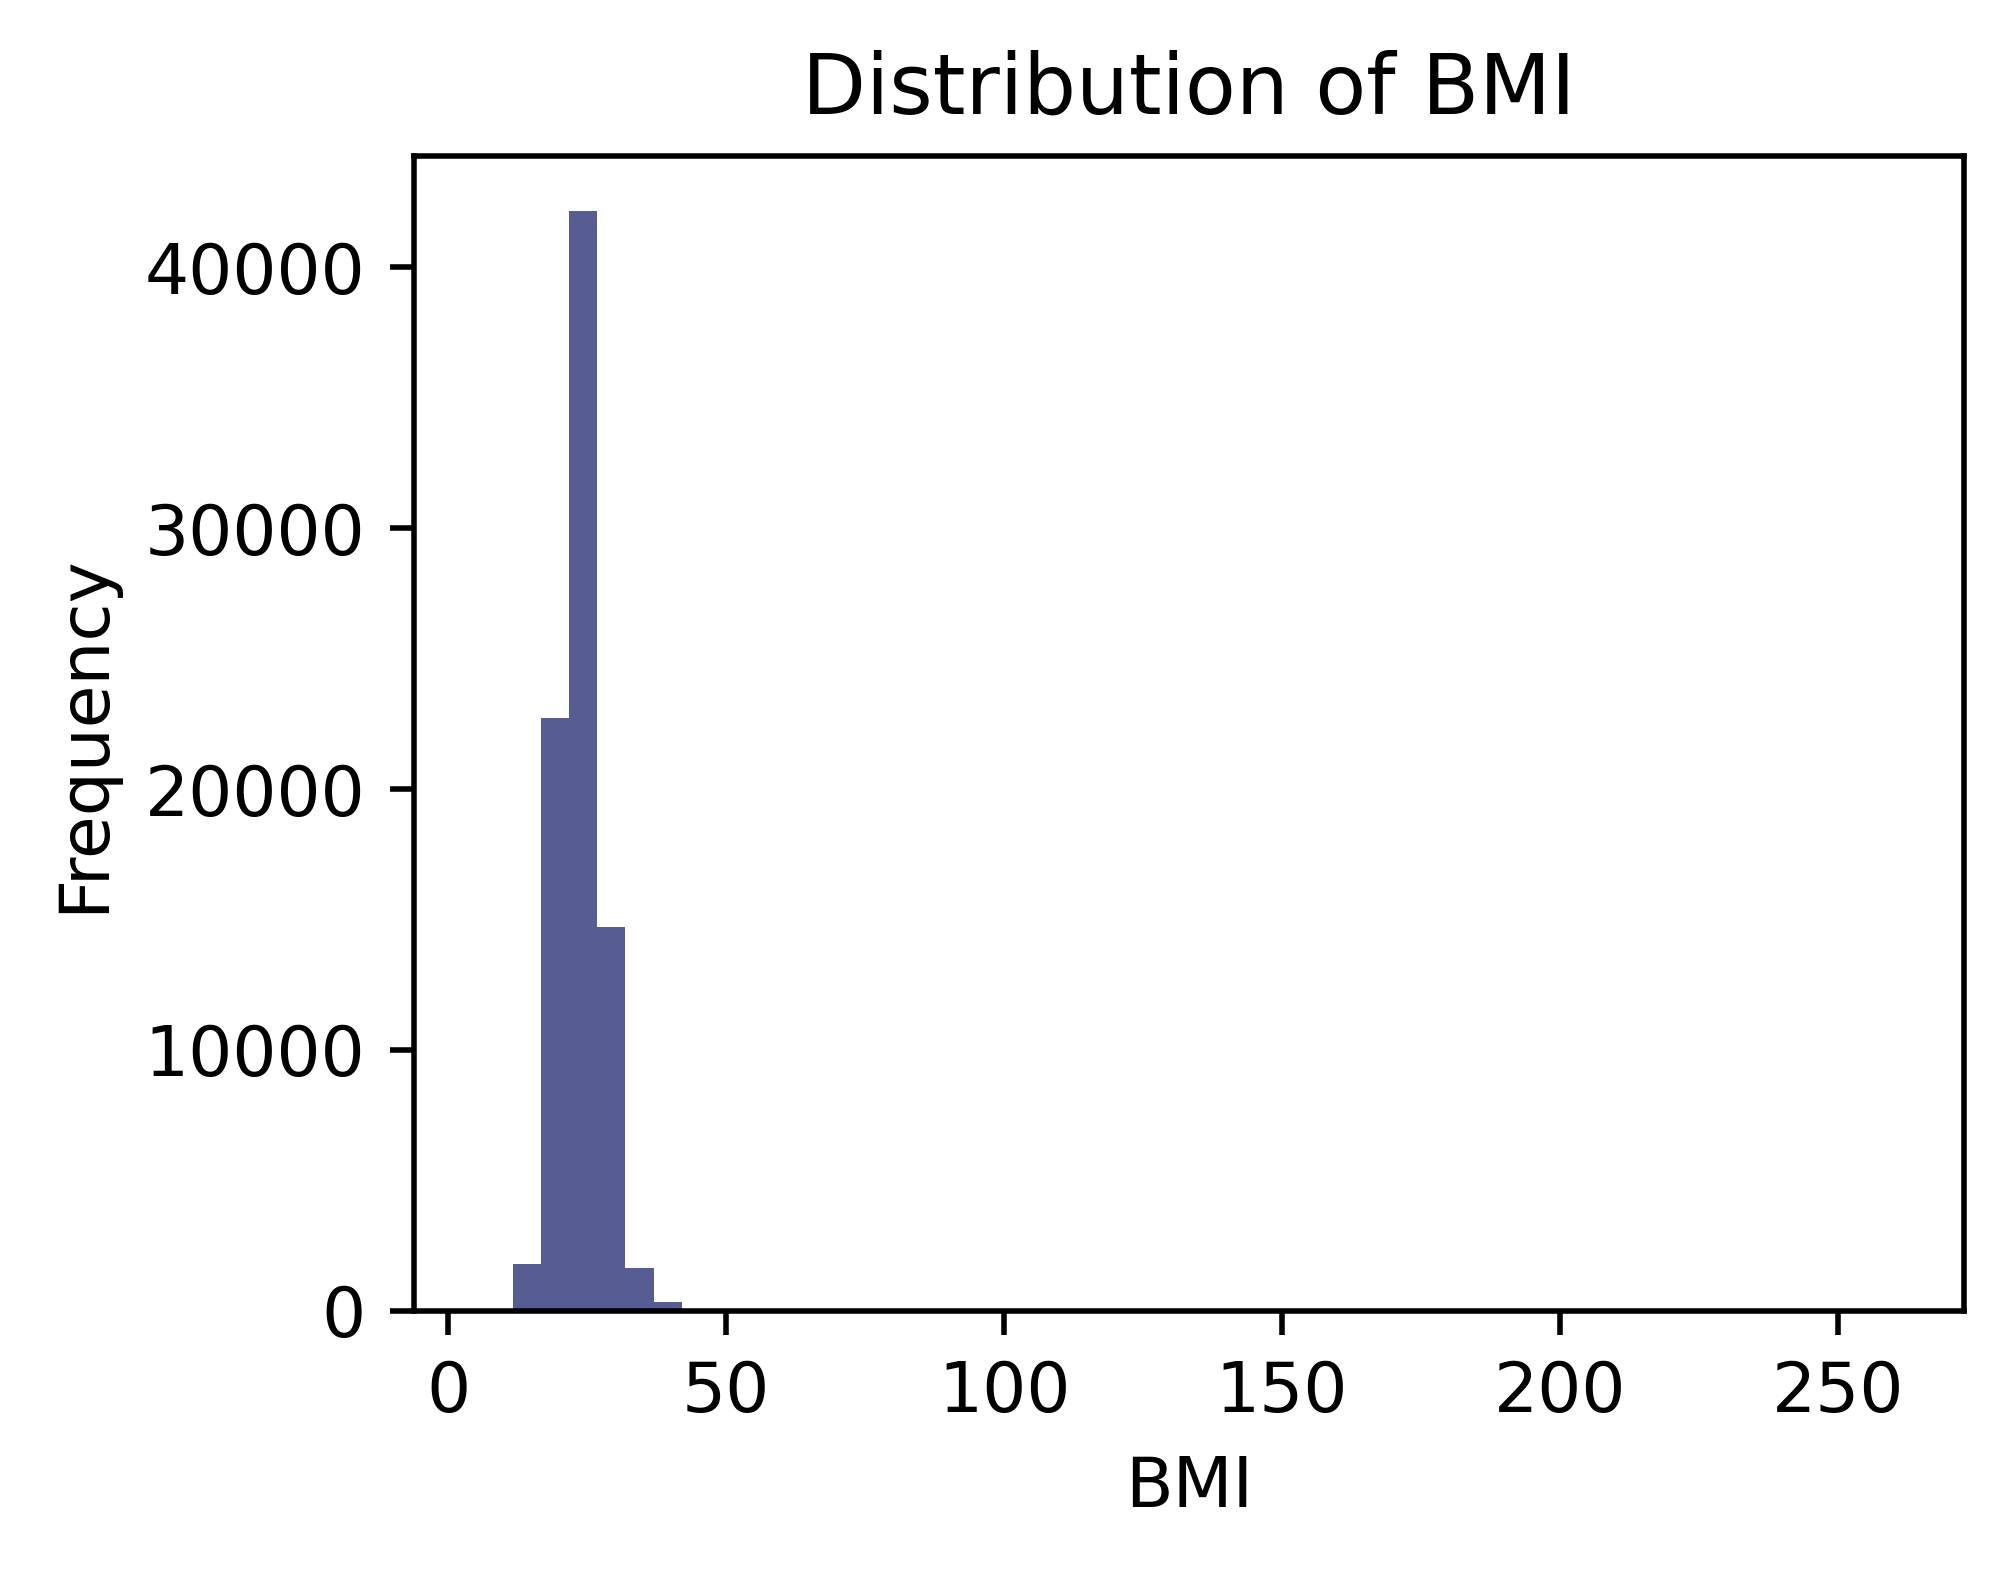

anesthesia_duration: min = 60.0, max = 1435.0 


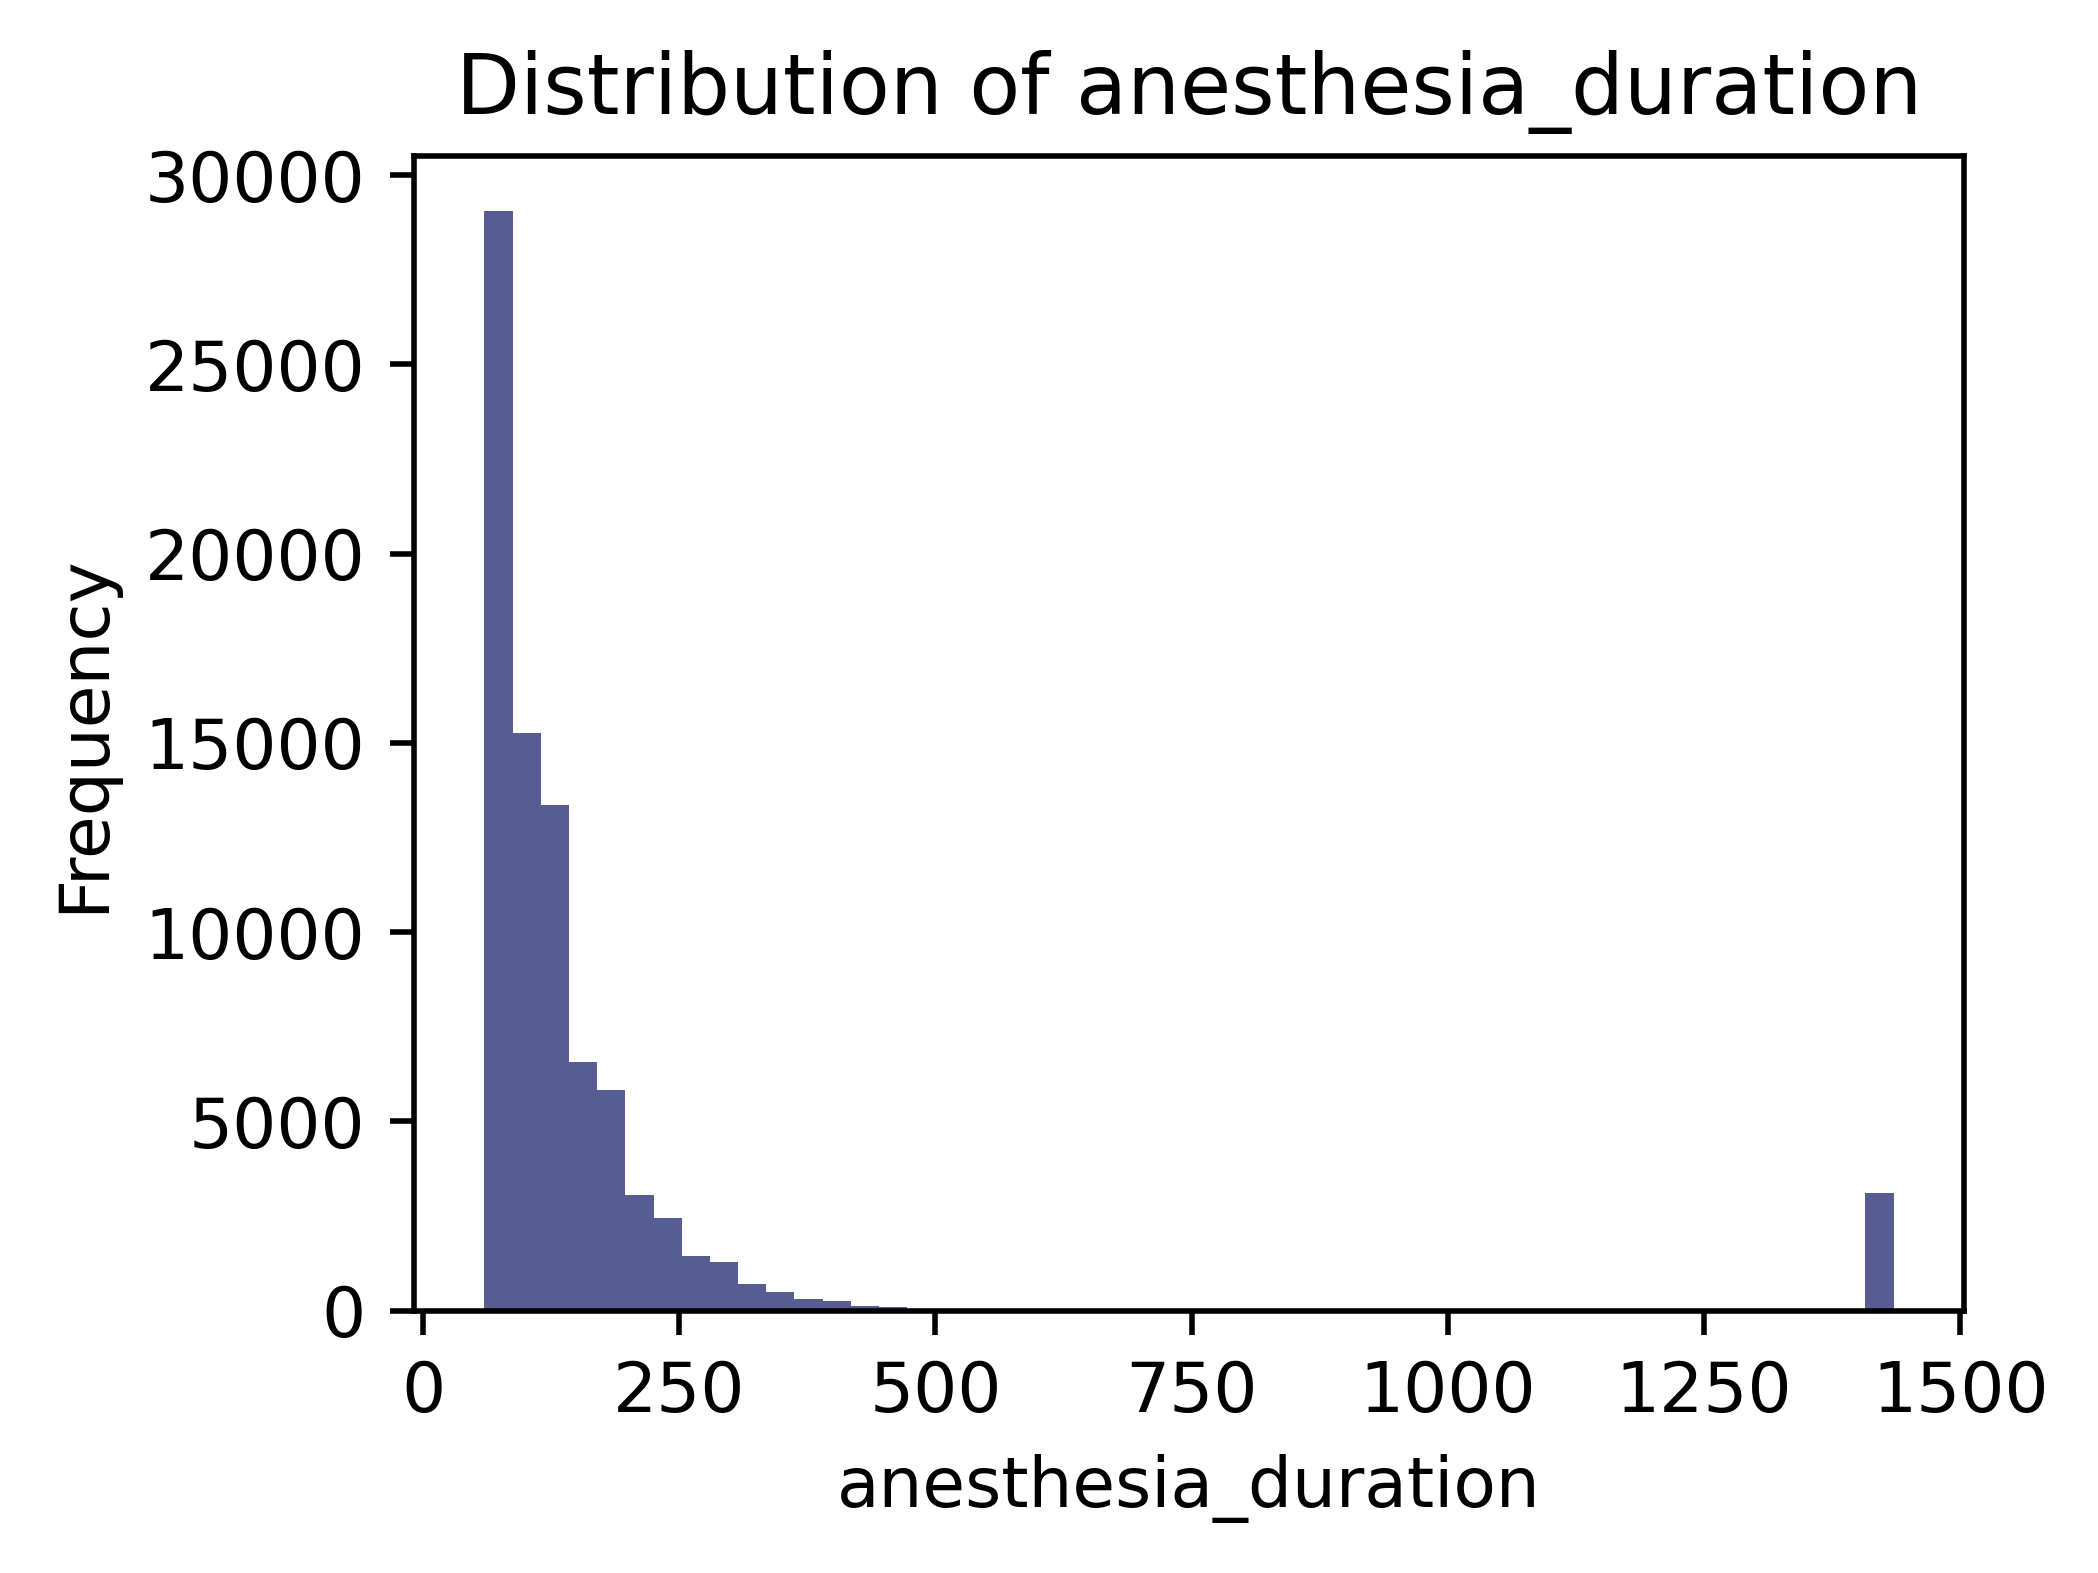

albumin: min = 2.3, max = 4.7 


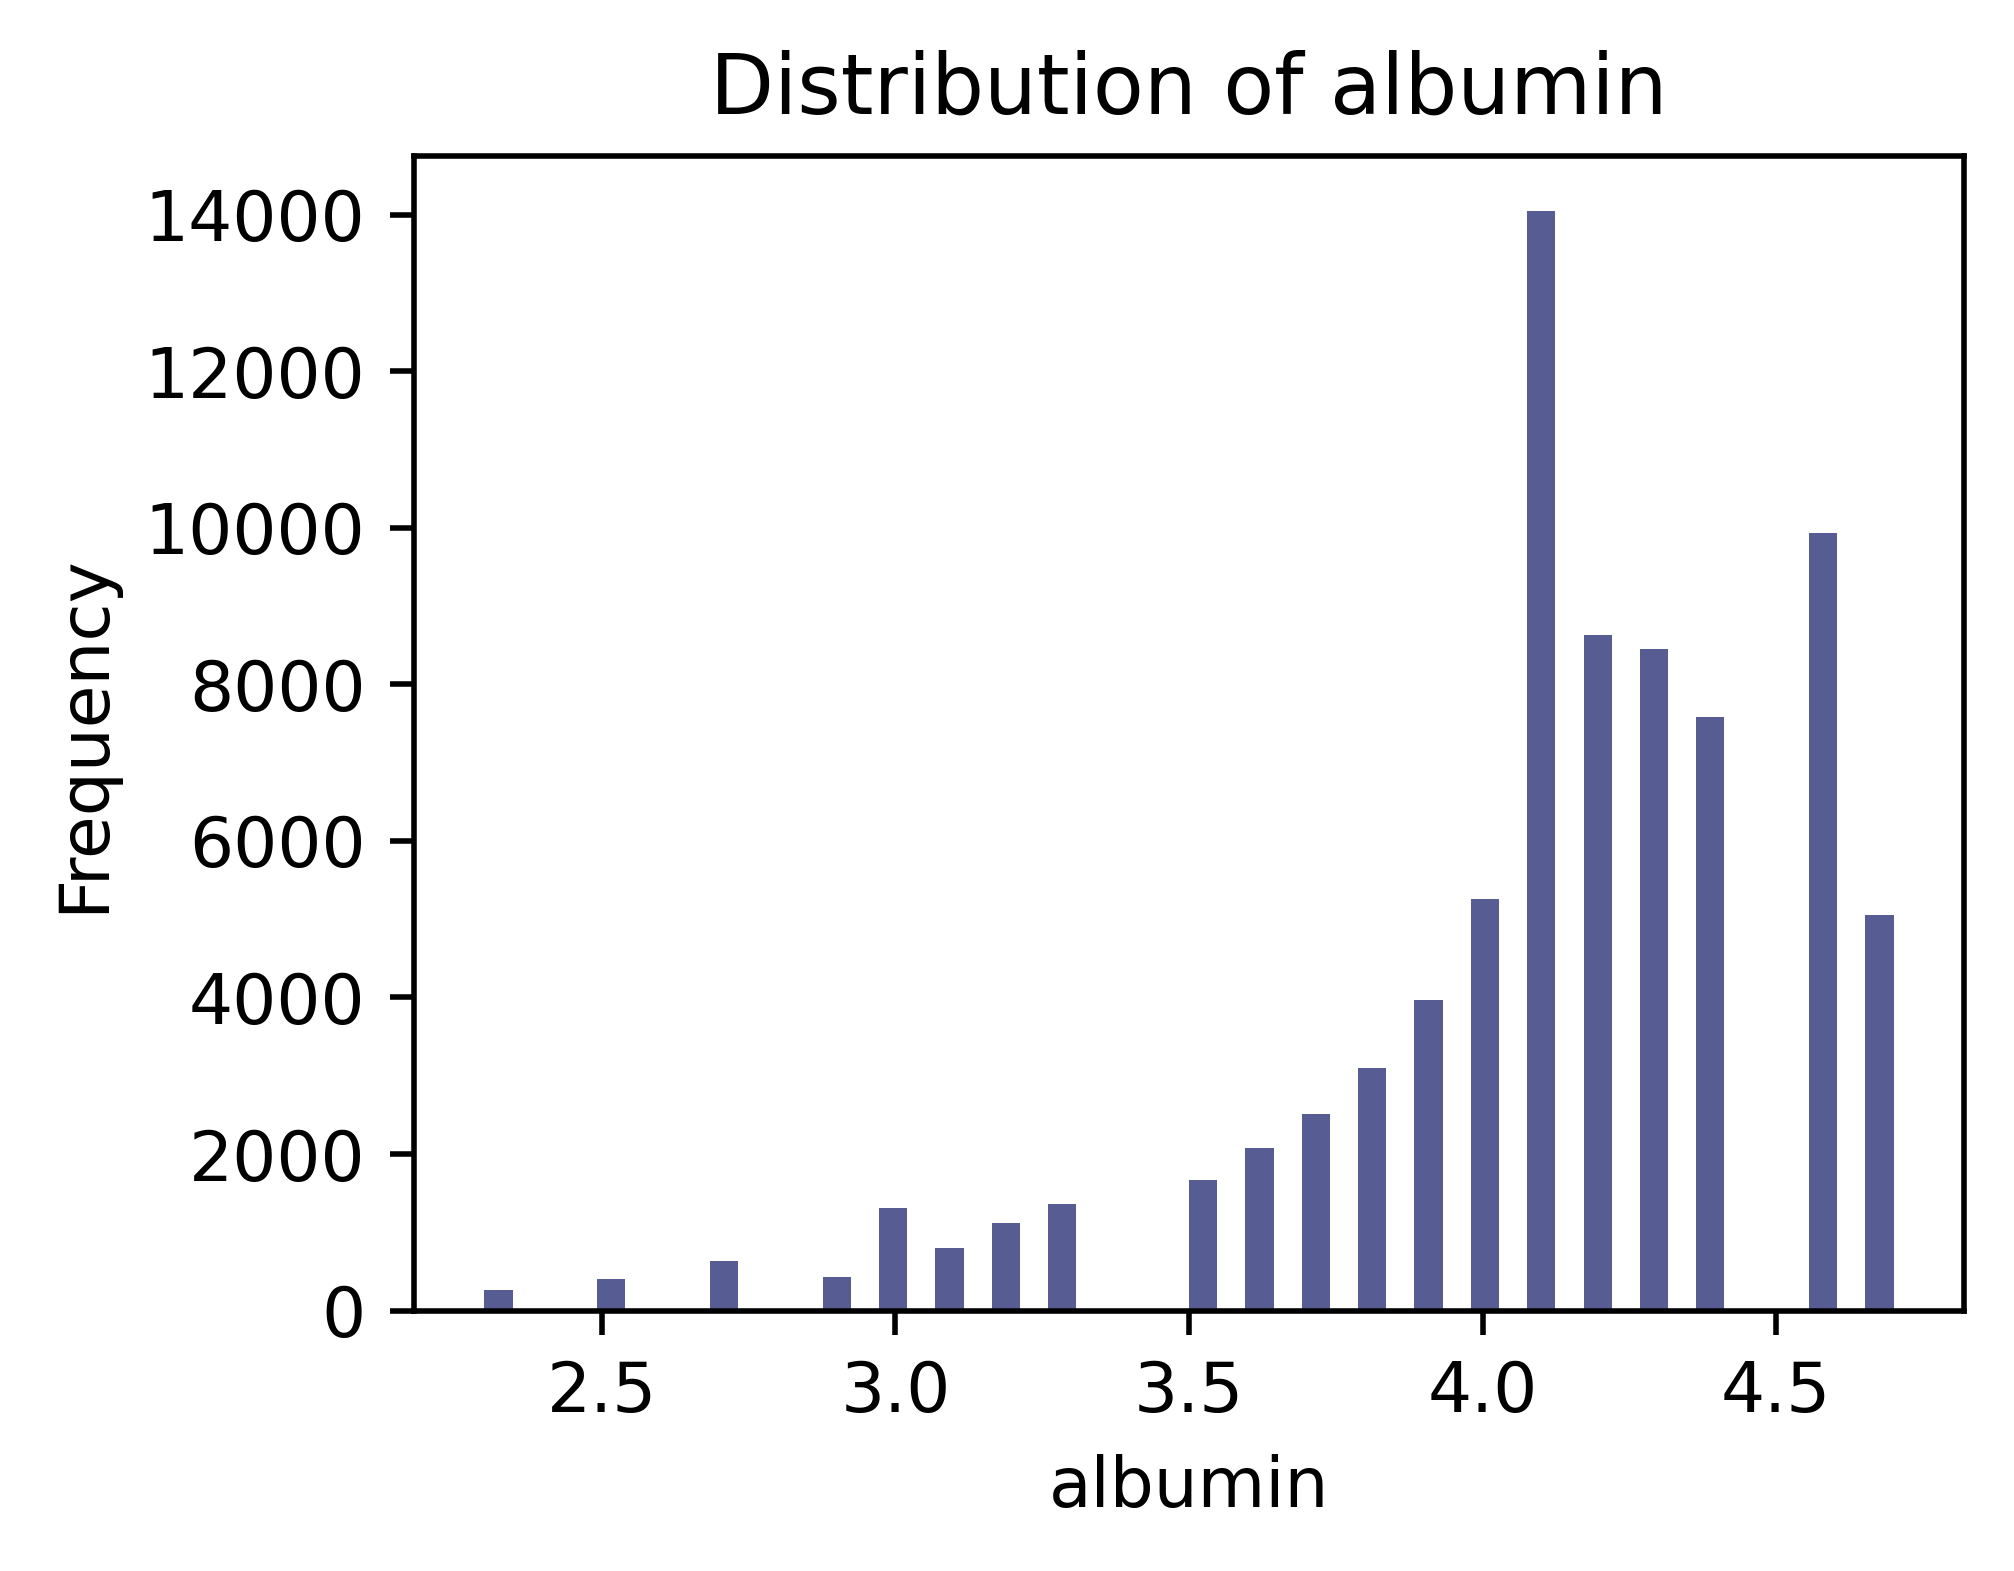

creatinine: min = 0.41, max = 5.55 


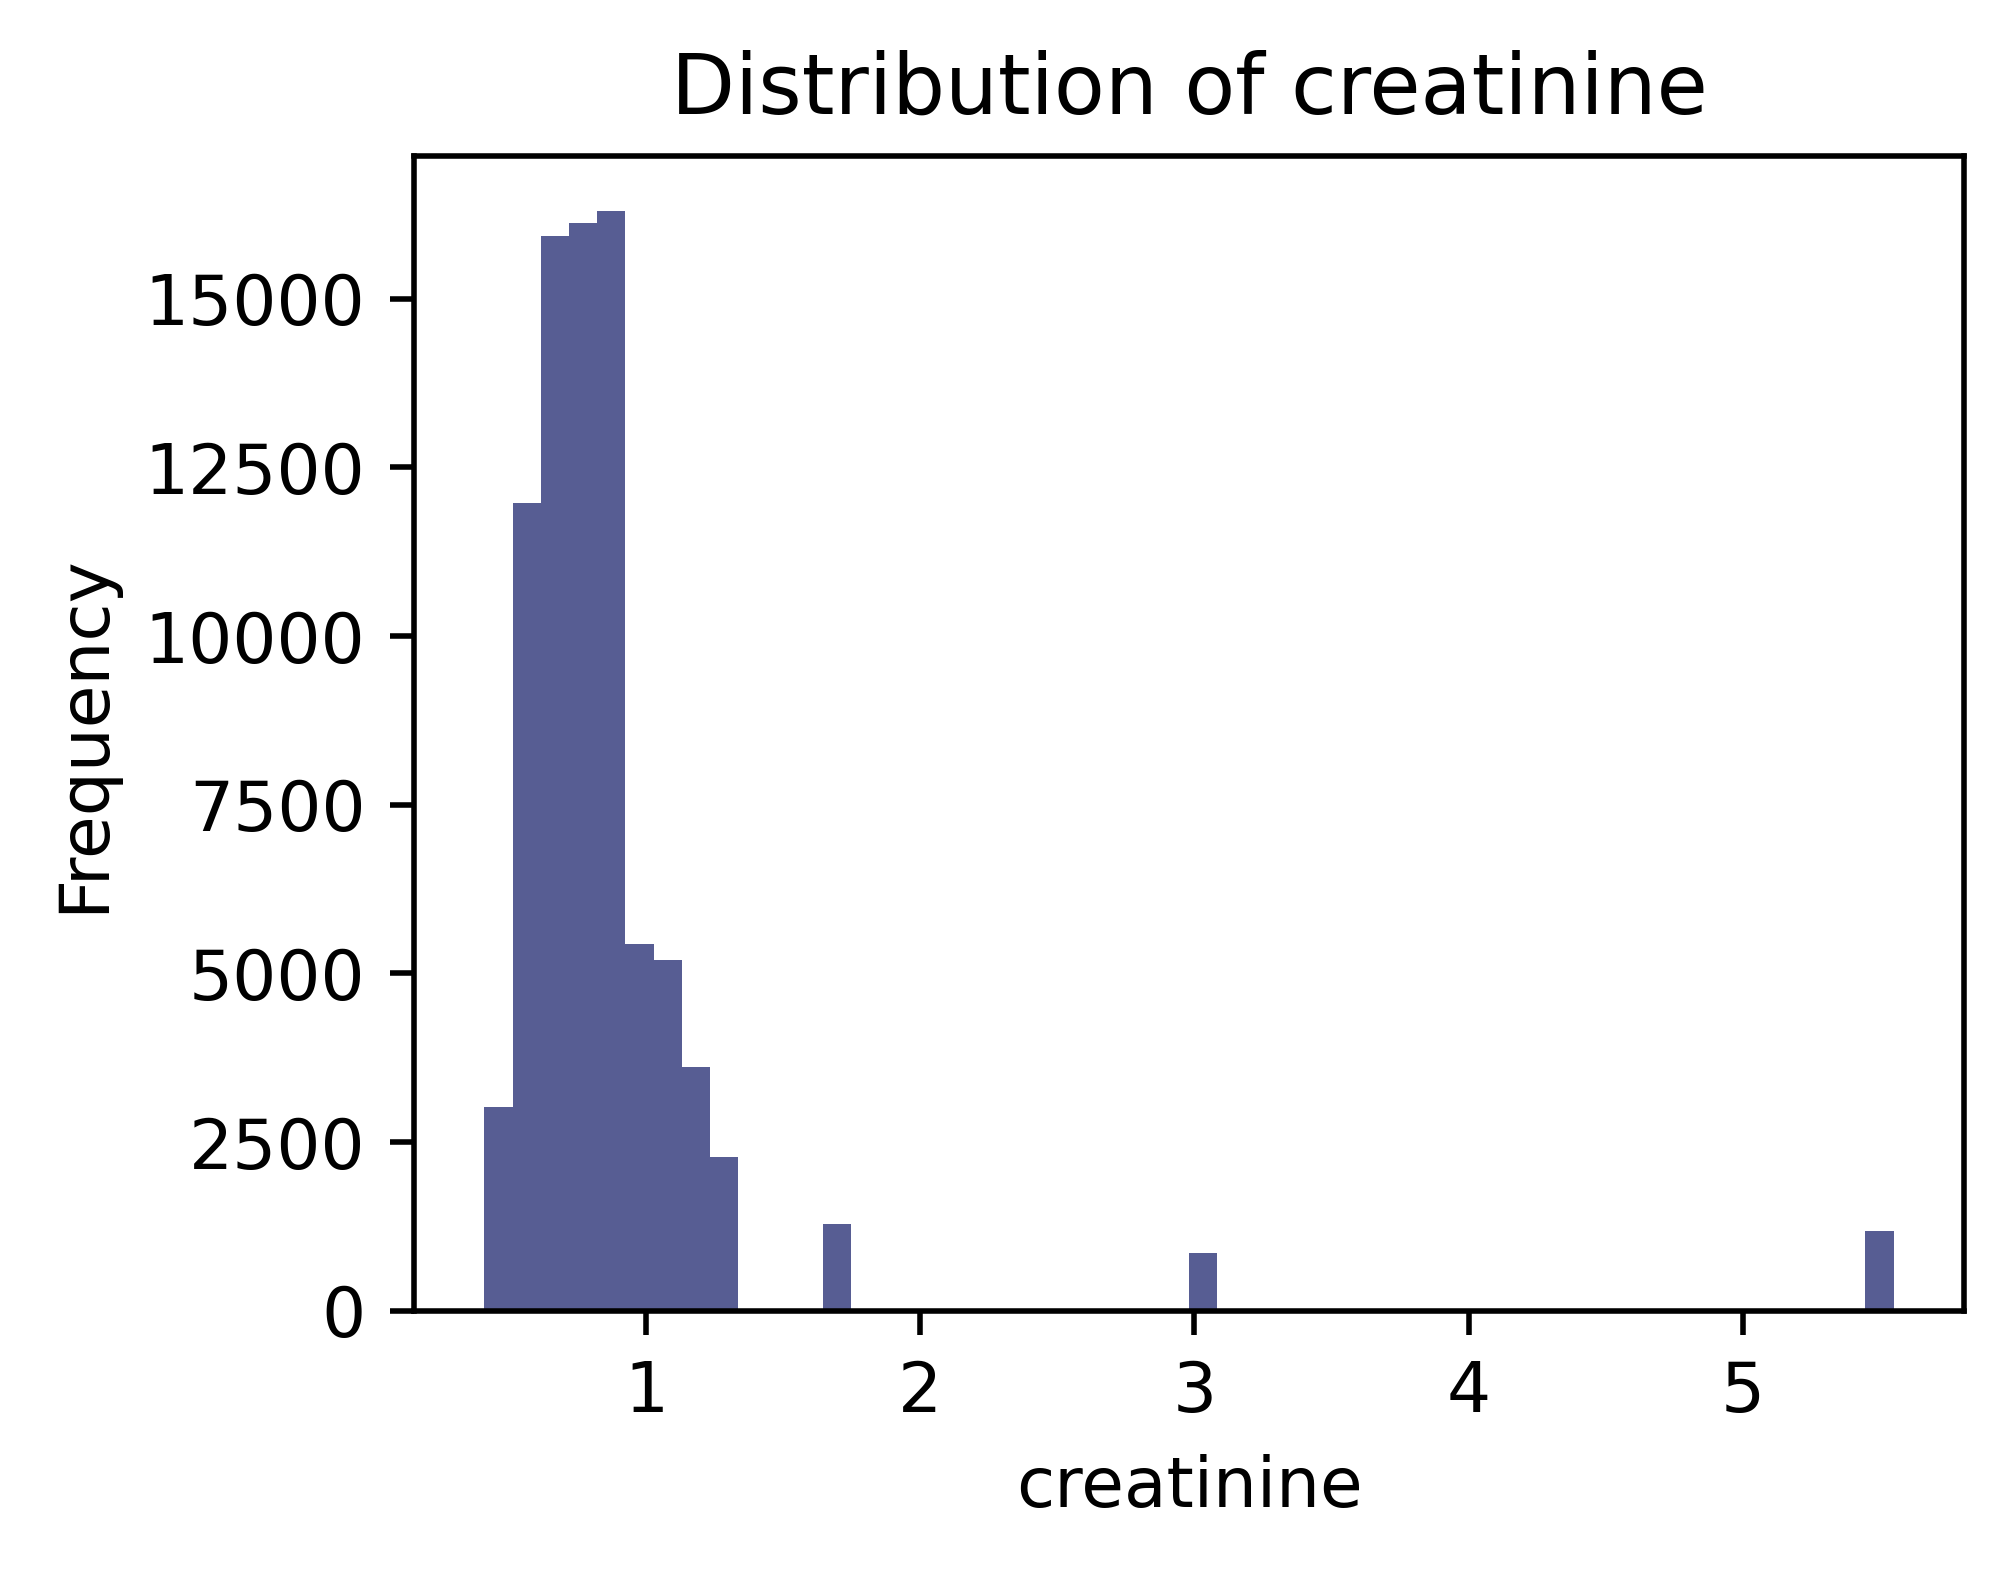

glucose: min = 78.0, max = 302.0 


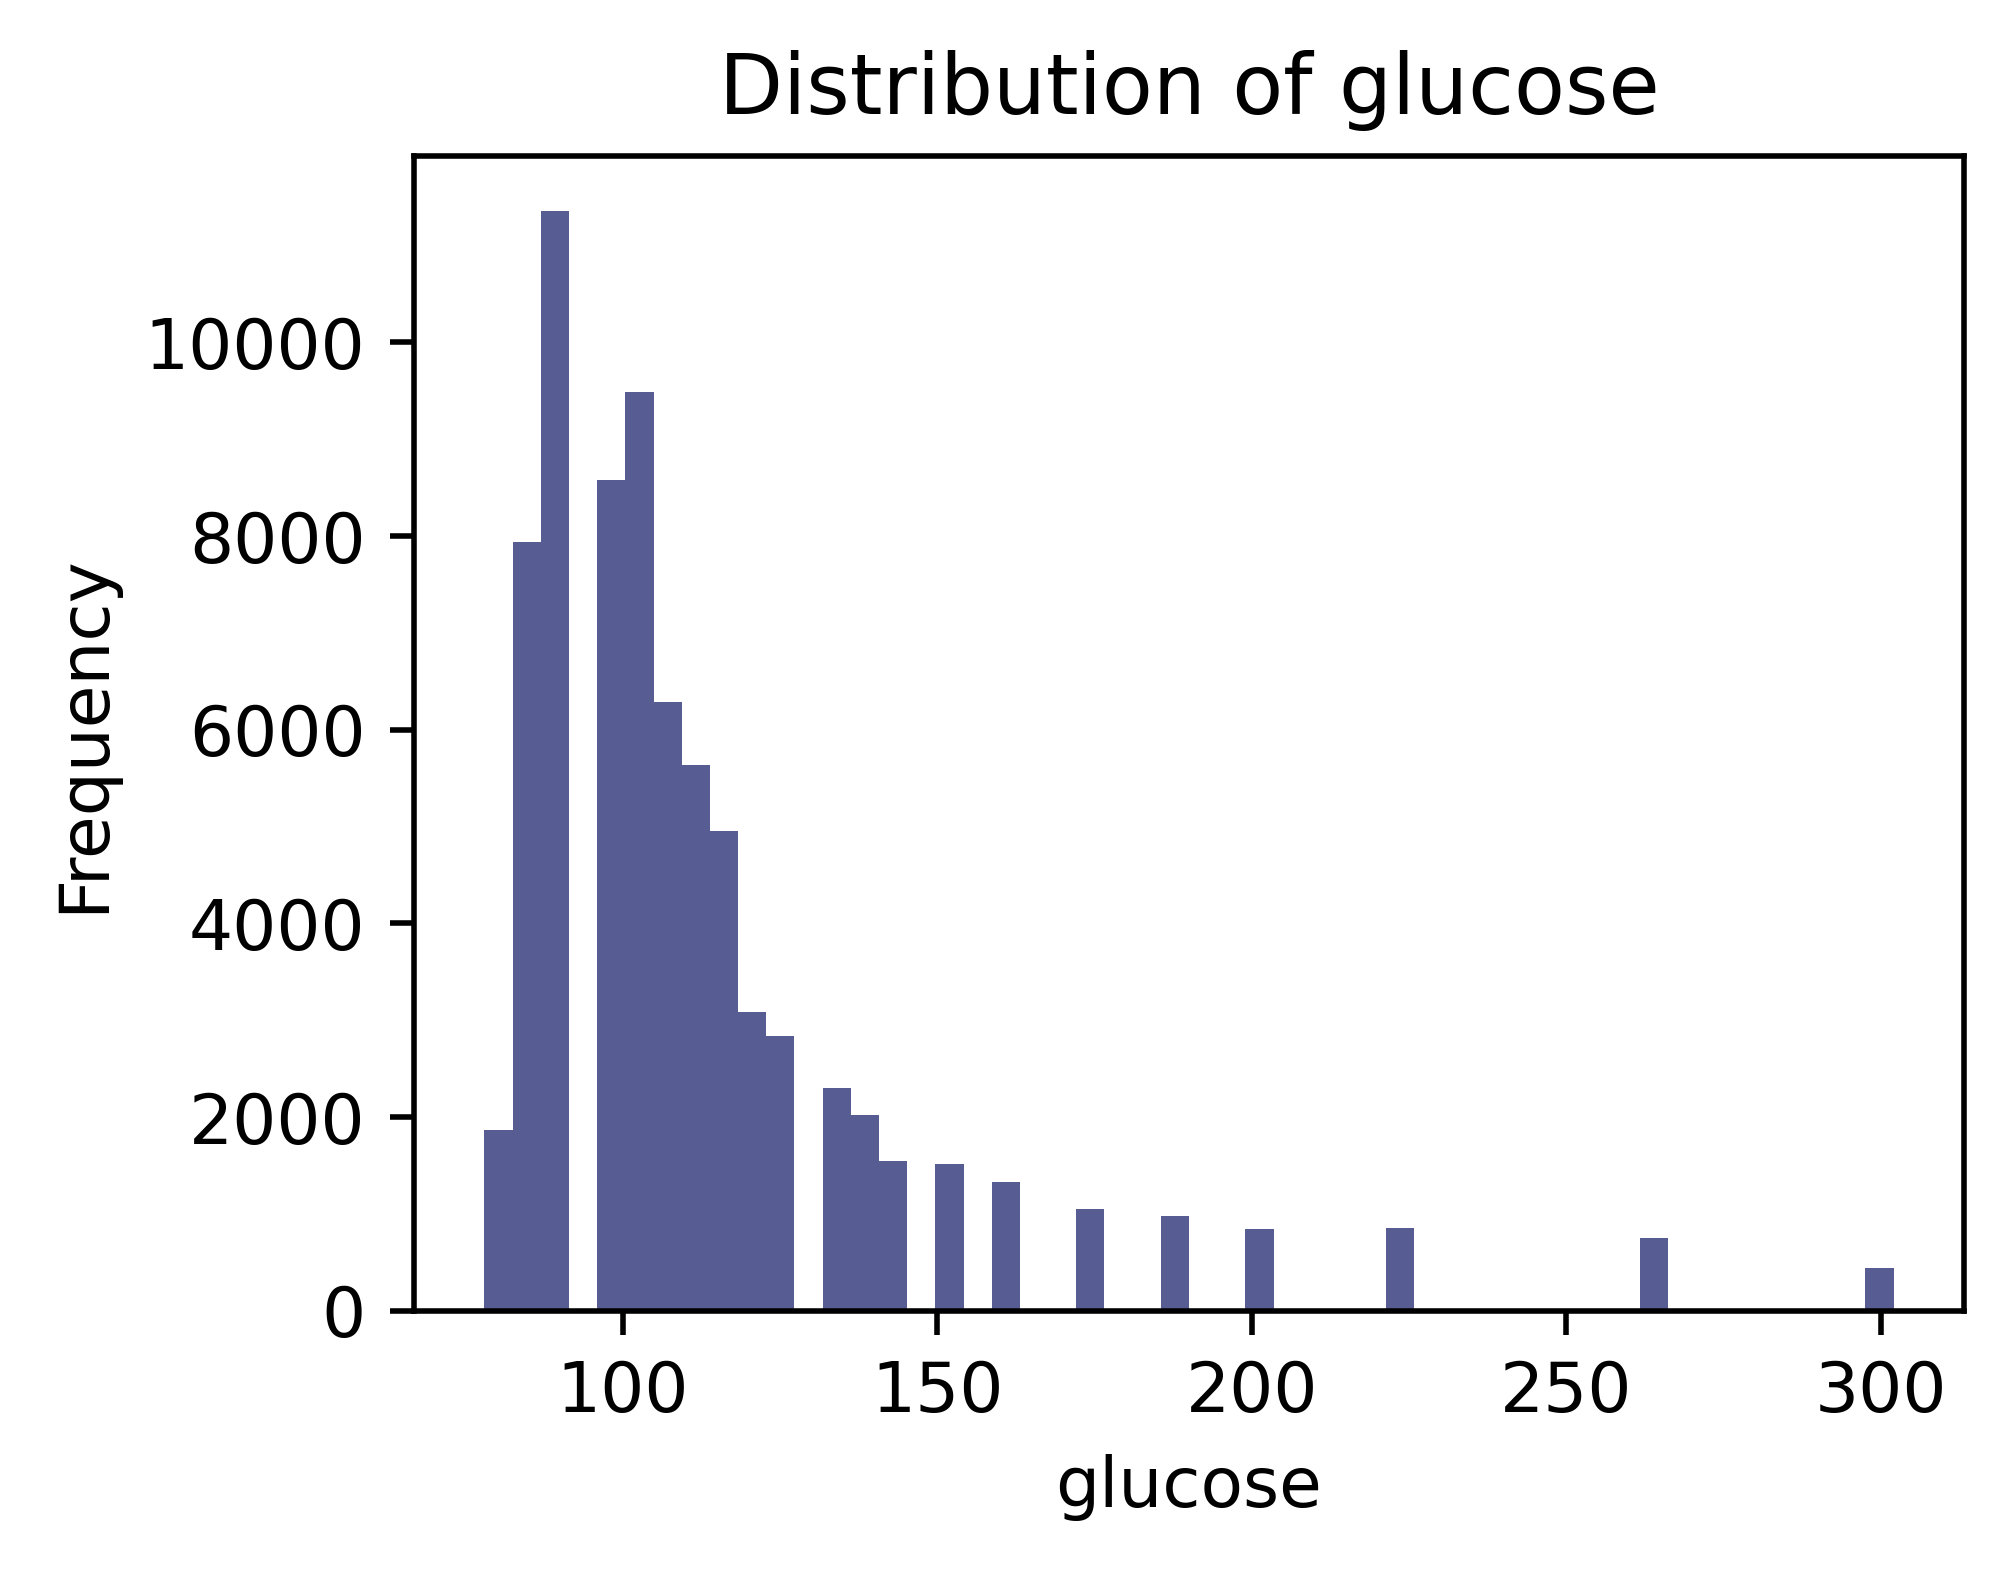

hco3: min = 16.6, max = 34.2 


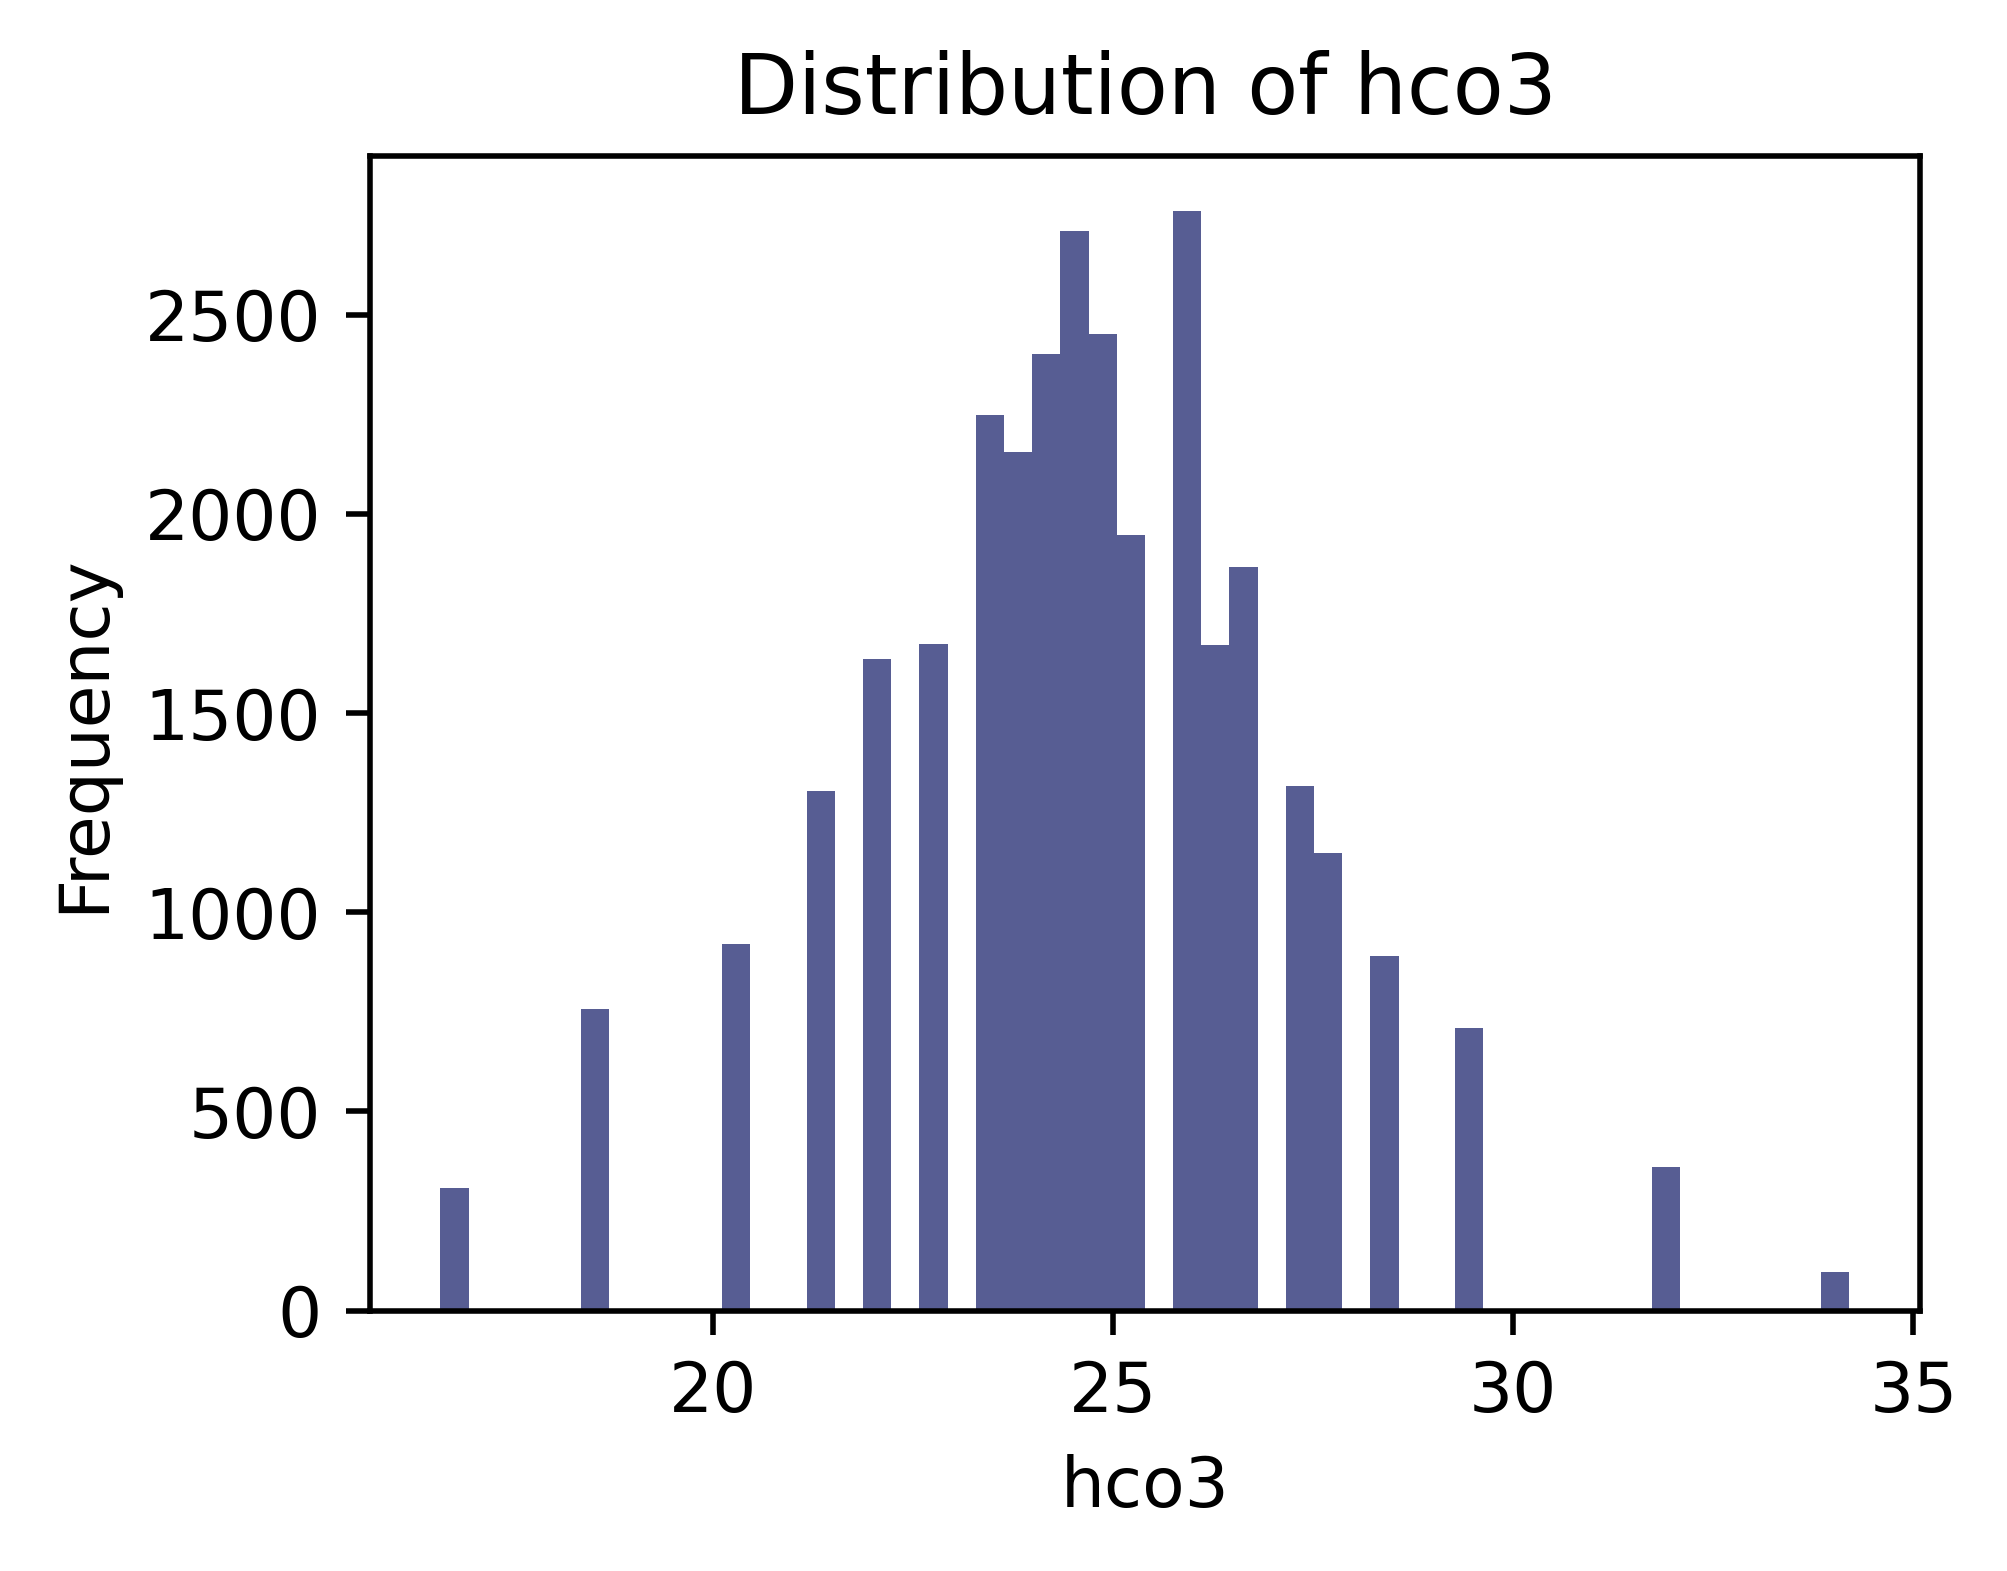

ptinr: min = 0.88, max = 2.56 


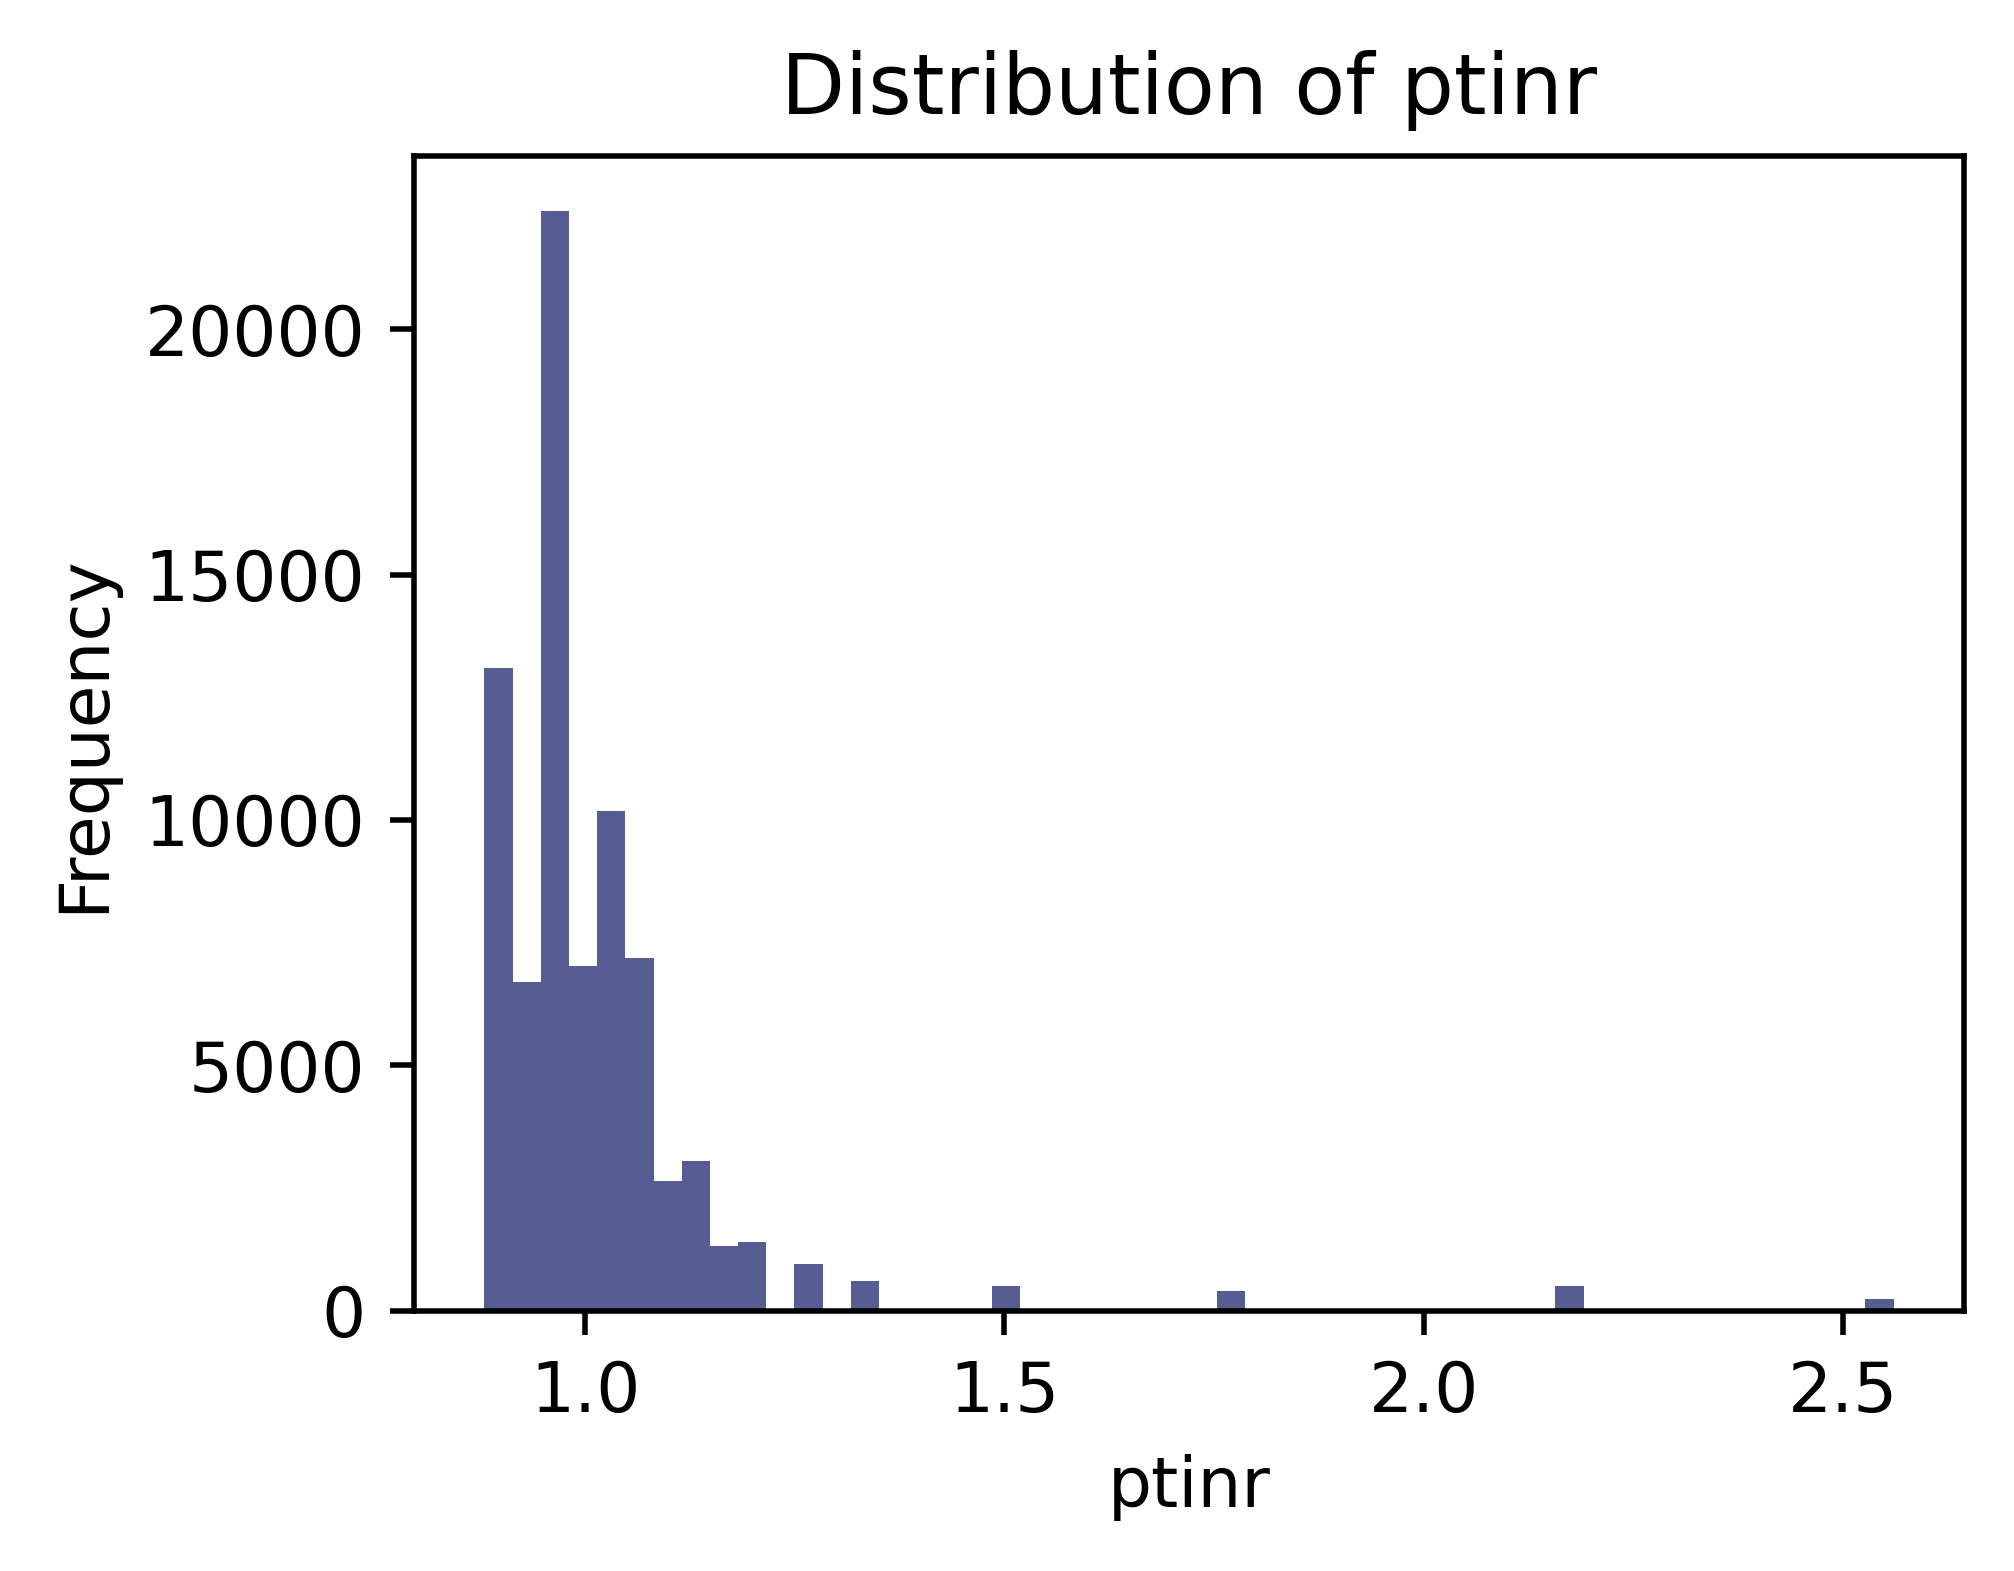

wbc: min = 2.63, max = 19.44 


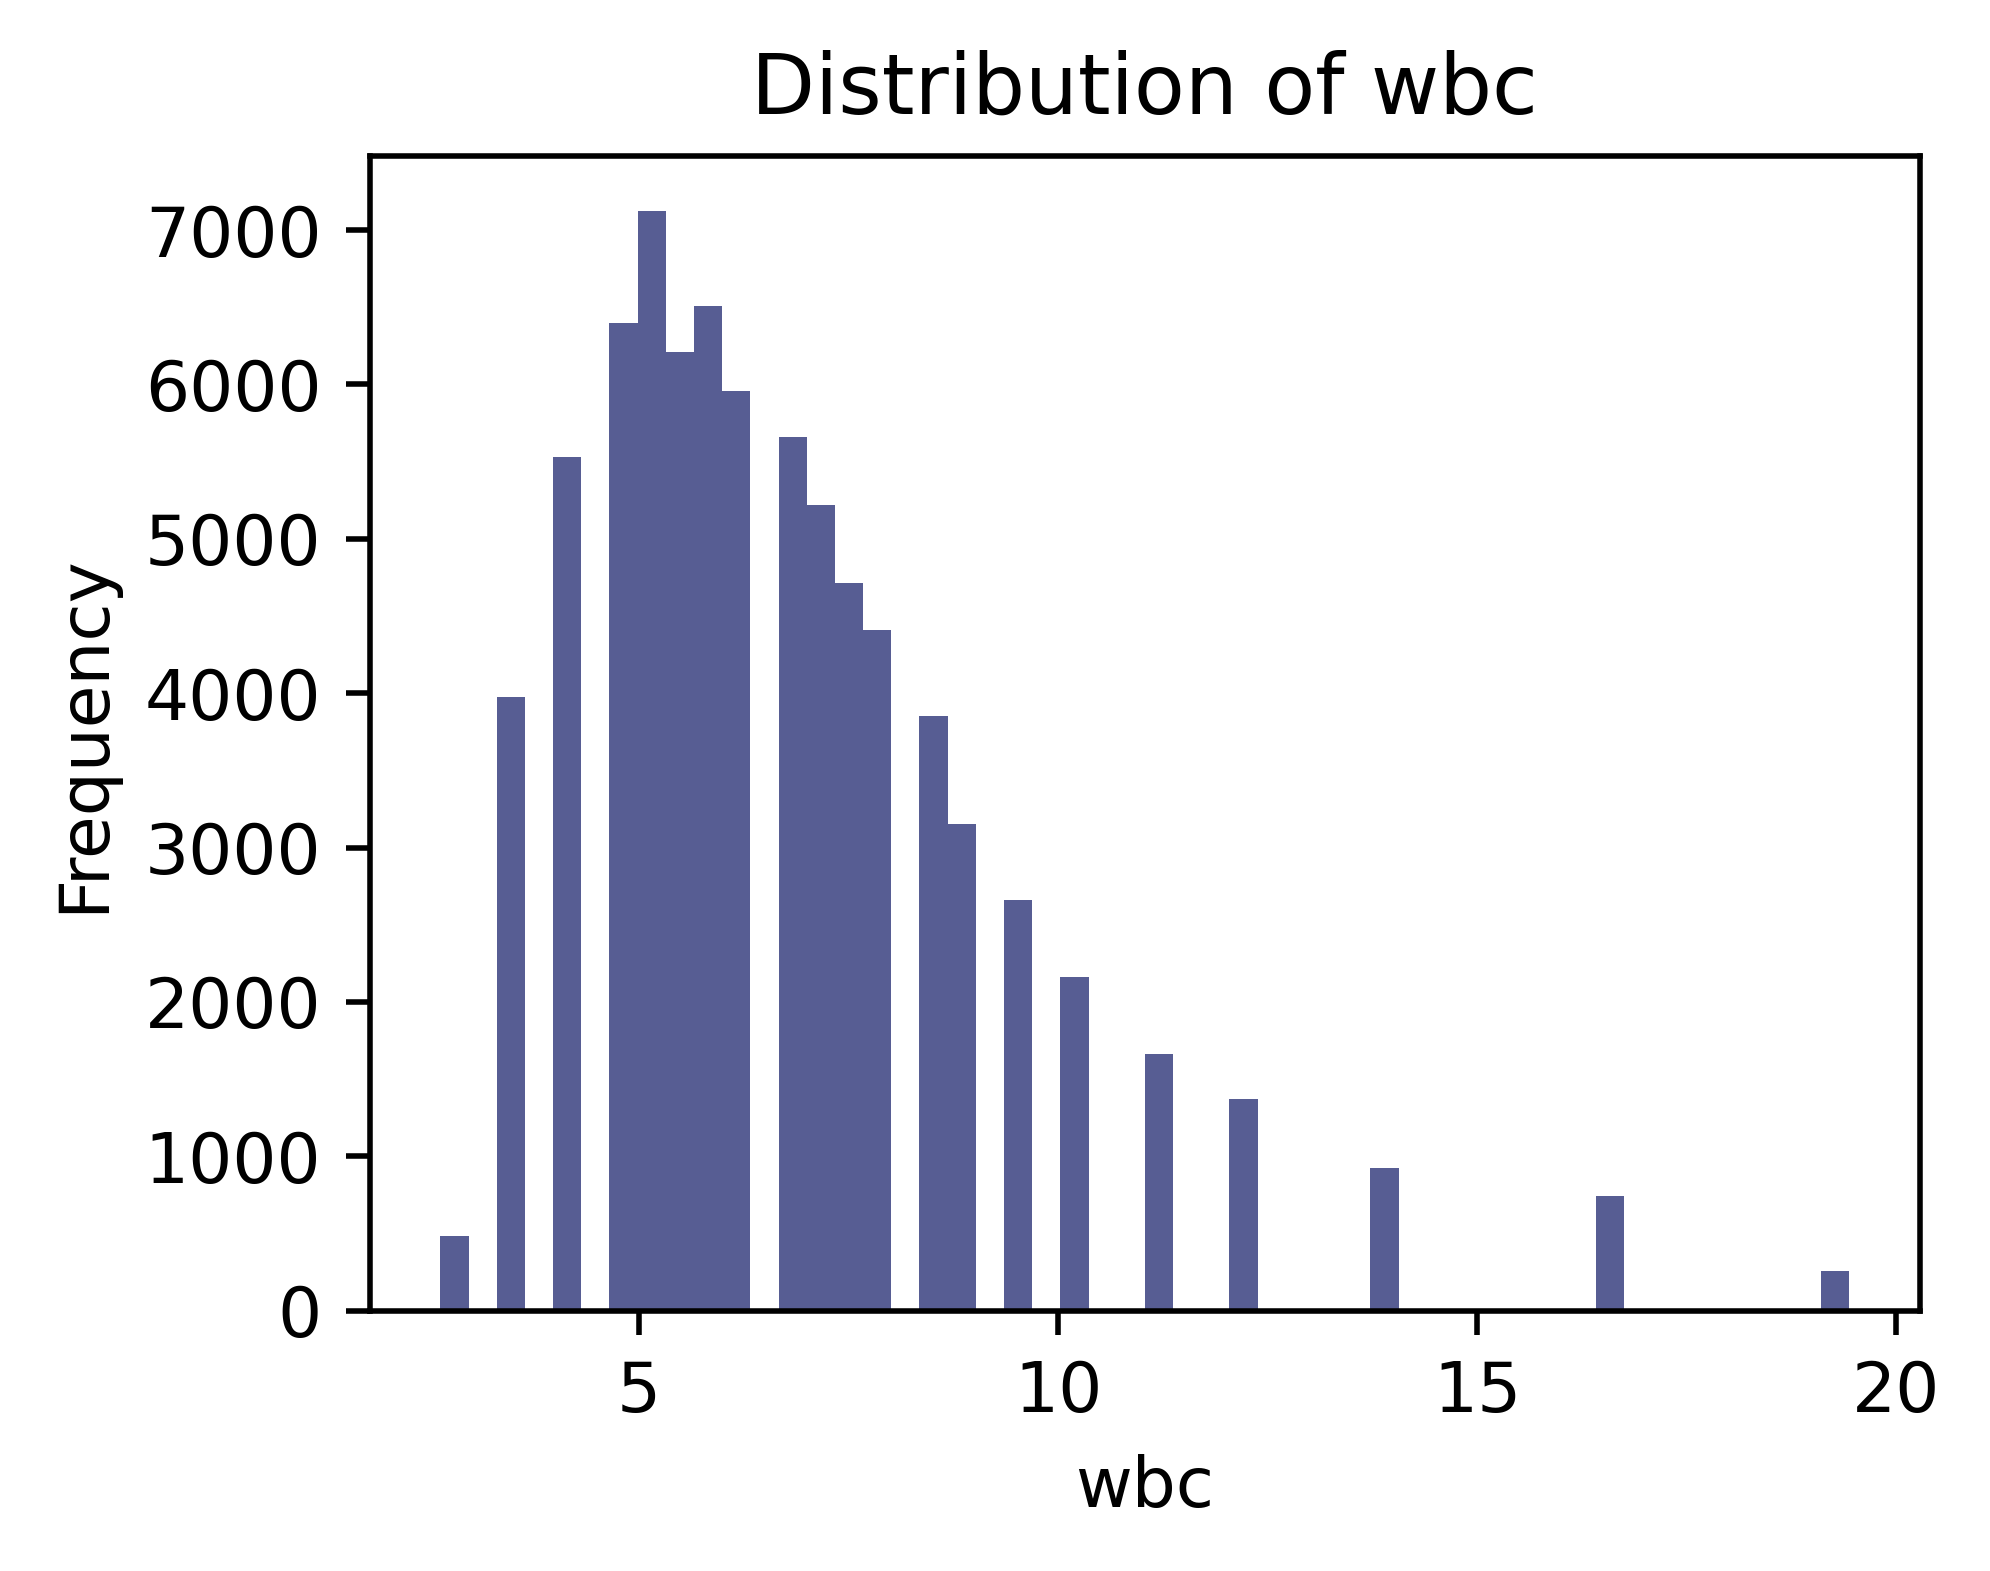

In [13]:
for feat in operations_sub_with_labs.columns[2:]:
  print(f'{feat}: min = {np.min(operations_sub_with_labs[feat])}, max = {np.max(operations_sub_with_labs[feat])} ')
  plt.figure(figsize=(4,3), dpi=500)
  plt.hist(operations_sub_with_labs[feat], bins=50, alpha=0.9, color=palette['INSPIRE'])
  plt.xlabel(feat)
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {feat}')
  plt.show()

In [14]:
# Step 1: Merge operations_sub with ventilator data
vent_merge = pd.merge(
    operations_sub[['subject_id', 'anend_time']],
    ward_vitals.loc[ward_vitals['item_name'] == 'vent'],
    on='subject_id',
    how='inner'
)

# Step 2: Convert times to integers for comparison (if needed)
vent_merge['chart_time_sec'] = vent_merge['chart_time'].astype(int)
vent_merge['anend_time_sec'] = vent_merge['anend_time'].astype(int)

# Step 3: Keep only ventilator data from before end of anesthesia
pre_anend_vent = vent_merge[vent_merge['chart_time_sec'] < vent_merge['anend_time_sec']]

# Step 4: For each subject, we need to decide which ventilator value to use
# Let's take the most recent value before anesthesia end
pre_anend_vent = pre_anend_vent.sort_values(['subject_id', 'chart_time_sec'], ascending=[True, False])
selected_vent = pre_anend_vent.drop_duplicates('subject_id')

# Step 5: Create a Series with subject_id as index and value as values
vent_series = selected_vent.set_index('subject_id')['value']

# Step 6: Add the ventilator values to operations_sub_with_labs
operations_sub_with_labs['vent'] = operations_sub_with_labs['subject_id'].map(vent_series)

# Print diagnostic information
print(f"Number of patients with ventilator data: {len(selected_vent)}")
print(f"Updated DataFrame shape: {operations_sub_with_labs.shape}")

Number of patients with ventilator data: 2896
Updated DataFrame shape: (83580, 19)


In [15]:
df = operations_sub_with_labs[['age','BMI','anesthesia_duration','wbc','ptinr','glucose','creatinine','albumin','hco3','wbc', 'vent']]

In [16]:
non_nan_count = df['vent'].count()
non_nan_count

5931

In [17]:
df_no_nans = df[df['vent'].notna()]
df_no_nans

,age,BMI,anesthesia_duration,wbc,ptinr,glucose,creatinine,albumin,hco3,wbc,vent
1,70,15.570934,115.0,4.24,1.00,120.0,0.98,4.7,22.2,4.24,1.0
18,55,20.811655,190.0,8.38,1.09,91.0,0.61,4.1,25.0,8.38,0.0
21,70,14.693878,110.0,4.24,1.00,120.0,0.98,4.7,22.2,4.24,1.0
42,65,21.484375,120.0,7.90,1.03,225.0,1.69,3.5,20.4,7.90,0.0
80,70,27.755102,355.0,6.67,1.07,115.0,0.84,4.0,25.8,6.67,0.0
...,...,...,...,...,...,...,...,...,...,...,...
83315,40,16.528926,65.0,8.90,1.07,96.0,0.84,4.0,24.2,8.90,0.0
83374,75,24.444444,255.0,5.94,1.76,105.0,1.33,4.3,25.8,5.94,0.0
83378,65,20.811655,245.0,2.63,1.76,91.0,0.84,3.7,24.2,2.63,0.0
83555,80,22.222222,145.0,4.24,0.90,110.0,0.58,4.3,27.2,4.24,0.0


In [18]:
df_no_nans.to_csv('INSPIRE_8feat.csv')

In [19]:
X = df_no_nans.drop(['vent'], axis=1)
y = df_no_nans['vent']

In [21]:
def get_fasterrisk_probabilities(risk_classifier, X):
    """
    Get predicted probabilities from a FasterRisk classifier.

    Args:
        risk_classifier: The fitted RiskScoreClassifier
        X: Feature matrix

    Returns:
        Array of predicted probabilities for the positive class
    """
    # Get the scores
    scores = risk_classifier.get_scores(X)

    # Get the score to probability mapping from the model
    score_table = risk_classifier.score_table
    prob_table = risk_classifier.prob_table

    # Initialize probability array
    probabilities = np.zeros(len(scores))

    # Map each score to its probability
    for i, score in enumerate(scores):
        # Find the closest score in the score table
        idx = np.abs(score_table - score).argmin()
        probabilities[i] = prob_table[idx]

    return probabilities


class FasterRiskWrapper:
    def __init__(self, risk_classifier):
        self.risk_classifier = risk_classifier

    def predict(self, X):
        return self.risk_classifier.predict(X)

    def predict_proba(self, X):
        # Get probabilities from our custom function
        probs = get_fasterrisk_probabilities(self.risk_classifier, X)
        # Return in sklearn-like format with both classes
        return np.vstack((1 - probs, probs)).T

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Import FasterRisk
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier

# Check data shape and handle missing values
print("Original data shape:", X.shape)
print("Number of missing values per column:")
print(X.isna().sum())

# Imputation (using KNN)
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed_knn = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)
X = X_imputed_knn
print("\nAfter imputation - remaining missing values:", X.isna().sum().sum())

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = X_scaled  # Use scaled features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store results
results = {}

# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Fit model
    model.fit(X_train, y_train)

    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)

    # Store results
    results[model_name] = {
        'model': model,
        'auroc': auroc,
        'auprc': auprc
    }

    print(f"{model_name} - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

    return model

# 1. Decision Tree
dt_model = evaluate_model(
    DecisionTreeClassifier(max_depth=4, random_state=42),
    X_train, X_test, y_train, y_test,
    "Decision Tree"
)

# 2. Random Forest
rf_model = evaluate_model(
    RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
    X_train, X_test, y_train, y_test,
    "Random Forest"
)

# 3. Logistic Regression
lr_model = evaluate_model(
    LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    X_train, X_test, y_train, y_test,
    "Logistic Regression"
)

# 4. Gradient Boosting
gb_model = evaluate_model(
    GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    X_train, X_test, y_train, y_test,
    "Gradient Boosting"
)

# ----- FasterRisk Implementation -----

# IMPORTANT: Convert labels from 0/1 to -1/+1 for FasterRisk
def convert_labels_for_fasterrisk(y):
    y_np = y.values if hasattr(y, 'values') else np.array(y)
    return 2 * y_np - 1

# Convert labels
y_train_fr = convert_labels_for_fasterrisk(y_train)
y_test_fr = convert_labels_for_fasterrisk(y_test)

# Define sparsity and parent_size
sparsity = 5  # Number of features to use in risk score
parent_size = 10  # Beam search parameter

# Initialize and train FasterRisk
print("\n----- Training FasterRisk Model -----")
risk_score_optimizer = RiskScoreOptimizer(X=X_train.values,
                                         y=y_train_fr,
                                         k=sparsity,
                                         parent_size=parent_size)

import time
start_time = time.time()
risk_score_optimizer.optimize()
end_time = time.time()
print(f"FasterRisk optimization completed in {end_time - start_time:.2f} seconds")

# Get the optimized models
multipliers, intercepts, coefficients = risk_score_optimizer.get_models()

# Use the first model (best performing)
model_index = 0
multiplier = multipliers[model_index]
intercept = intercepts[model_index]
coefficient = coefficients[model_index]

# Create FasterRisk classifier
risk_classifier = RiskScoreClassifier(multiplier=multiplier,
                                     intercept=intercept,
                                     coefficients=coefficient,
                                     featureNames=list(X.columns),
                                     X_train=X_train.values)

# Print the model card
print("\nFasterRisk Model Card:")
risk_classifier.print_model_card()

# Create a wrapper for sklearn-compatible API
class FasterRiskWrapper:
    def __init__(self, risk_classifier):
        self.risk_classifier = risk_classifier

    def predict(self, X):
        return self.risk_classifier.predict(X=X)

    def predict_proba(self, X):
        # Get probabilities using predict_prob
        probs = self.risk_classifier.predict_prob(X=X)
        # Return in sklearn-like format
        return np.vstack((1 - probs, probs)).T

# Wrap the classifier and evaluate
risk_classifier_wrapped = FasterRiskWrapper(risk_classifier)

# Evaluate FasterRisk
y_test_prob_fr = risk_classifier.predict_prob(X=X_test.values)
test_auroc = roc_auc_score(y_test, y_test_prob_fr)
test_auprc = average_precision_score(y_test, y_test_prob_fr)

# Get accuracy and AUC directly from the model
model_acc_test, model_auc_test = risk_classifier.get_acc_and_auc(X=X_test.values, y=y_test_fr)

# Add to results
results["FasterRisk"] = {
    'model': risk_classifier_wrapped,
    'auroc': test_auroc,
    'auprc': test_auprc
}

print(f"FasterRisk - AUROC: {test_auroc:.4f}, AUPRC: {test_auprc:.4f}")

# Plot ROC curves for all models
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for model_name in results:
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUROC: {results[model_name]['auroc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Plot PR curves
plt.subplot(1, 2, 2)
for model_name in results:
    if model_name == "FasterRisk":
        y_pred_proba = results[model_name]['model'].predict_proba(X_test.values)[:, 1]
    else:
        y_pred_proba = results[model_name]['model'].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{model_name} (AUPRC: {results[model_name]['auprc']:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance for all models
all_importances = pd.DataFrame(index=X.columns)

# 1. Decision Tree Feature Importance
dt_importances = pd.Series(dt_model.feature_importances_, index=X.columns)
all_importances['Decision Tree'] = dt_importances

# 2. Random Forest Feature Importance
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
all_importances['Random Forest'] = rf_importances

# 3. Logistic Regression Coefficients
lr_importances = pd.Series(np.abs(lr_model.coef_[0]), index=X.columns)
all_importances['Logistic Regression'] = lr_importances

# Store original LR coefficients with sign for direction interpretation
lr_coef = pd.Series(lr_model.coef_[0], index=X.columns)

# 4. Gradient Boosting Feature Importance
gb_importances = pd.Series(gb_model.feature_importances_, index=X.columns)
all_importances['Gradient Boosting'] = gb_importances

# 5. FasterRisk Feature Importance (based on absolute coefficient values)
fr_importances = pd.Series(np.abs(coefficient), index=X.columns)
all_importances['FasterRisk'] = fr_importances

# Feature importance visualization
plt.figure(figsize=(18, 8))

# 1. Random Forest Feature Importance
plt.subplot(1, 5, 1)
rf_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Random Forest\nFeature Importance', fontsize=12)
plt.xlabel('Importance')

# 2. Logistic Regression Coefficients (with direction)
plt.subplot(1, 5, 2)
lr_coef.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Logistic Regression\nFeature Coefficients', fontsize=12)
plt.xlabel('Coefficient Value')

# 3. Gradient Boosting Feature Importance
plt.subplot(1, 5, 3)
gb_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Gradient Boosting\nFeature Importance', fontsize=12)
plt.xlabel('Importance')

# 4. Decision Tree Feature Importance
plt.subplot(1, 5, 4)
dt_importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Decision Tree\nFeature Importance', fontsize=12)
plt.xlabel('Importance')

# 5. FasterRisk Feature Importance (with sign)
plt.subplot(1, 5, 5)
fr_coef = pd.Series(coefficient, index=X.columns)
fr_coef[fr_coef != 0].sort_values(ascending=False).plot(kind='barh')
plt.title('FasterRisk\nFeature Weights', fontsize=12)
plt.xlabel('Weight Value (points)')

plt.tight_layout()
plt.show()

# Create a feature importance consistency plot
mean_ranks = all_importances.rank(ascending=False).mean(axis=1).sort_values()
std_ranks = all_importances.rank(ascending=False).std(axis=1)

plt.figure(figsize=(12, 10))
plt.barh(mean_ranks.index, mean_ranks, xerr=std_ranks, capsize=5)
plt.xlabel('Mean Rank (lower is more important)')
plt.title('Feature Importance Consistency Across All Models', fontsize=16)
plt.tight_layout()
plt.show()

# Print model performance comparison
print("\nModel Performance Comparison:")
for model_name in results:
    print(f"{model_name}:")
    print(f"  AUROC: {results[model_name]['auroc']:.4f}")
    print(f"  AUPRC: {results[model_name]['auprc']:.4f}")

# Print top 5 consistent important features
print("\nTop 5 Most Consistently Important Features:")
for feature in mean_ranks.head(5).index:
    print(f"- {feature}")

# Print FasterRisk model interpretation
print("\n----- FasterRisk Model Interpretation -----")
print("Risk Score Points:")
for i, (feature, coef) in enumerate(zip(X.columns, coefficient)):
    if coef != 0:
        print(f"  {feature}: {coef} point(s)")
print(f"Intercept: {intercept}")

# Save feature importance rankings for further analysis
all_importances.to_csv('feature_importance_comparison_with_fasterrisk.csv')
print("\nFeature importance comparison saved to 'feature_importance_comparison_with_fasterrisk.csv'")

# For reproducibility, save the FasterRisk model
print("\nTo reproduce the FasterRisk model, use these parameters:")
print(f"Multiplier: {multiplier}")
print(f"Intercept: {intercept}")
print("Coefficients:")
for i, (feature, coef) in enumerate(zip(X.columns, coefficient)):
    if coef != 0:
        print(f"  {feature}: {coef}")

# Demonstrate a risk calculation example
print("\n----- FasterRisk Usage Example -----")
print("Example risk calculation:")
print("For a patient with:")
for i, (feature, coef) in enumerate(zip(X.columns, coefficient)):
    if coef != 0:
        if coef > 0:
            print(f"  High {feature}: +{coef} points")
        else:
            print(f"  High {feature}: {coef} points")

print("\nTotal the points and look up the risk in the table.")
print("For example, a score of 2 corresponds to a risk of 17.4%")

ModuleNotFoundError: No module named 'fasterrisk'